* Plot Raw Data
    * Indprod
    * Default
    * Curve
    * US Construction workers
    * Simulated AR(2)
    * Housing Starts
    * S&P 500 returns
* Plot transformed data
    * Indprod YoY grwoth
    * US Construction grwoth
    * Housing Starts growth
* Inspect ACF/PACF
    * Indprod YoY
    * Simulated AR(2)
    * US Construction grwoth
    * Housing Starts
* Build initial model
    * AR(1) Indprod Growth
* Diagnostics on residuals
    * Plot Residuals
    * Plot ACF, PACF
    * Ljung Box Q stat
* Model selection, GtS and AIC/BIC
    * Indprod Grwoth - StG, GtS, AIC, BIC
    * US Construction grwoth - StG, GtS, AIC, BIC, 
* Diagnostics
    * Diagnostics on preferred models for each
    * Diagnostics on simualted AR(2) using AR(2) and ARMA(3,1)


<!--

* Forecasting from AR(1)
* Forecasting from preferred model
* Forecast Evaluation, absolute
* Forecast evaluattion, Diebold Marinao against RW
* Seasonality
* Seasonal Dummies
* SARIMA
* Unit Root Testing

-->

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix as pd_scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import mfe
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns

mfe.full_setup()
mfe.outputs["pres"]()
DEFAULT_FIGSIZE = (32, 15)
plt.rc("figure", figsize=DEFAULT_FIGSIZE)
plt.rc("font", size=48)


LAST_COLOR_INDEX = 0
MAX_COLOR_INDEX = 8


def plot(s: pd.Series):
    global LAST_COLOR_INDEX
    fig, ax = plt.subplots(1, 1)
    s.plot(ax=ax, legend=False, color=mfe.colors[LAST_COLOR_INDEX])
    LAST_COLOR_INDEX += 1
    LAST_COLOR_INDEX = LAST_COLOR_INDEX % MAX_COLOR_INDEX
    ax.set_xlabel(None)
    sns.despine()
    fig.tight_layout(pad=1.0)


def pretty(s):
    from IPython.display import display, HTML

    if not isinstance(s, pd.Series):
        return display(HTML(f"<span>{s}</span>"))

    df = pd.DataFrame(s)
    if df.columns[0] == 0:
        df.columns = [""]
    return df


def summary(res, idx=(1,)):
    from IPython.display import display, HTML

    summ = res.summary()
    for i in idx:
        html = summ.tables[i]._repr_html_()
        if i == 0:
            html = html.split("</tr>")
            html = "</tr>".join(html[:-8] + html[-1:])
            html = html.replace("<caption>OLS Regression Results</caption>", "")
        display(HTML(html))
    return None


def figsize(x=DEFAULT_FIGSIZE[0], y=DEFAULT_FIGSIZE[1]):
    plt.rc("figure", figsize=(x, y))


figsize()

data = pd.read_csv(
    r"C:\Users\kevin\Dropbox\Teaching\Graduate\2016-MFE\Notes\time_series\2020-12.csv"
)
transform = data.iloc[0, 1:].astype(int)
data = data.iloc[1:]
data = data.set_index("sasdate")
data.index = pd.to_datetime(data.index)
data = data.resample("MS").last()
orig = data.copy()


def contig(col):
    nans = np.isnan(col.to_numpy())
    nans = nans[:-12]
    loc = np.argmax(nans)
    col = col.copy()
    col.iloc[:loc] = np.nan
    return col


rg = np.random.default_rng(20210101)
e = np.sqrt(100) * rg.standard_normal(orig.shape[0] + 200)
params = np.array([1.4, -0.5])
y = e.copy()
y[:2] = y[:2] / np.sqrt((1 - (params.sum() ** 2)))
for i in range(2, y.shape[0]):
    y[i] = 10 + params[0] * y[i - 1] + params[1] * y[i - 2] + e[i]
sim = pd.Series(y[200:], index=orig.index, name="SIM")

e = np.sqrt(100) * rg.standard_normal(orig.shape[0] + 200)
params = np.array([0.4, 0, 0, 0.5, -0.2])
y = e.copy()
y[:5] = y[:5] / np.sqrt((1 - (params.sum() ** 2)))
for i in range(5, y.shape[0]):
    for j in range(params.shape[0]):
        y[i] += 10 + params[j] * y[i - j - 1]
    y[i] += e[i]
seasonal = pd.Series(y[200:], index=orig.index, name="SEASONAL")


def transform_col(col):
    trans = transform.loc[col.name]
    data.index
    if trans == 1:
        return contig(col)
    elif trans == 2:
        return contig(col.diff())
    elif trans == 3:
        return contig(col.diff().diff())
    elif trans in (4, 5, 6):
        values = np.log(col.dropna()).reindex(data.index)
        values = values.diff()
        if trans == 5:
            values = values.diff()
            if trans == 6:
                values = values.diff()
        return contig(values)
    elif trans == 7:
        return contig(col / col.shift(1) - 1.0)
    return col


data = data.apply(transform_col)
indpro = 100 * np.log(orig.INDPRO.dropna()).diff(12).dropna()
default = 100 * (orig.BAA - orig.AAA).dropna()
curve = orig.GS10 + orig.GS1 - 2 * orig.GS5
curve.name = "CURVE"
default.name = "DEFAULT"
uscons = data.USCONS
housing = pd.read_csv("HOUSTNSA.csv", index_col="DATE", parse_dates=True).HOUSTNSA
orig["HOUSTNSA"] = housing
housing = np.log(housing).diff()

vwm = pd.read_csv("vwm.csv")
vwm = vwm.set_index("Date")
vwm = vwm["Mkt-RF"] + vwm.RF
vwm.index = pd.to_datetime([f"{i//100}-{i%100}-1" for i in vwm.index])
vwm = vwm.resample("MS").last()
vwm.name = "VWM"

combined = pd.concat(
    [indpro, default, housing, uscons, sim, seasonal, curve, vwm], axis=1
).dropna()
indpro = combined.INDPRO
default = combined.DEFAULT
housing = combined.HOUSTNSA
uscons = combined.USCONS
sim = combined.SIM
seasonal = combined.SEASONAL
curve = combined.CURVE
vwm = combined.VWM
z = combined - combined.mean()
z = z / z.std()
s = pd.Series(np.arange(0, 10 * z.shape[1], 10), index=combined.columns)
z += s

variables = {
    "indpro": indpro,
    "default": default,
    "housing": housing,
    "uscons": uscons,
    "sim": sim,
    "seasonal": seasonal,
    "curve": curve,
    "vwm": vwm,
    "orig": orig,
}
with pd.HDFStore(
    "time-series-data.h5", mode="w", complib="blosc", complevel=5
) as store:
    for key in variables:
        store.put(key, variables[key])

# Univariate Time Series Analysis

### Kevin Sheppard 

# Data

* All data from the Federal Reserve Economics Database (FRED) excluding the VWM return.
* Data from 1959 until end of 2020.

### Series
* Industrial Production
* Curvature of the Yield Curve
  
$$ \left(Y_{10}-Y_5\right)-\left(Y_{5}-Y_{1}\right) $$
  
* Default Rate

$$ Y_{Baa} - Y_{Aaa} $$
  
* US Construction workers
* Housing Starts (Not Seasonally Adjusted)
* Value-Weighted Market Return (CRSP)
* Simulated AR(2)

$$ Y_t = 10 + 1.4 Y_{t-1} - 0.5 Y_{t-2} + \epsilon_t $$

# Industrial Production Index

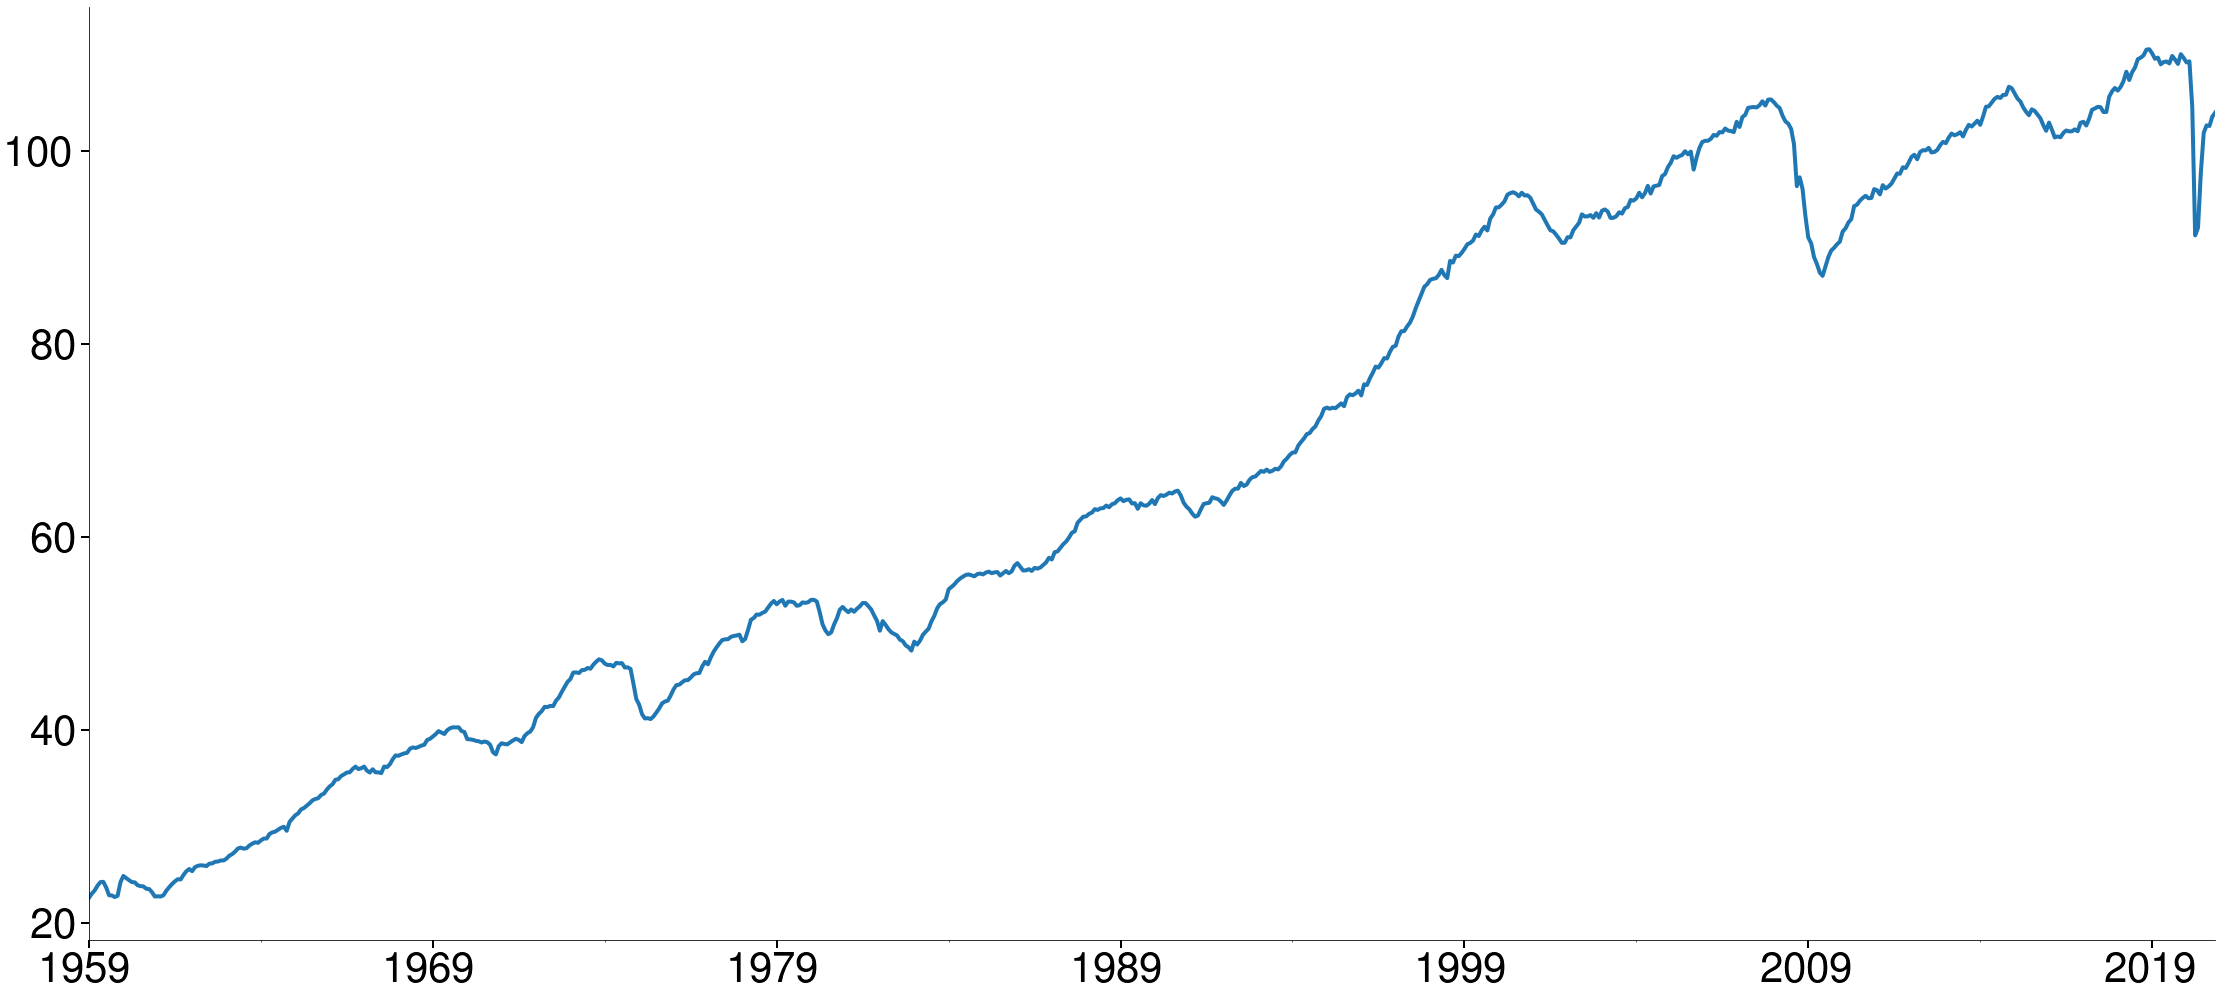

In [2]:
plot(orig.INDPRO)

# Housing Starts (NSA)

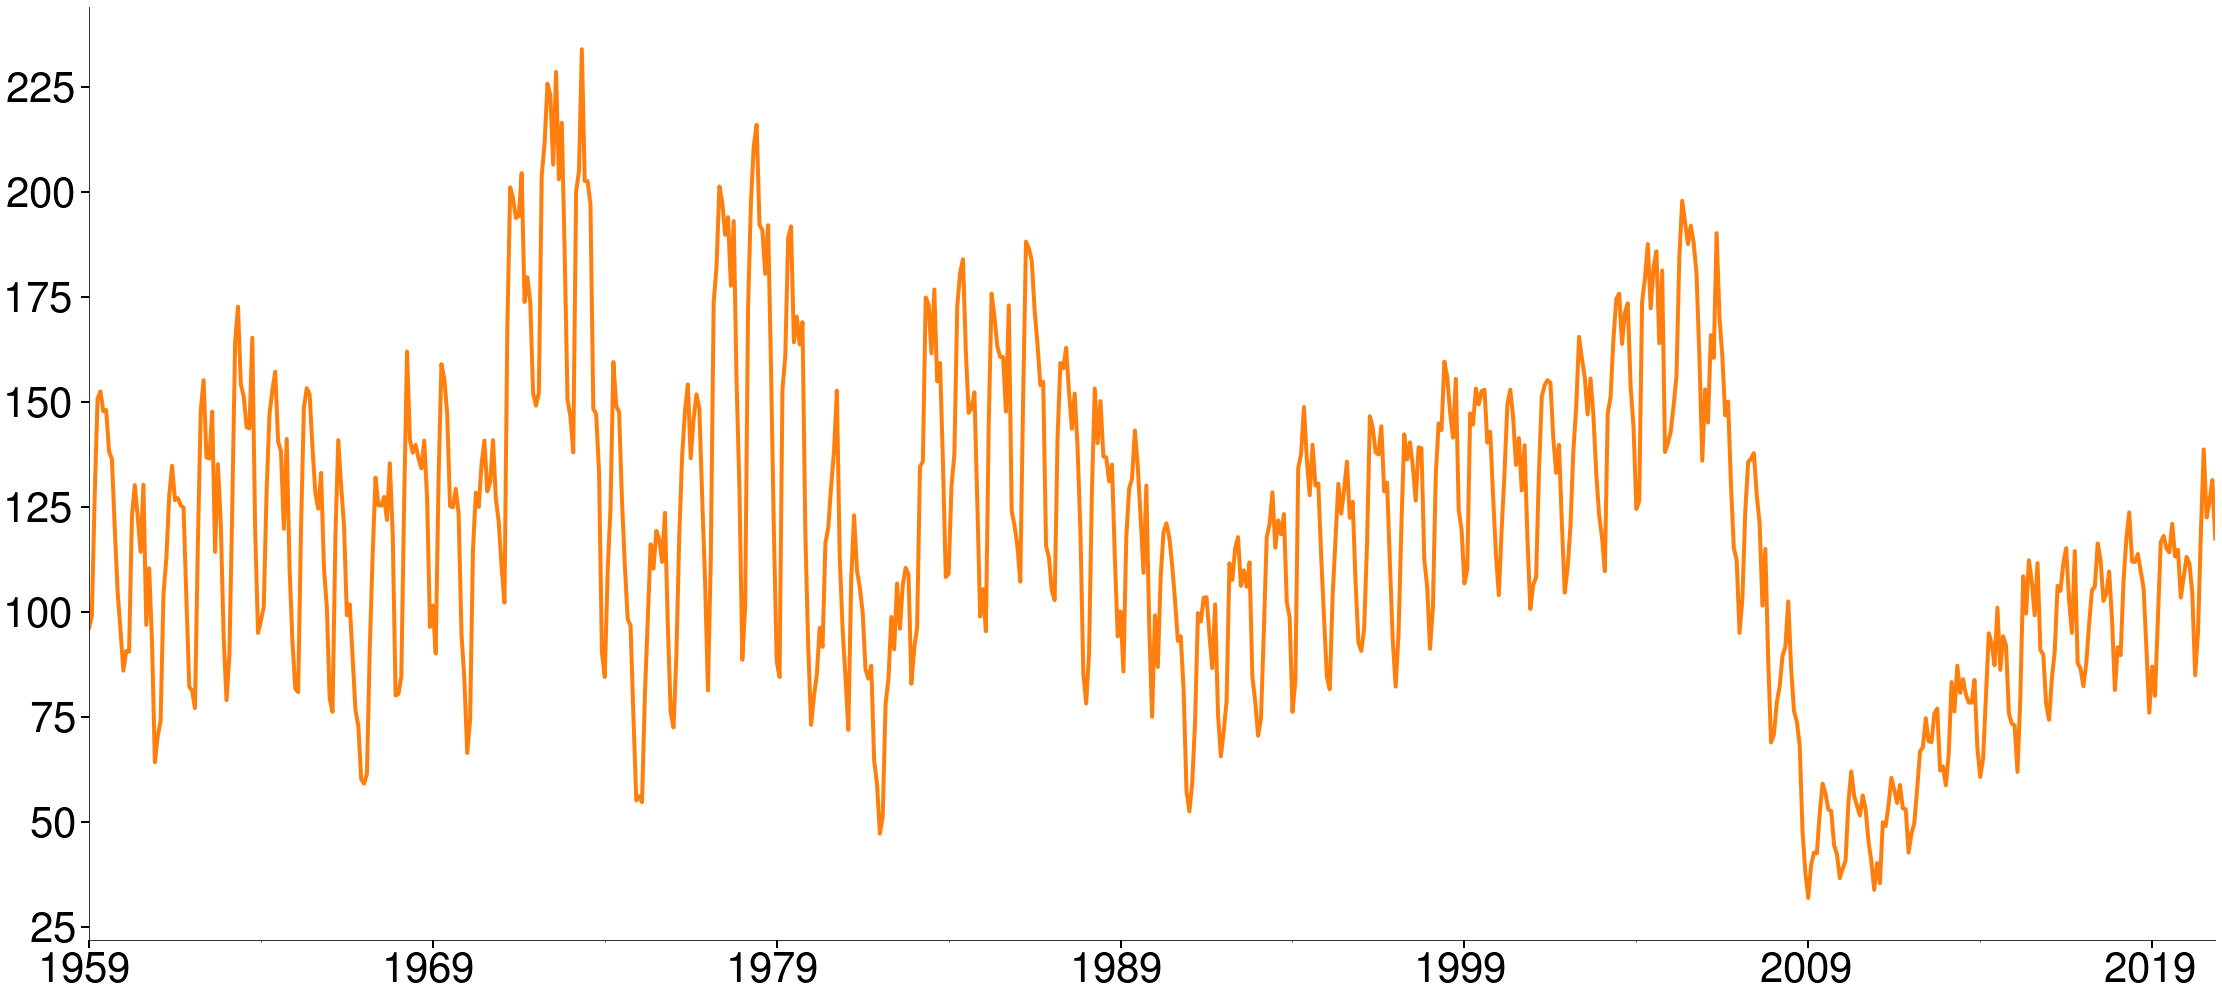

In [3]:
plot(orig.HOUSTNSA)

# Curvature of the Yield Curve



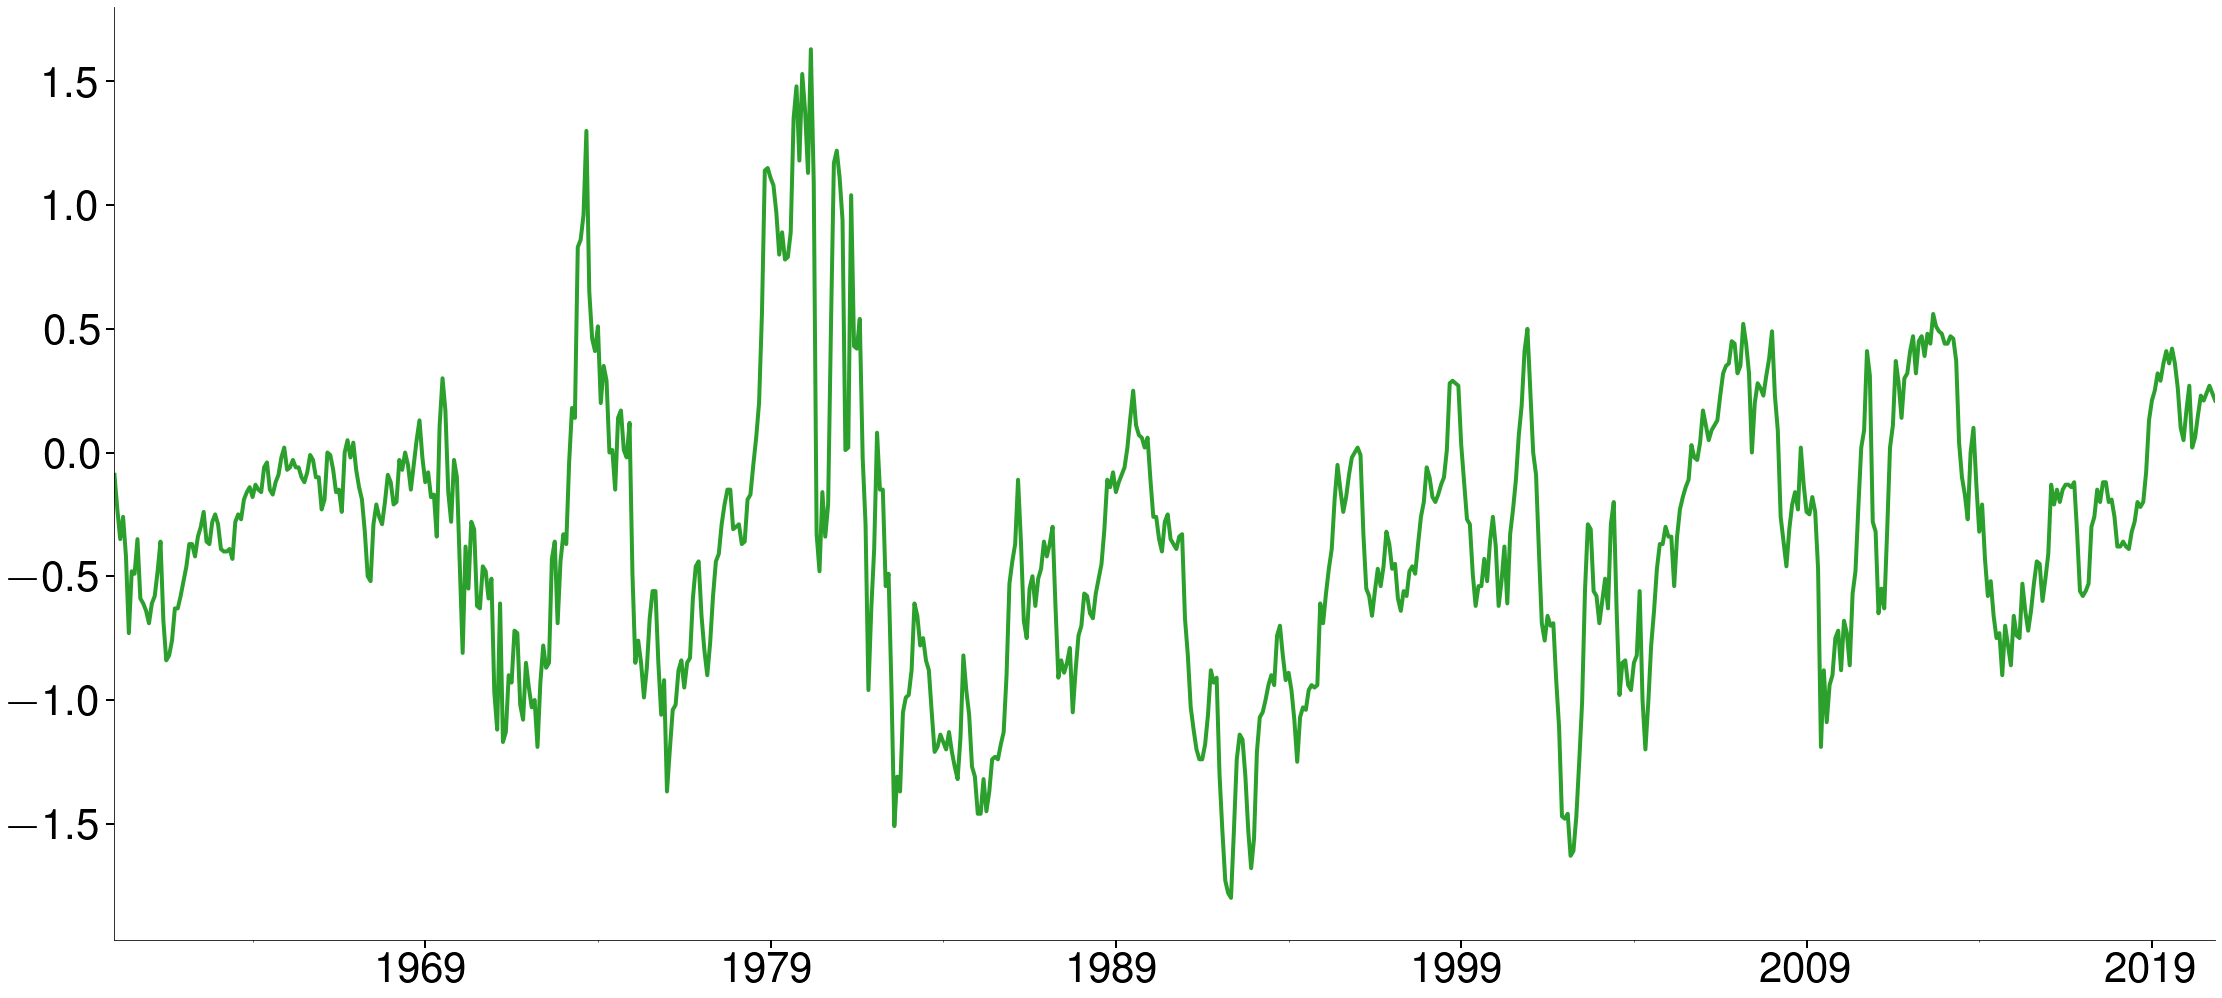

In [4]:
plot(curve)

# The Default Premium

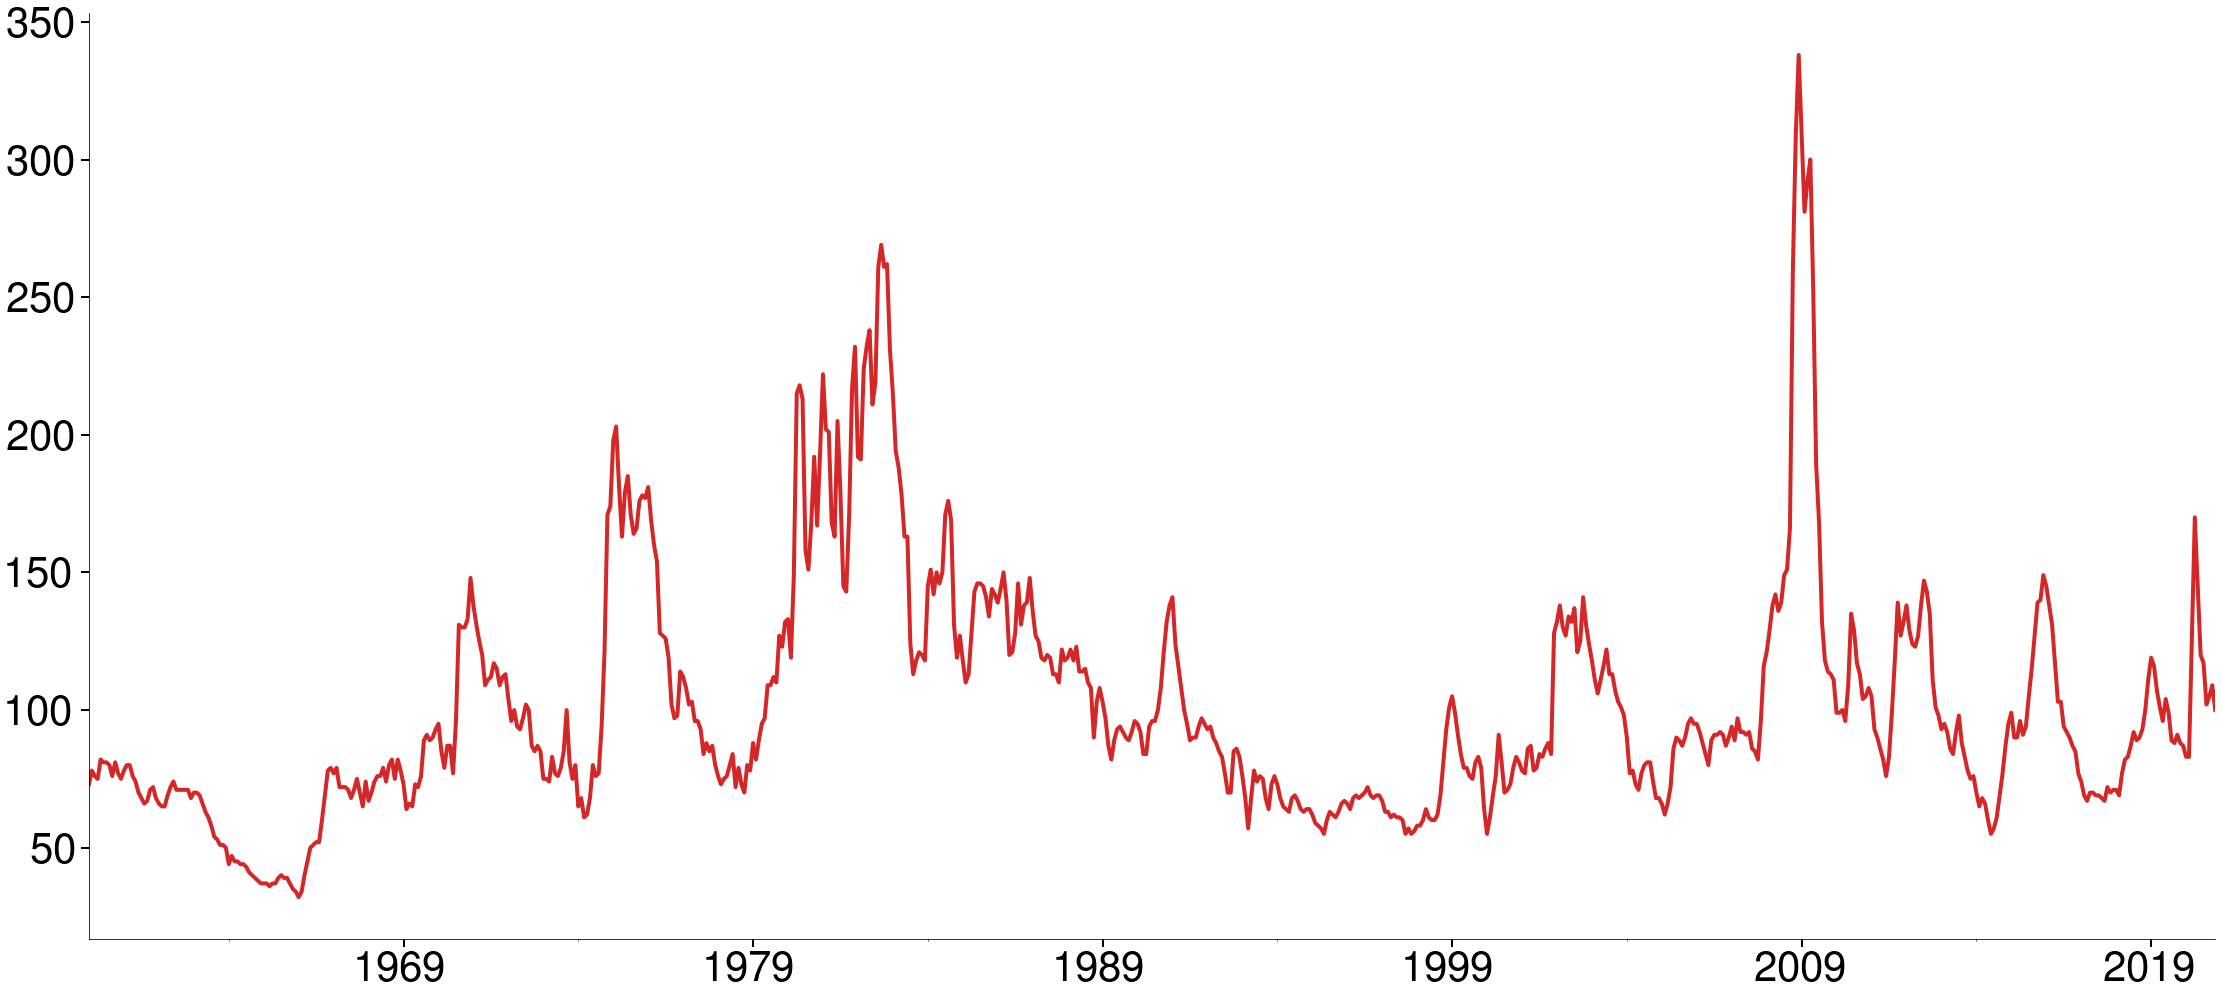

In [5]:
plot(default)

# US Construction Workers

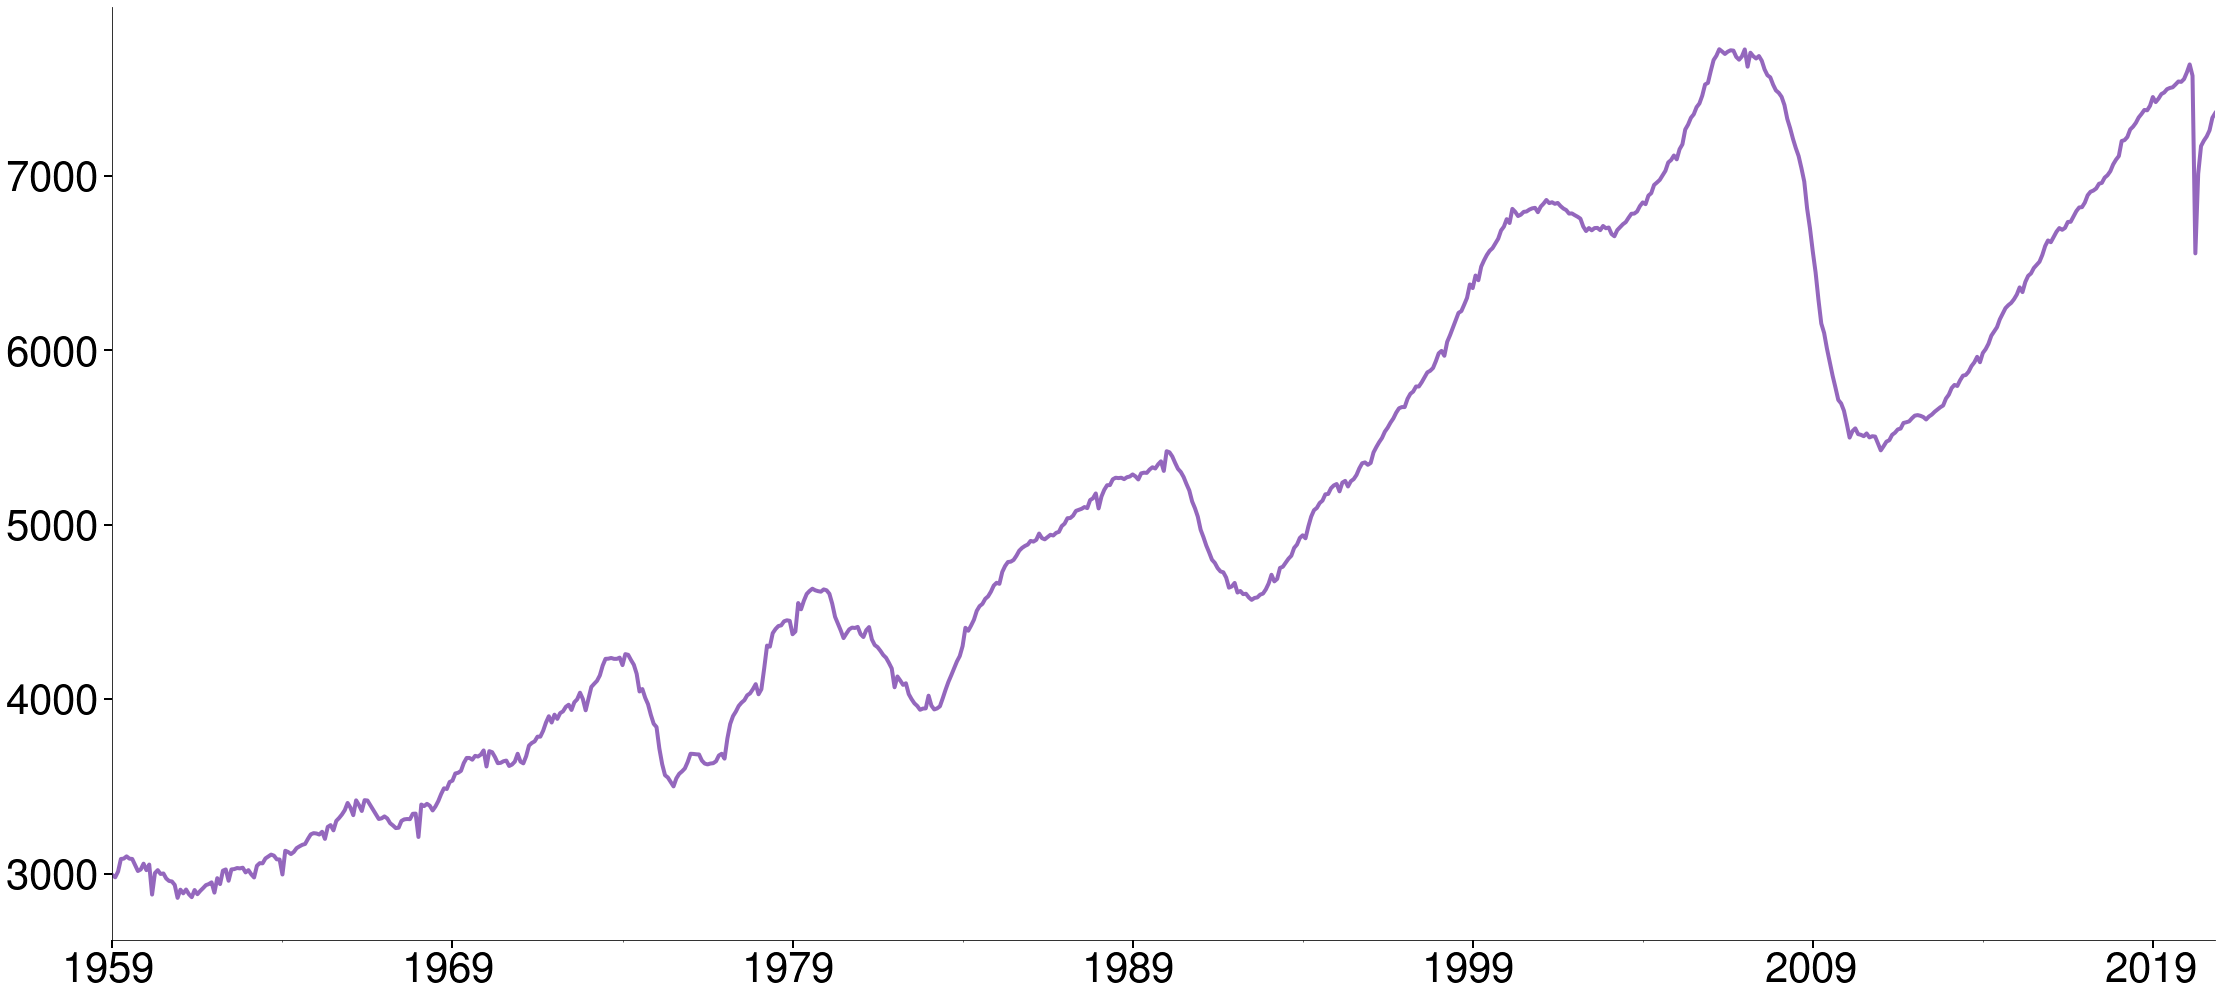

In [6]:
plot(orig.USCONS)

# Simulated AR(2) Data

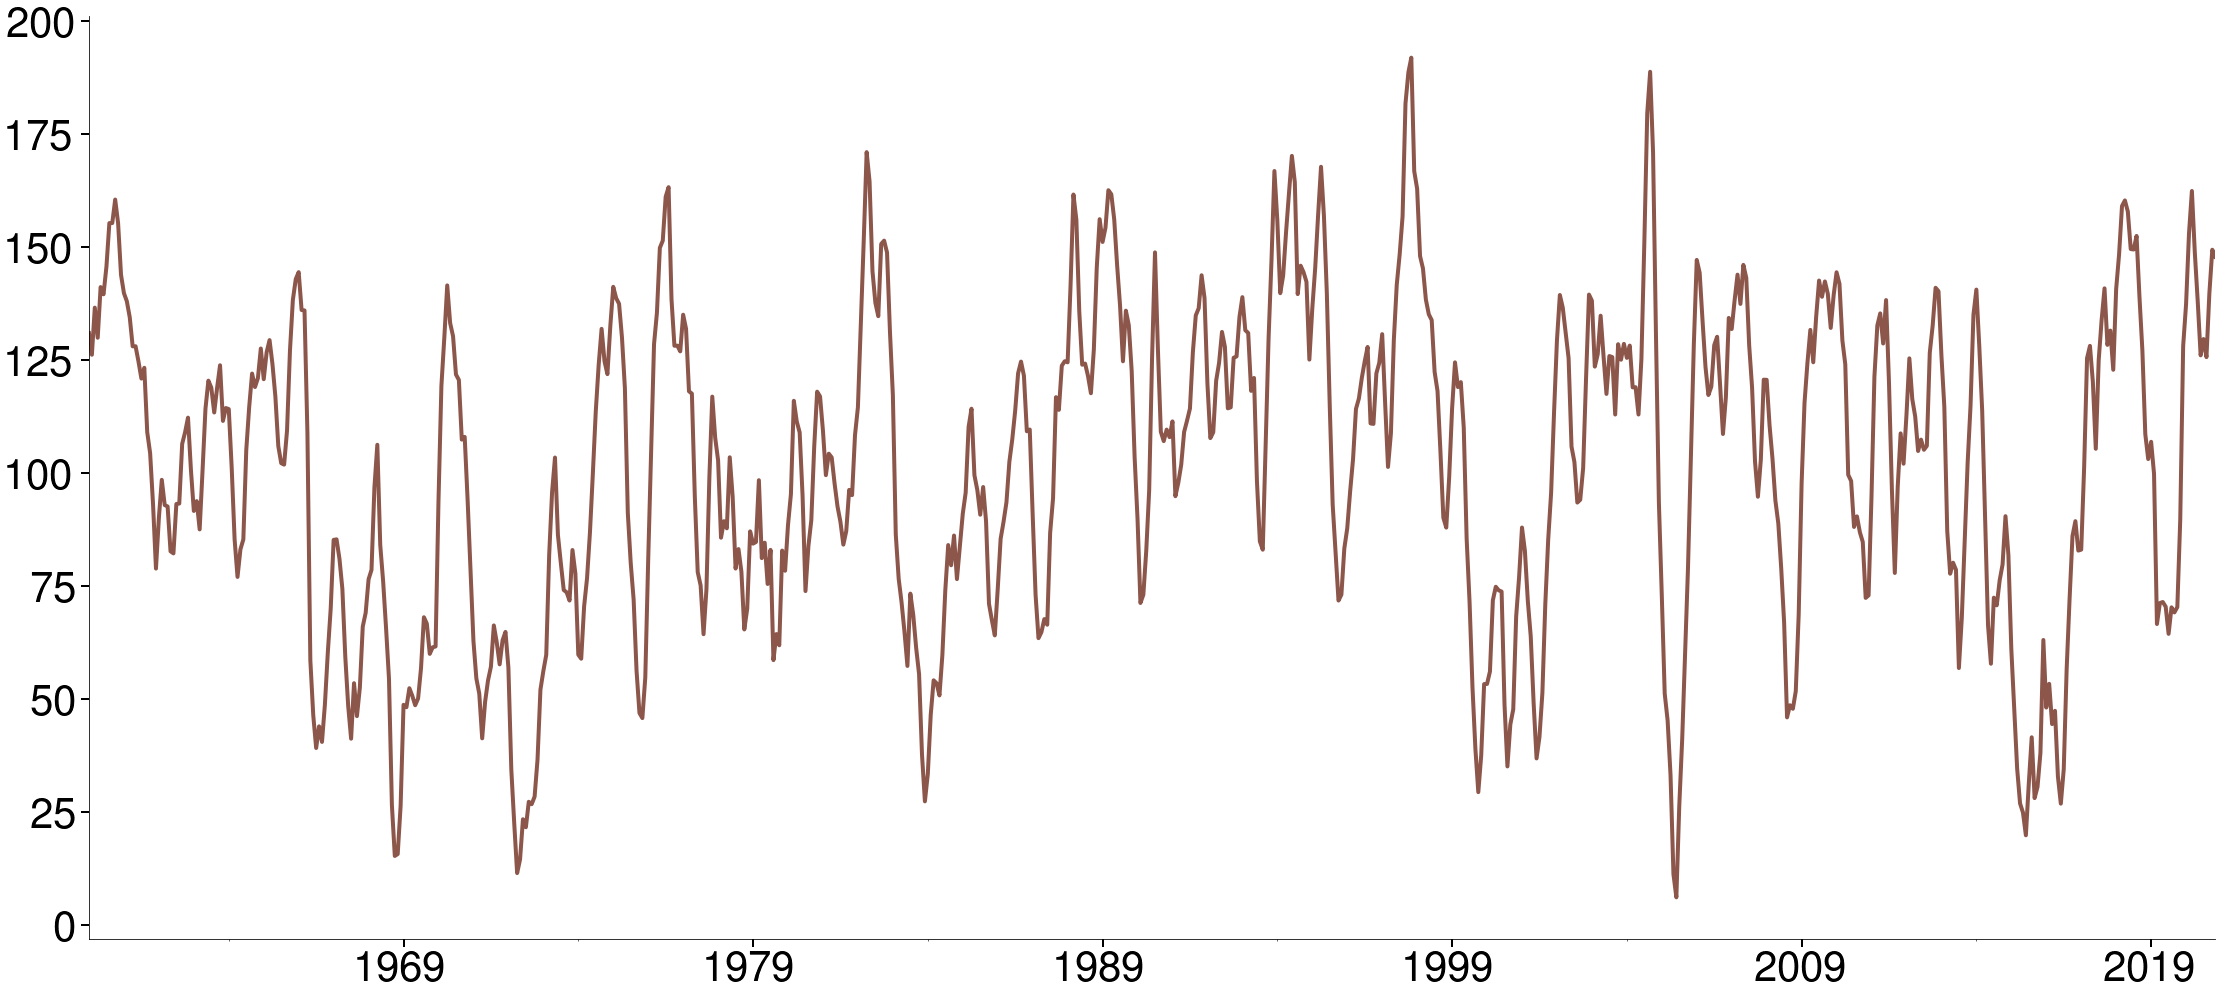

In [7]:
plot(sim)

# Covariance Stationarity

A stochastic process $Y_{t}$ is covariance stationary if 

$$
\begin{align}
\mathrm{E}\left[Y_{t}\right] &=\mu	\hspace{1em}\text{ for }t=1,2,\ldots \\
\mathrm{V}\left[Y_{t}\right]&=\sigma^{2}<\infty	\hspace{1em}\text{ for }t=1,2,\ldots \\
\mathrm{E}\left[(Y_{t}-\mu)(Y_{t-s}-\mu)\right]&=\gamma_{s}	\hspace{1em}\text{ for }t=1,2,\ldots,s=1,2,\ldots,t-1 \\
\end{align}
$$


# Transformations

* Natural log ($\ln$): commonly applied to series that are non-negative
* Difference ($\Delta Y_t = Y_t - Y_{t-1}$): removes trends
* Log difference ($\Delta \ln Y_t$): growth rate
* Year-over-year Log Difference ($\Delta_12 \ln Y_t$): annual growth  rate, removes _seasonality_


# Year-over-Year Industrial Production Growth

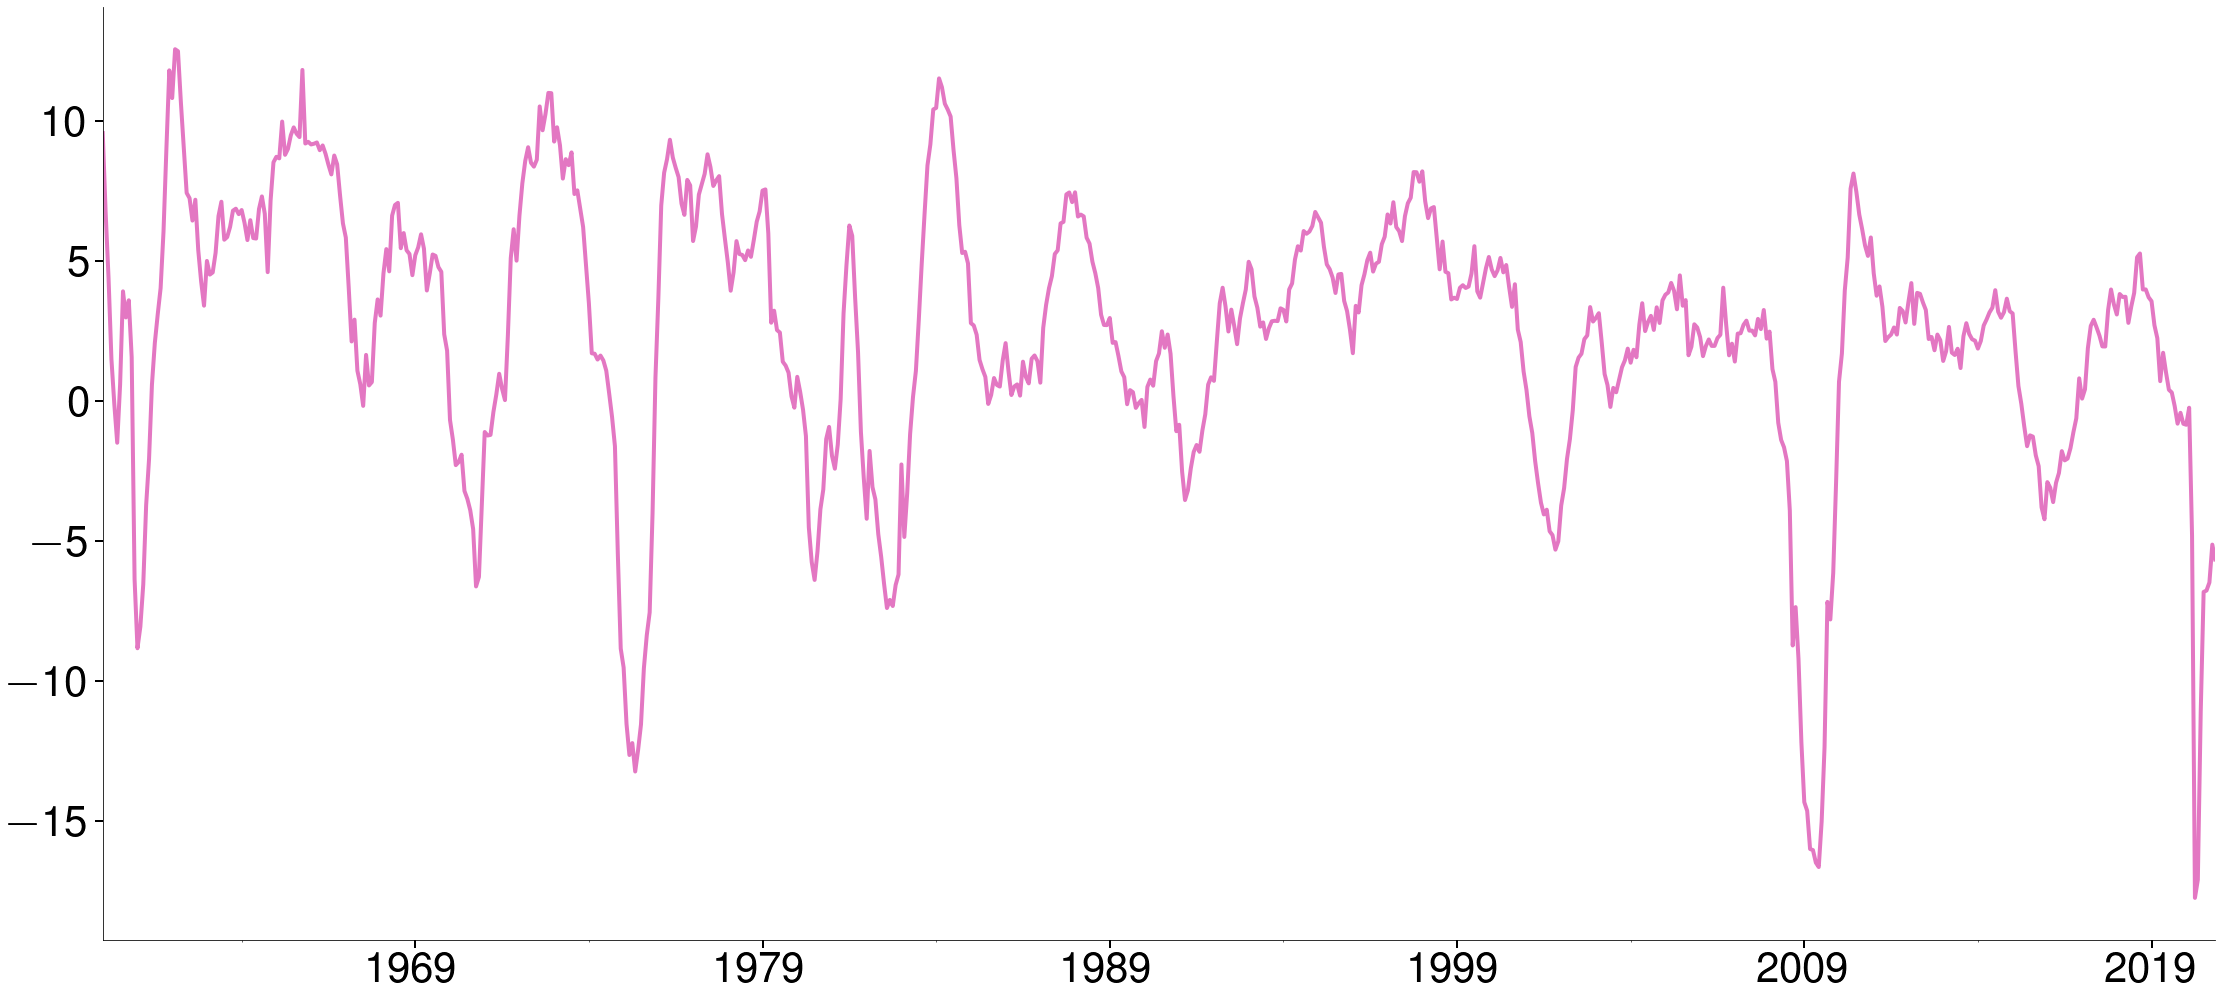

In [8]:
plot(indpro)

# Housing Start Growth Rate

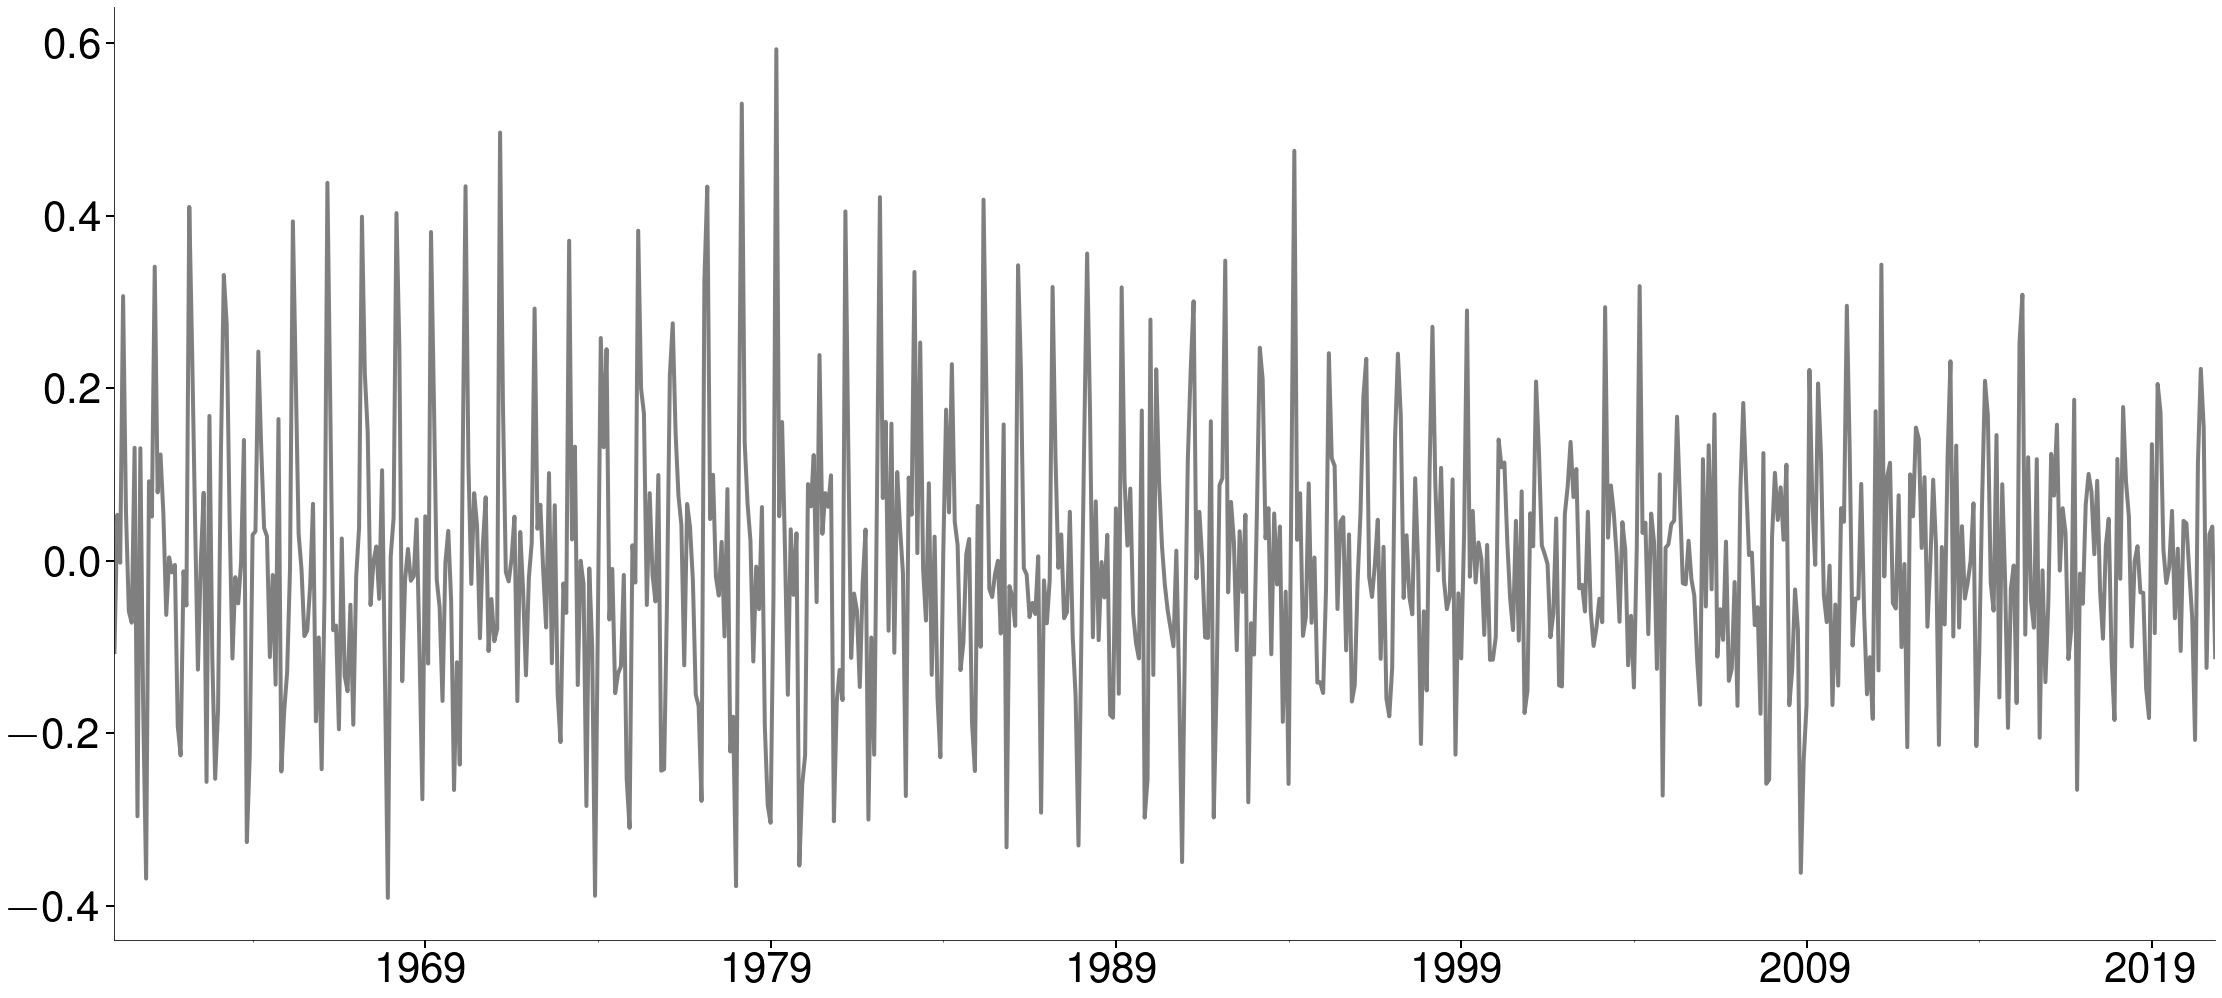

In [9]:
plot(housing)

# US Construction Workers Growth Rate

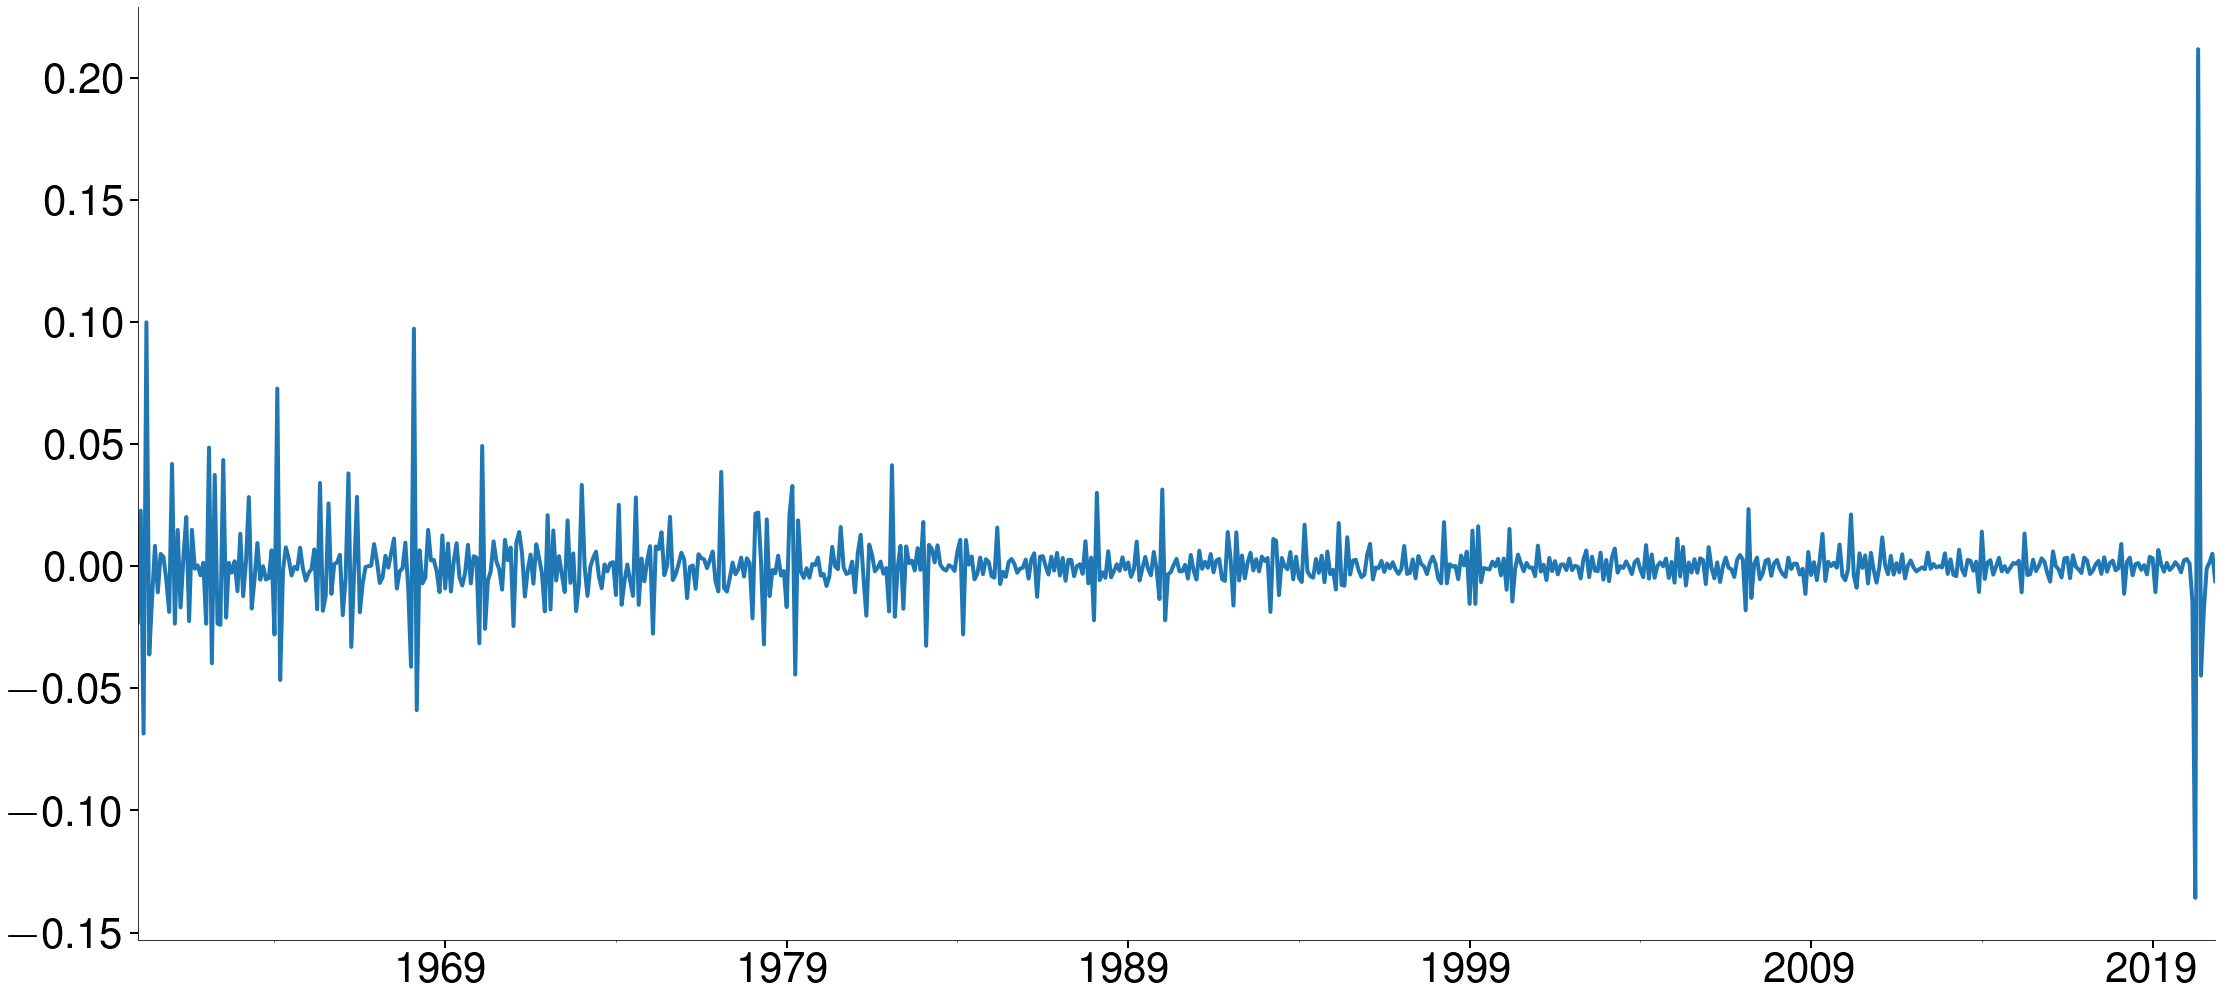

In [10]:
plot(uscons)

# Value-Weighted Market

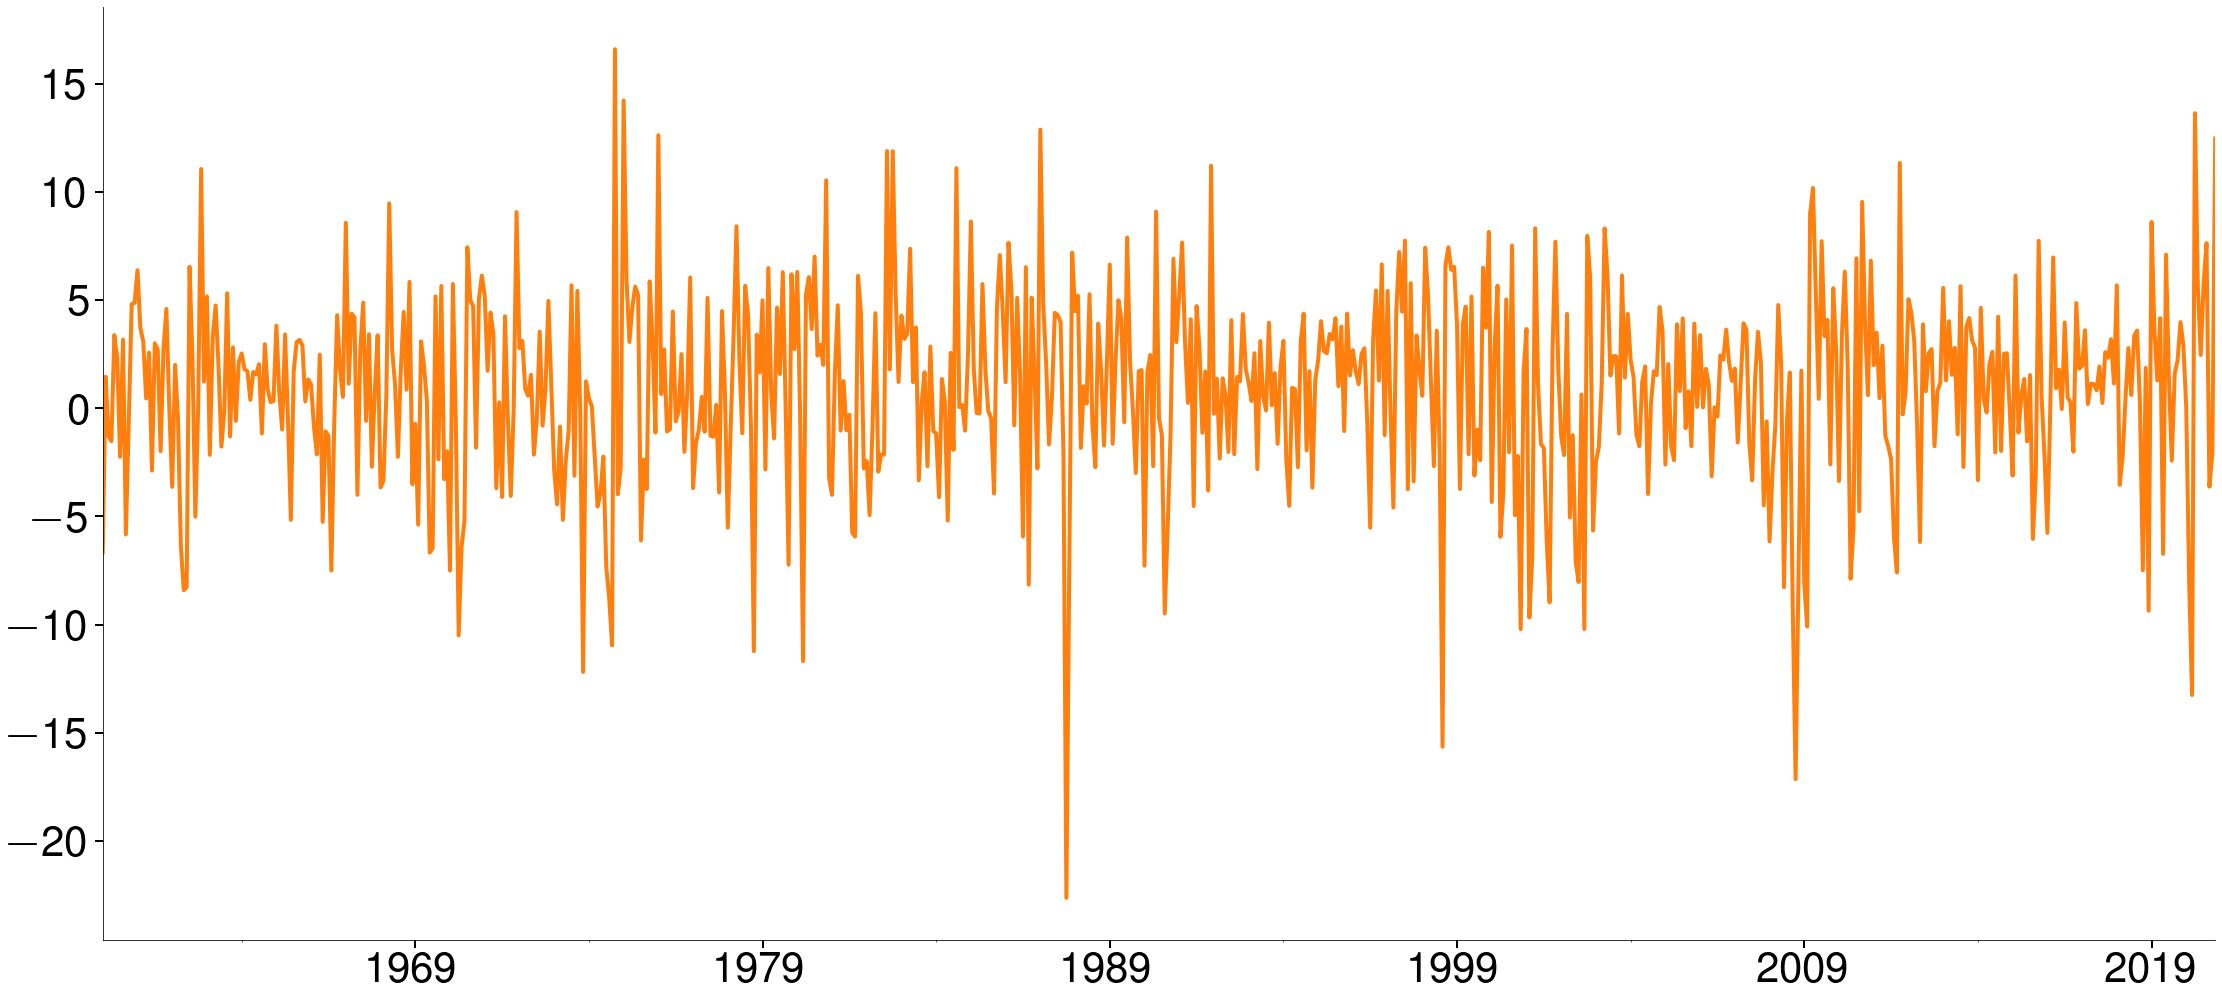

In [11]:
plot(vwm)

In [12]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import seaborn as sns


def acf_pacf_plot(y, lags, correct=False, title=None):
    a = acf(y, nlags=lags, fft=True)
    p = pacf(y, nlags=lags)
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    t = y.shape[0]
    ax[0].bar(x, a[1:])
    ax[1].bar(x, p[1:], color=mfe.colors[1])
    a_ci = p_ci = 1.96 * np.ones_like(a[1:]) / np.sqrt(t)
    if correct:
        a_ci = 1.96 * (1 + np.cumsum(a[:-1] ** 2)) / np.sqrt(t)
    x[0] = 0.5
    x[-1] = lags + 0.5
    ax[0].plot(x, a_ci, "k--", x, -a_ci, "k--")
    ax[1].plot(x, p_ci, "k--", x, -p_ci, "k--")
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("Autocorrelation")
    ax[1].set_title("Partial Autocorrelation")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)

# Identifying Candidate Models

* Exploit pattern and autocorrelation and partial autocorrelation
* Autocorrelation

$$ \textrm{Corr}(Y_t,Y_{t-s}) = \frac{\gamma_s}{\gamma_0} $$

* Partial Autocorrelation

$$ \textrm{Corr}(Y_t,Y_{t-s}|Y_{t-1},\ldots,Y_{t-s+1}) $$

# YoY Industrial Production Growth

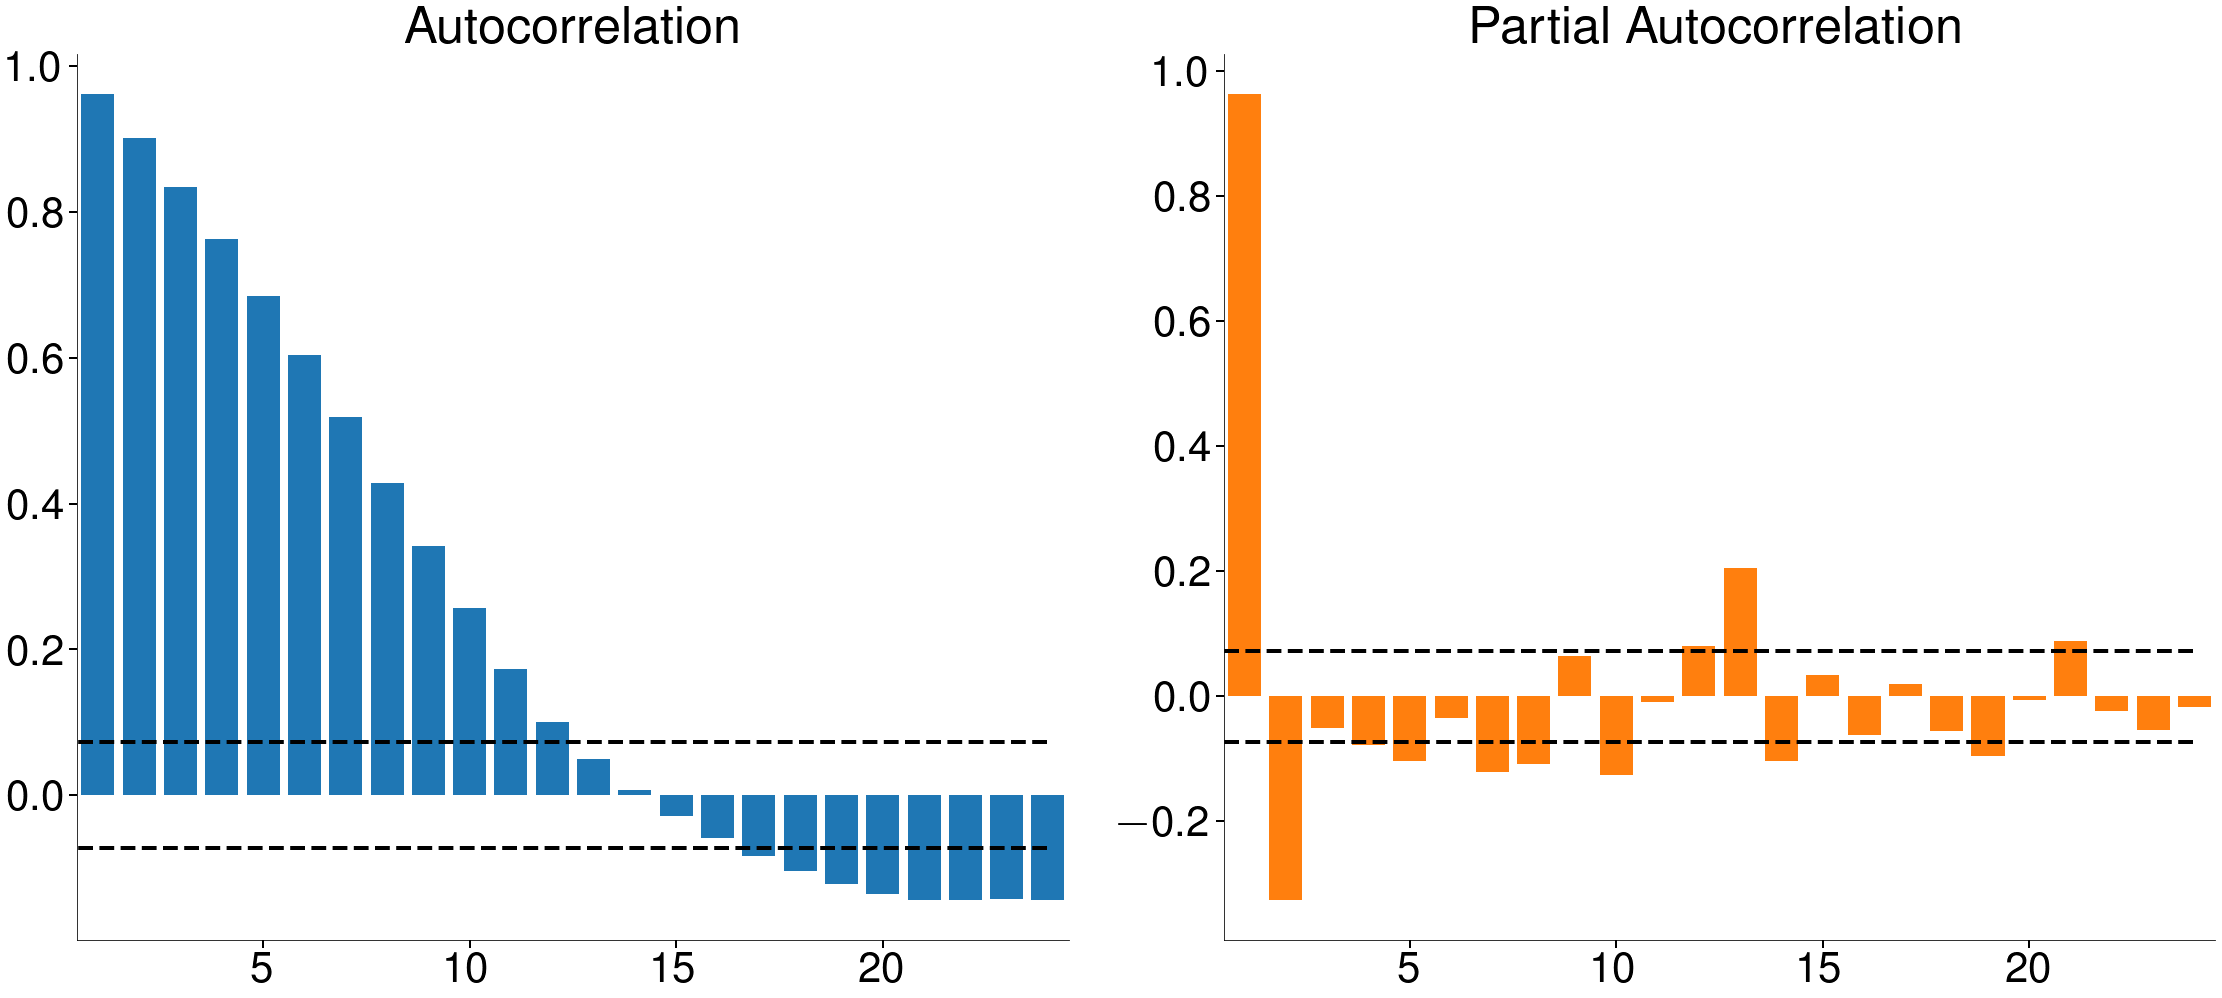

In [13]:
acf_pacf_plot(indpro, 24)

# Curvature

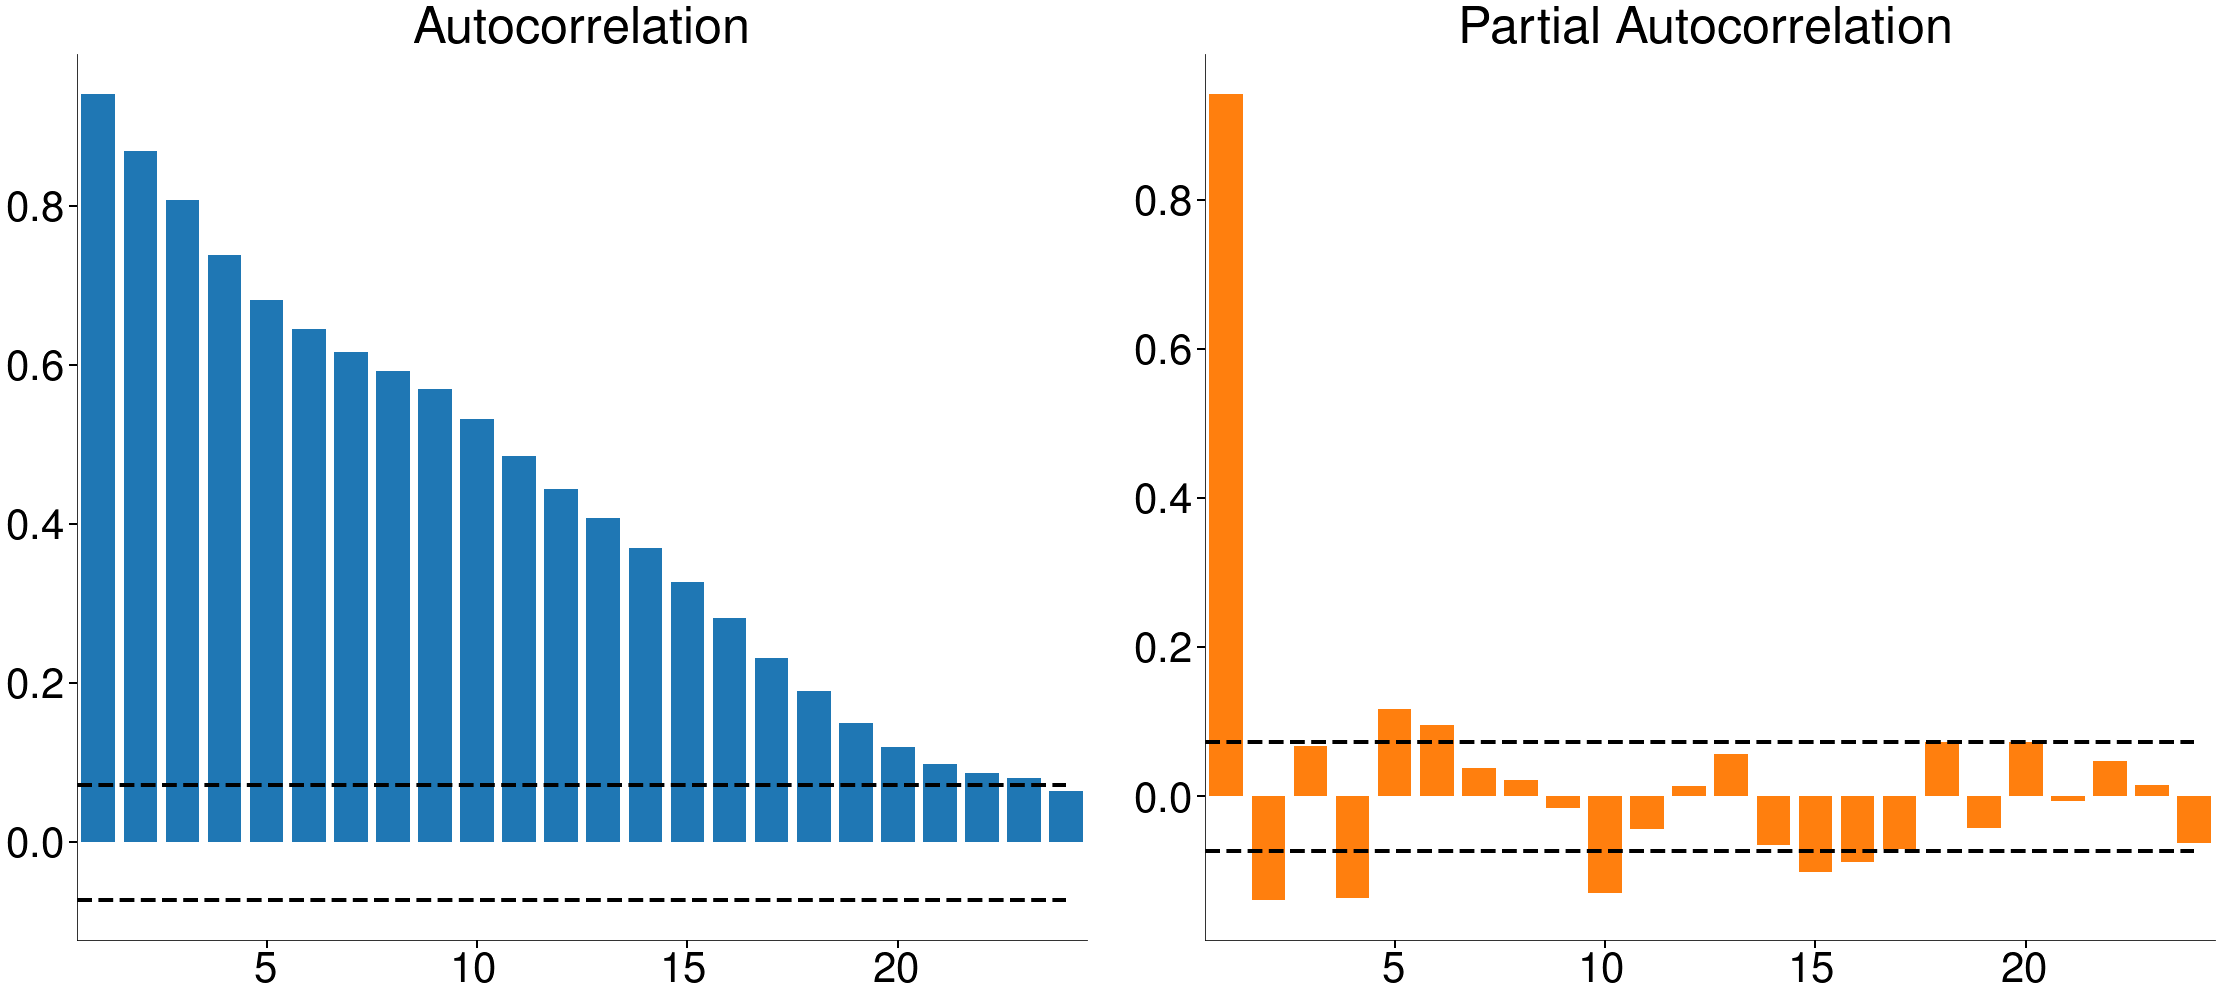

In [14]:
acf_pacf_plot(curve, 24)

# Default Premium

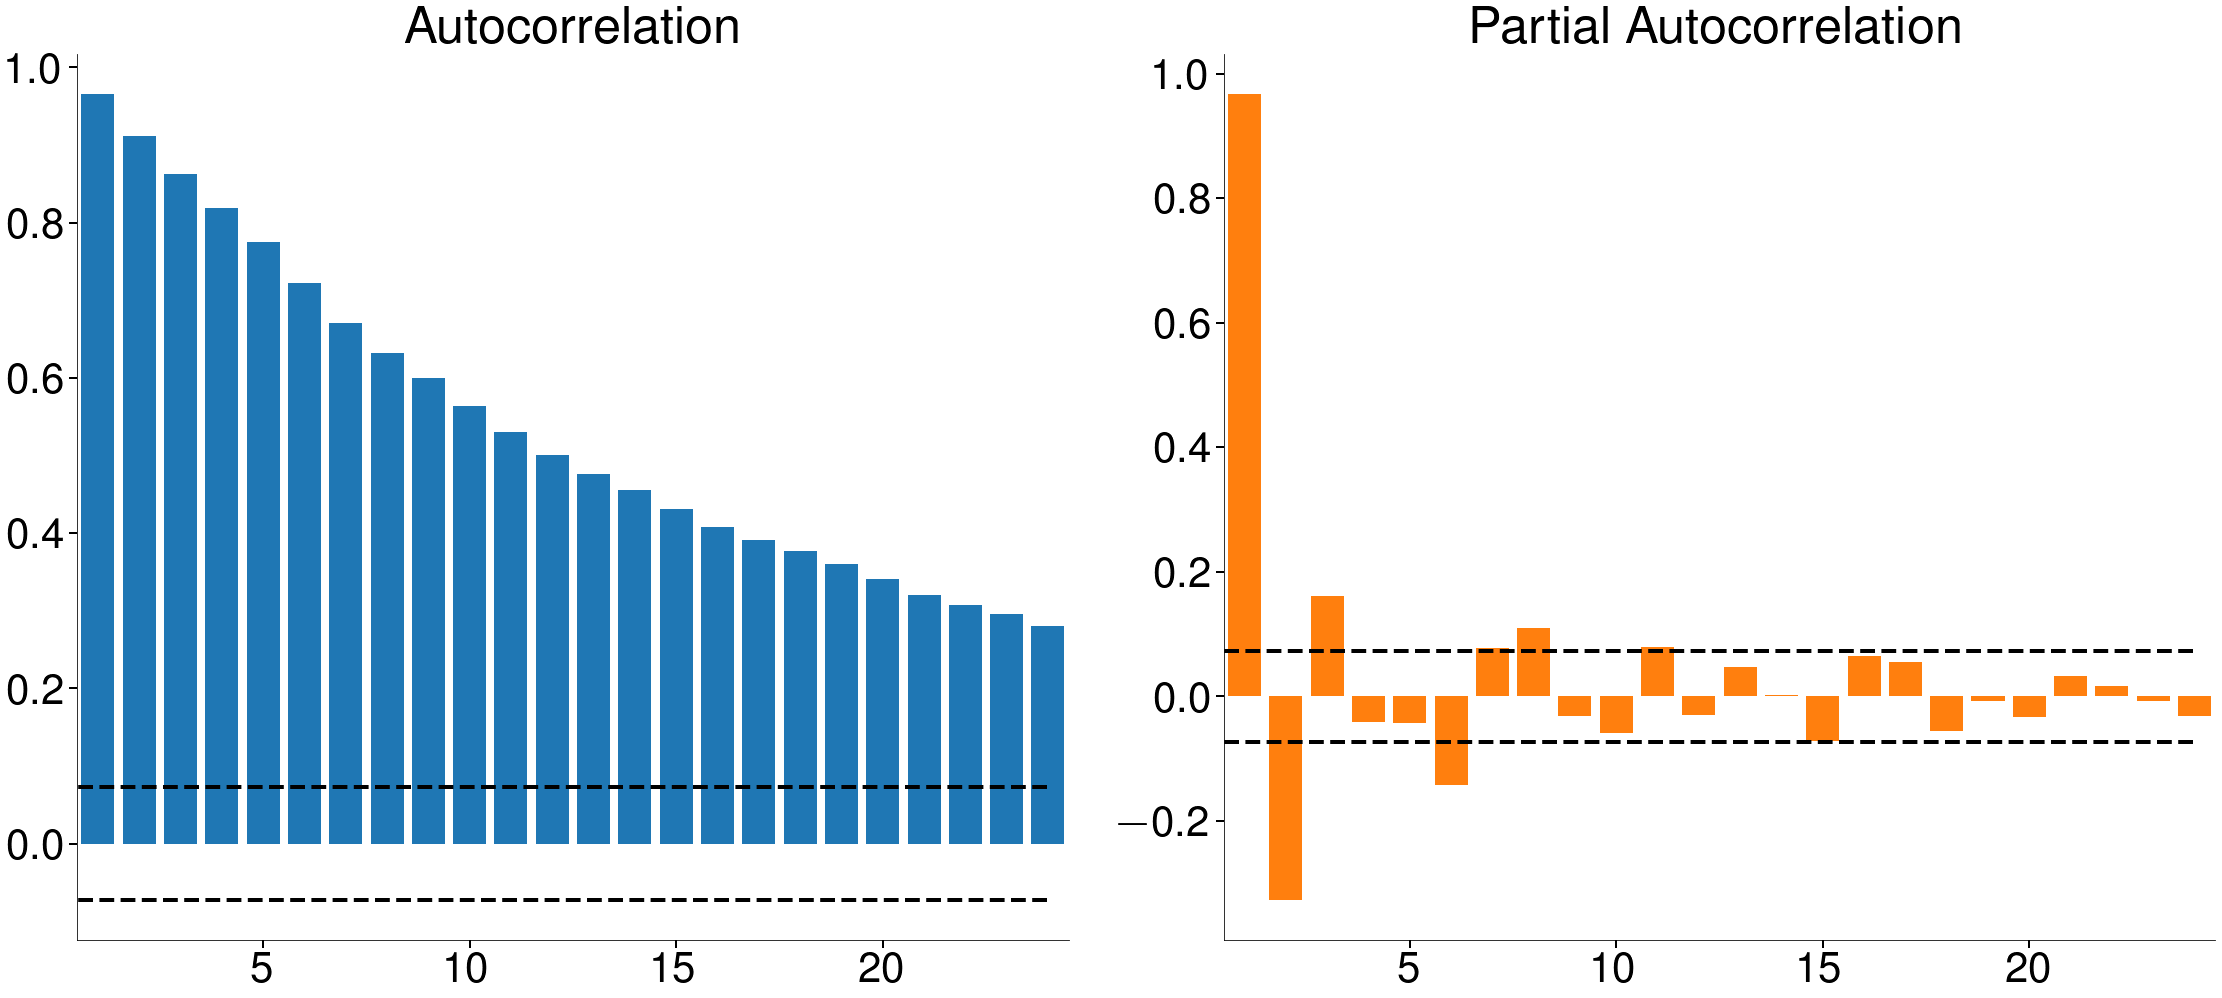

In [15]:
acf_pacf_plot(default, 24)

# Simulated AR(2)

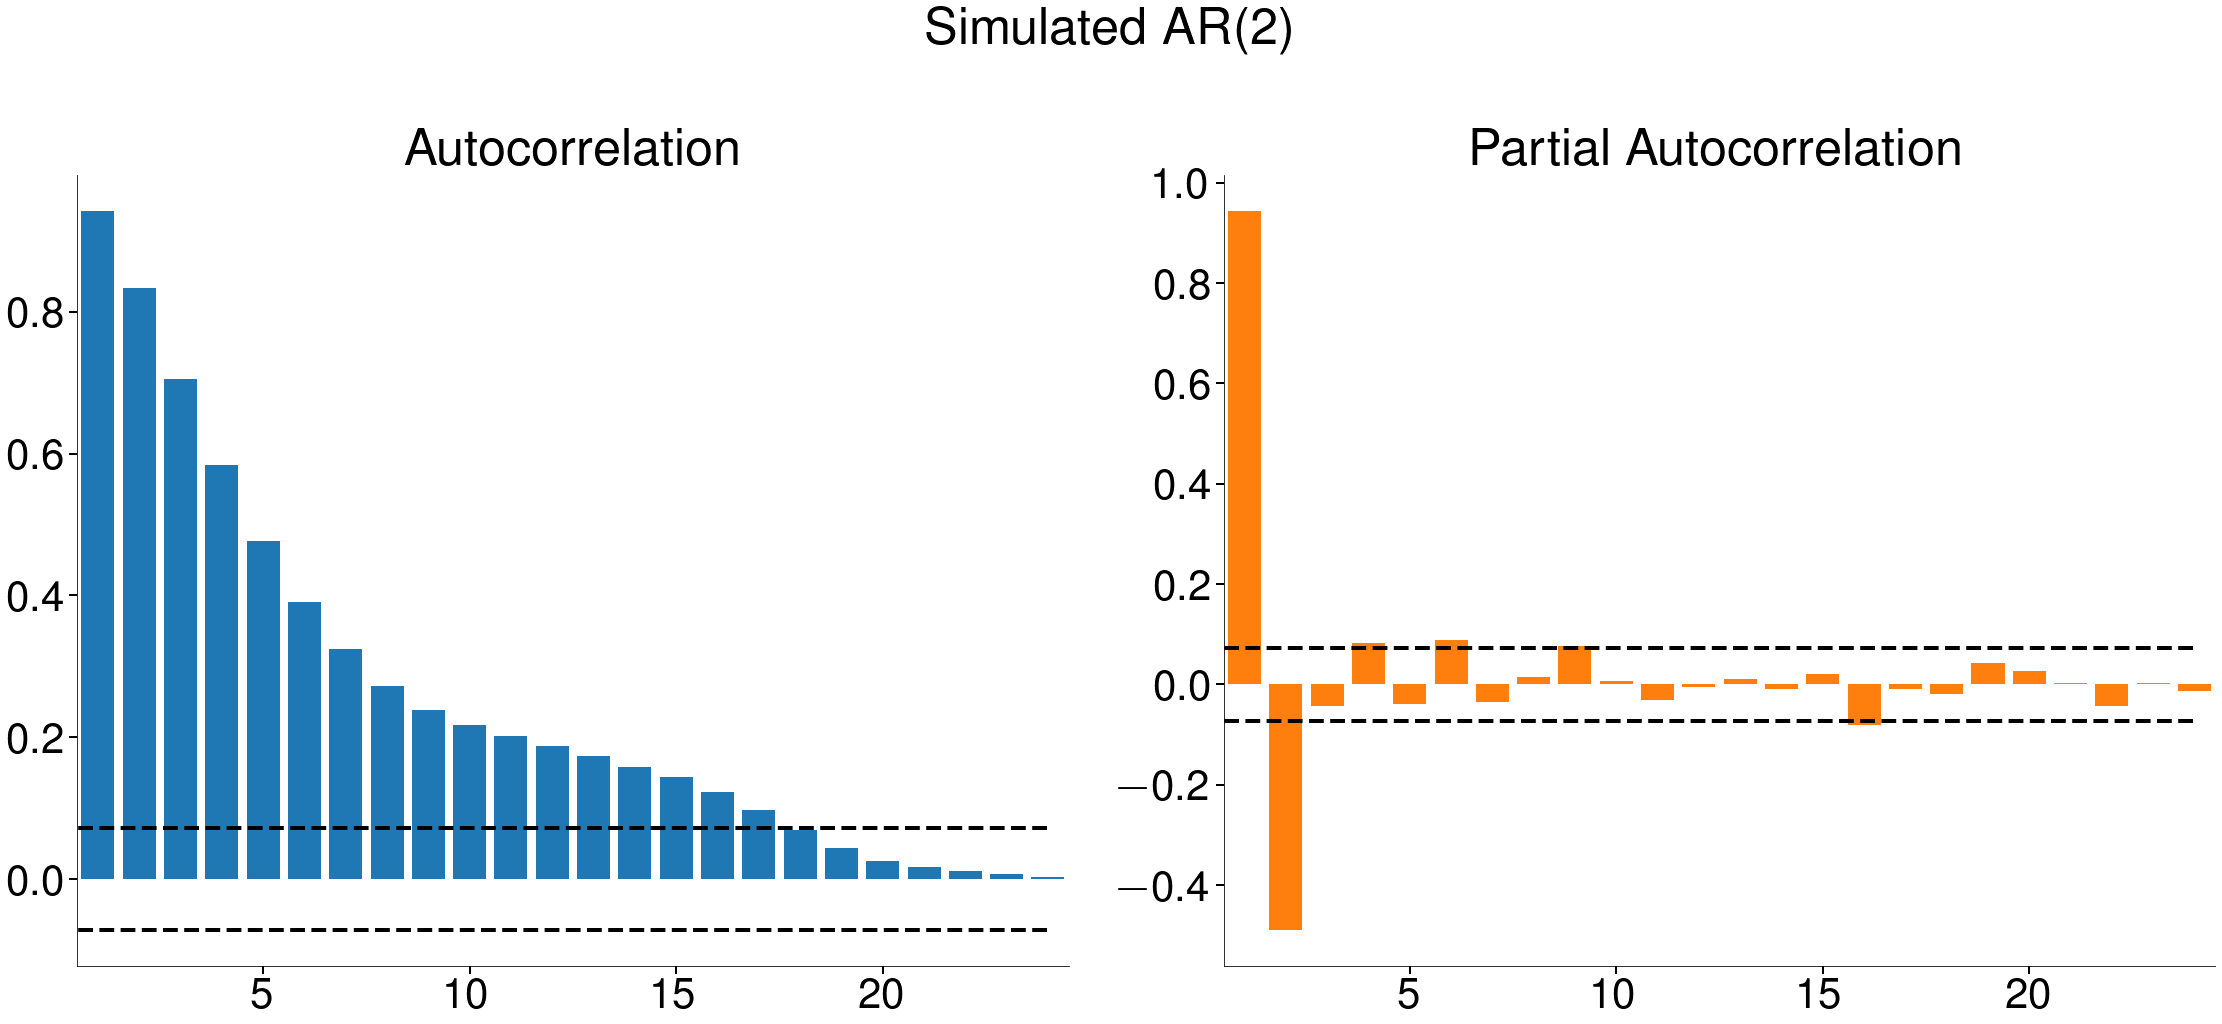

In [16]:
acf_pacf_plot(sim, 24, title="Simulated AR(2)")

# Construction Worker Growth

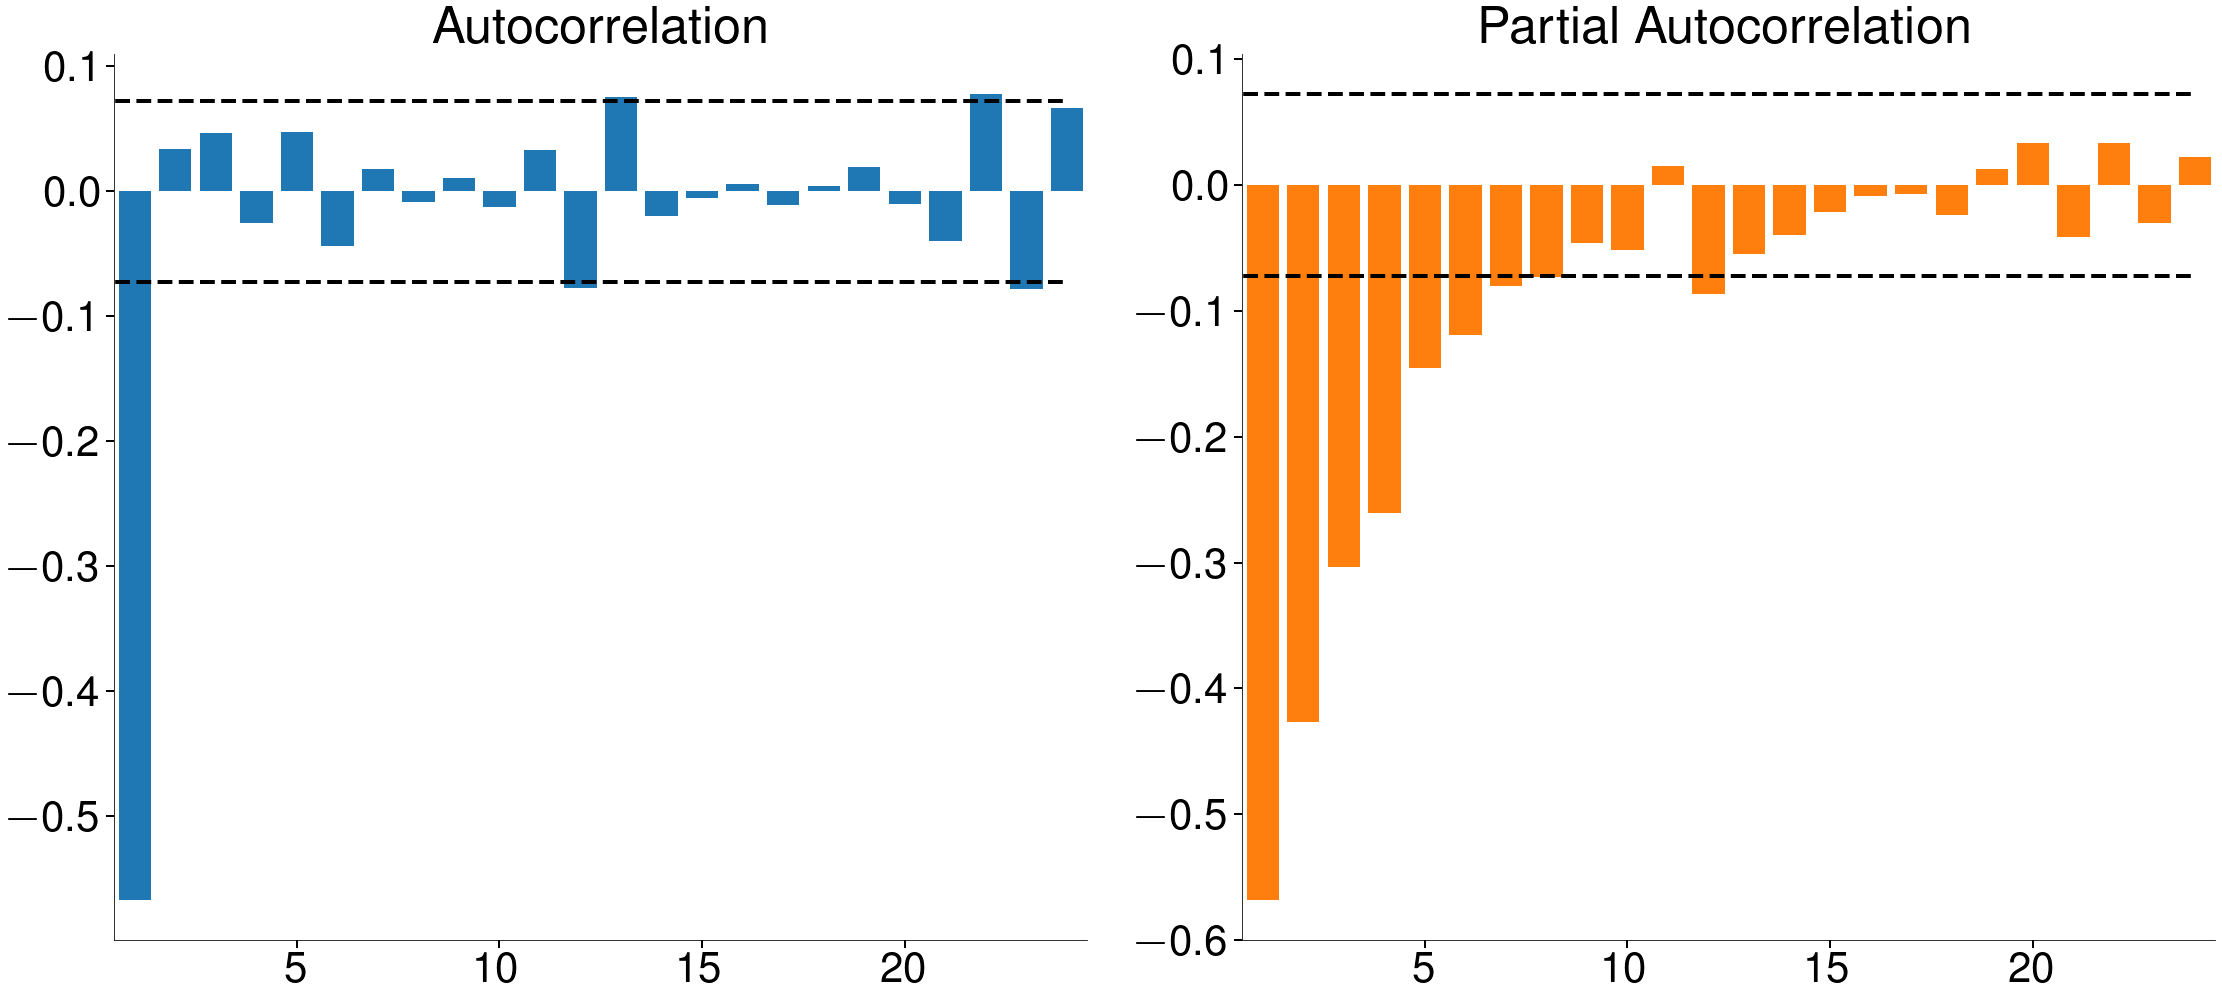

In [17]:
acf_pacf_plot(uscons, 24)

# Housing Start Growth Rate

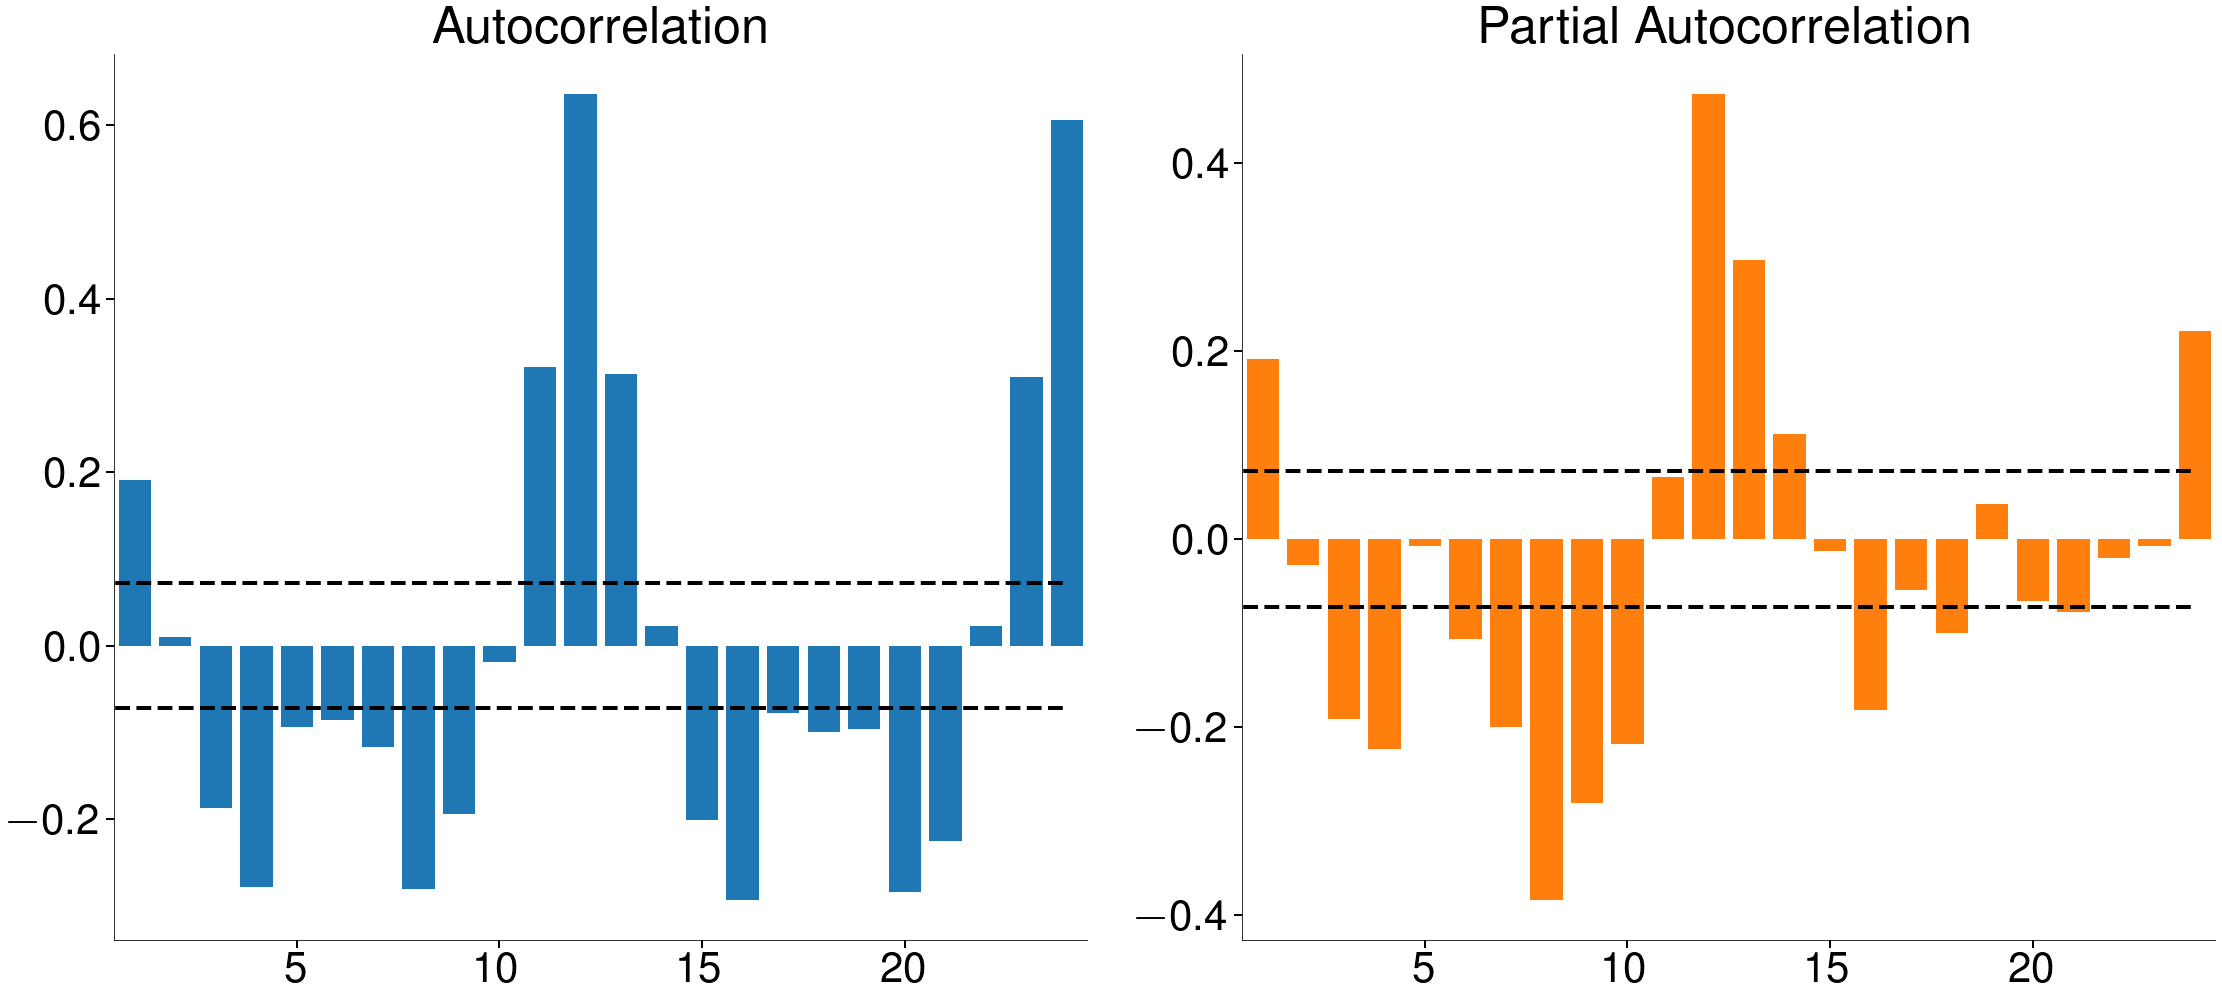

In [18]:
acf_pacf_plot(housing, 24)

# US Construction Worker Growth Rate

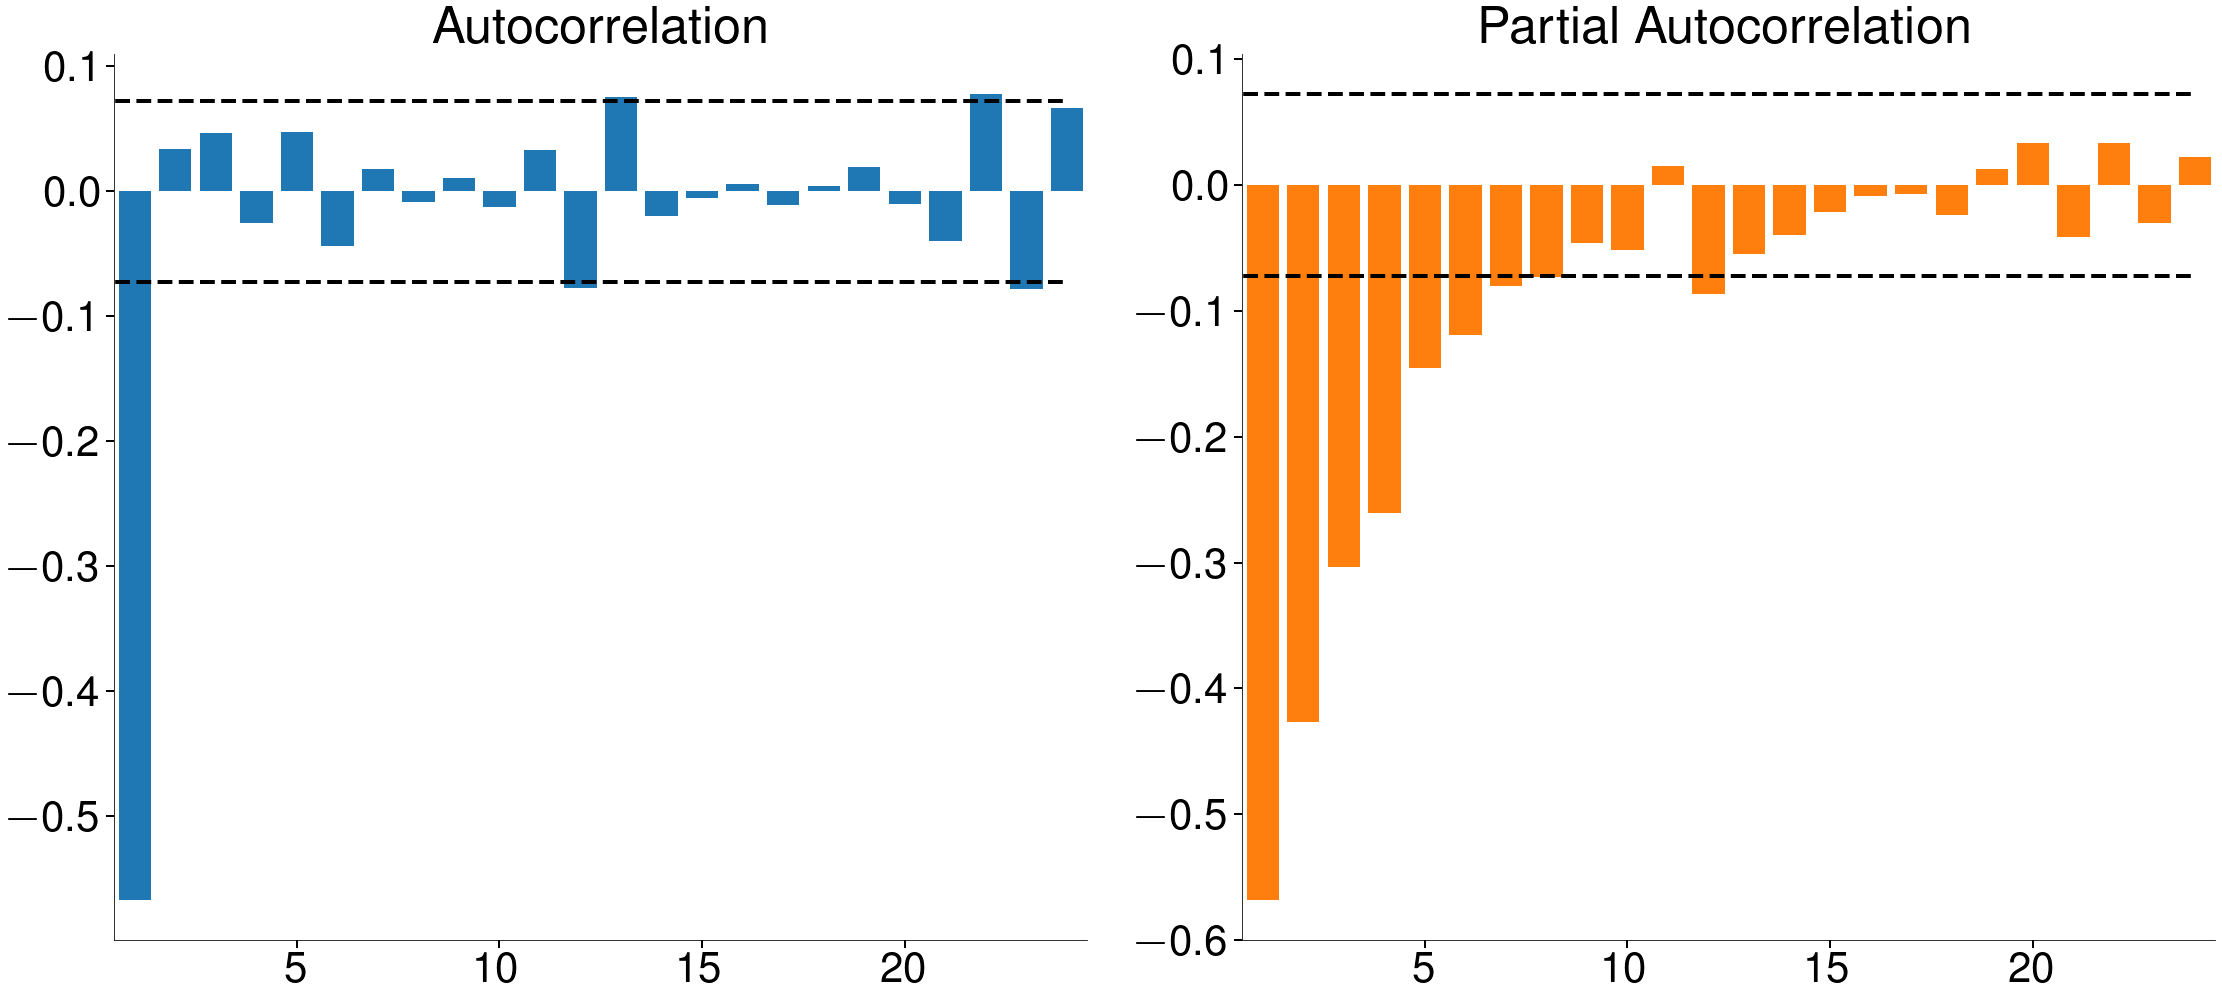

In [19]:
acf_pacf_plot(uscons, 24)

# Value-Weighted Market

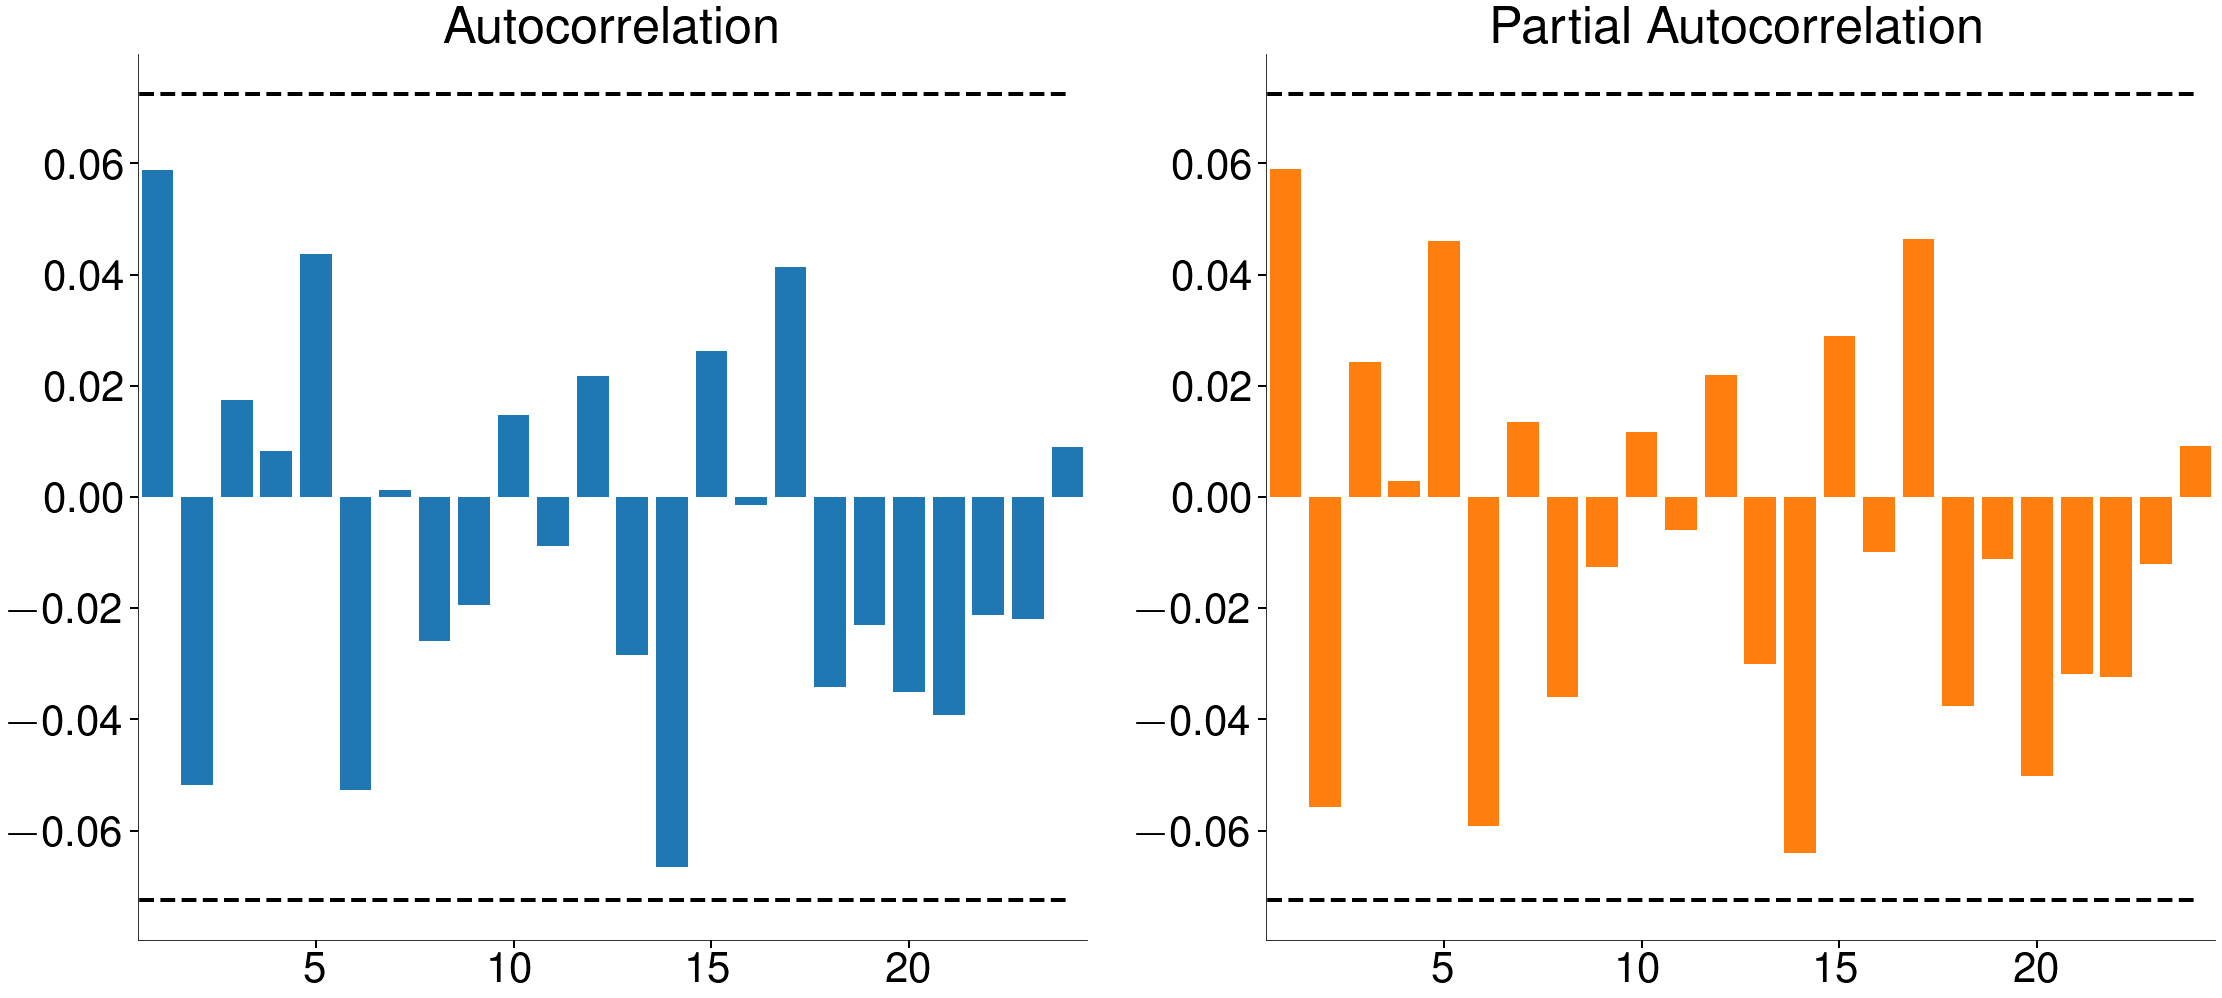

In [20]:
acf_pacf_plot(vwm, 24)

# Fitting an initial model

* Begin with an AR(1) with a constant to Industrial Production Growth

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} + \epsilon_t $$

* $\epsilon_t \sim WN\left(0,\sigma^2\right) $

* A process $\{\epsilon_{t}\}$ is known as white noise if
  
$$
\begin{align}
\mathrm{E}\left[\epsilon_{t}\right] & =0	\hspace{1em}\mbox{ }\text{ for }t=1,2,\ldots \\
\mathrm{V}\left[\epsilon_{t}\right] & =\sigma^{2}<\infty	\hspace{1em}\mbox{ }\text{ for }t=1,2,\ldots \\
\mathrm{E}\left[\epsilon_{t}\epsilon_{t-j}\right] & =0	\hspace{1em}\mbox{ }\text{ for }t=1,2,\ldots,\mbox{ }j\neq0
\end{align}
$$

* Estimate parameters using Exact MLE
  * Discard $\max(P,Q)$ residuals
  * Model parameters include $\sigma^2\equiv\mathrm{V}\left[\epsilon_t\right]$

In [21]:
from statsmodels.tsa.api import SARIMAX

# Industrial Production Growth

In [22]:
mod = SARIMAX(indpro, order=(1, 0, 0), trend="c")
res = mod.fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0780,0.046,1.708,0.088,-0.011,0.167
ar.L1,0.9673,0.007,132.070,0.000,0.953,0.982
sigma2,1.5703,0.027,58.347,0.000,1.518,1.623


# Diagnostics

* Plot residuals
* Residual Autocorrelations and Partial Autocorrelations
* Ljung-Box Q Test 
* LM Test of Serial Correlation

# Model Residuals

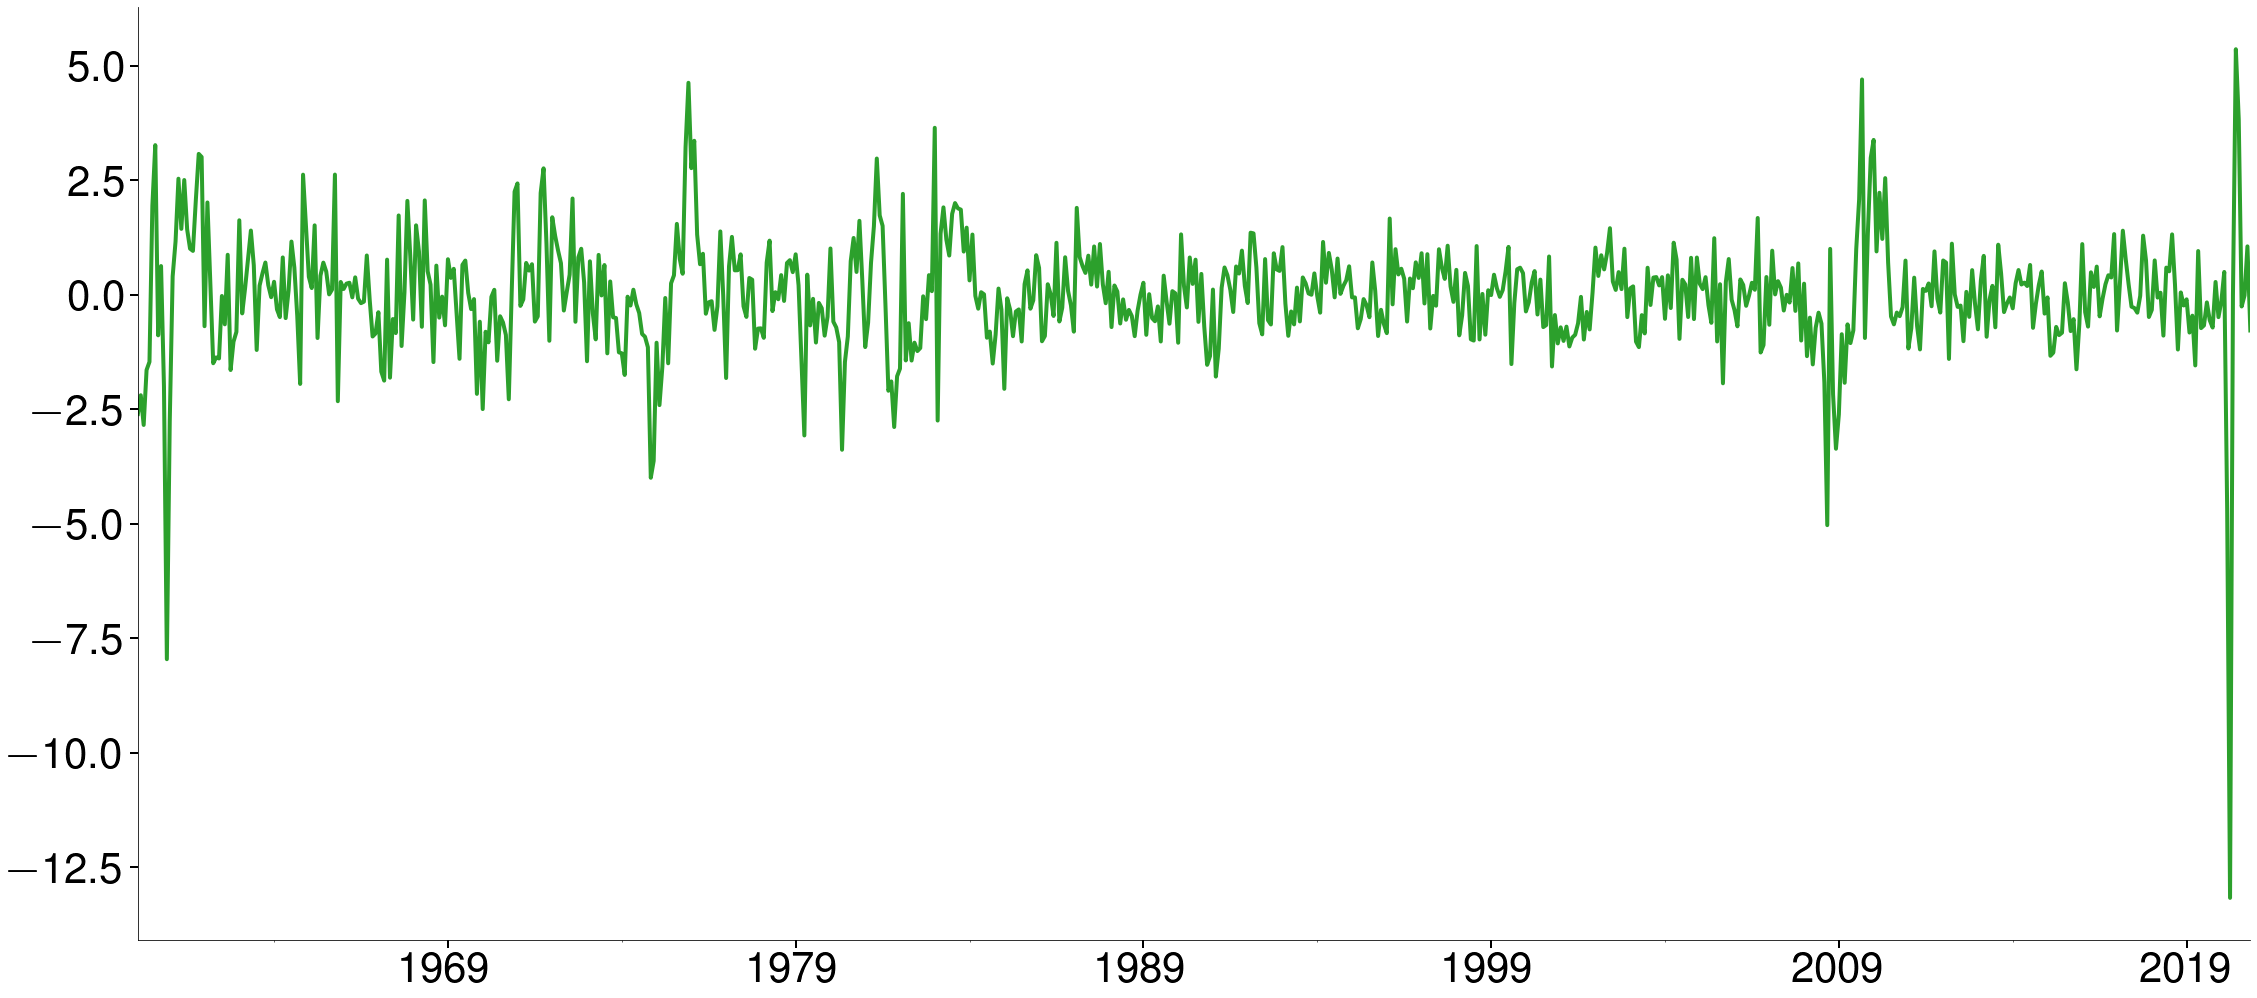

In [23]:
resid = res.resid.iloc[1:]
plot(resid)

# Residual Autocorrelation

* Inference on autocorrelations

$$
\begin{align}
\mathrm{V}[\hat{\rho}_{s}]	= & T^{-1}	\textrm{ for } s=1 \\
	= & T^{-1}(1+2\sum_{j=1}^{s-1}\hat{\rho}_{j}^{2})	\textrm{ for } s>1
\end{align}
$$

* Inference on partial autocorrelations

$$\mathrm{V}[\hat{\varphi}_{s}]\approx T^{-1}$$

* Confidence interval

$$ 1.96\times \sqrt{V} \approx \frac{2}{\sqrt{T}}$$


# Residual Autocorrelation

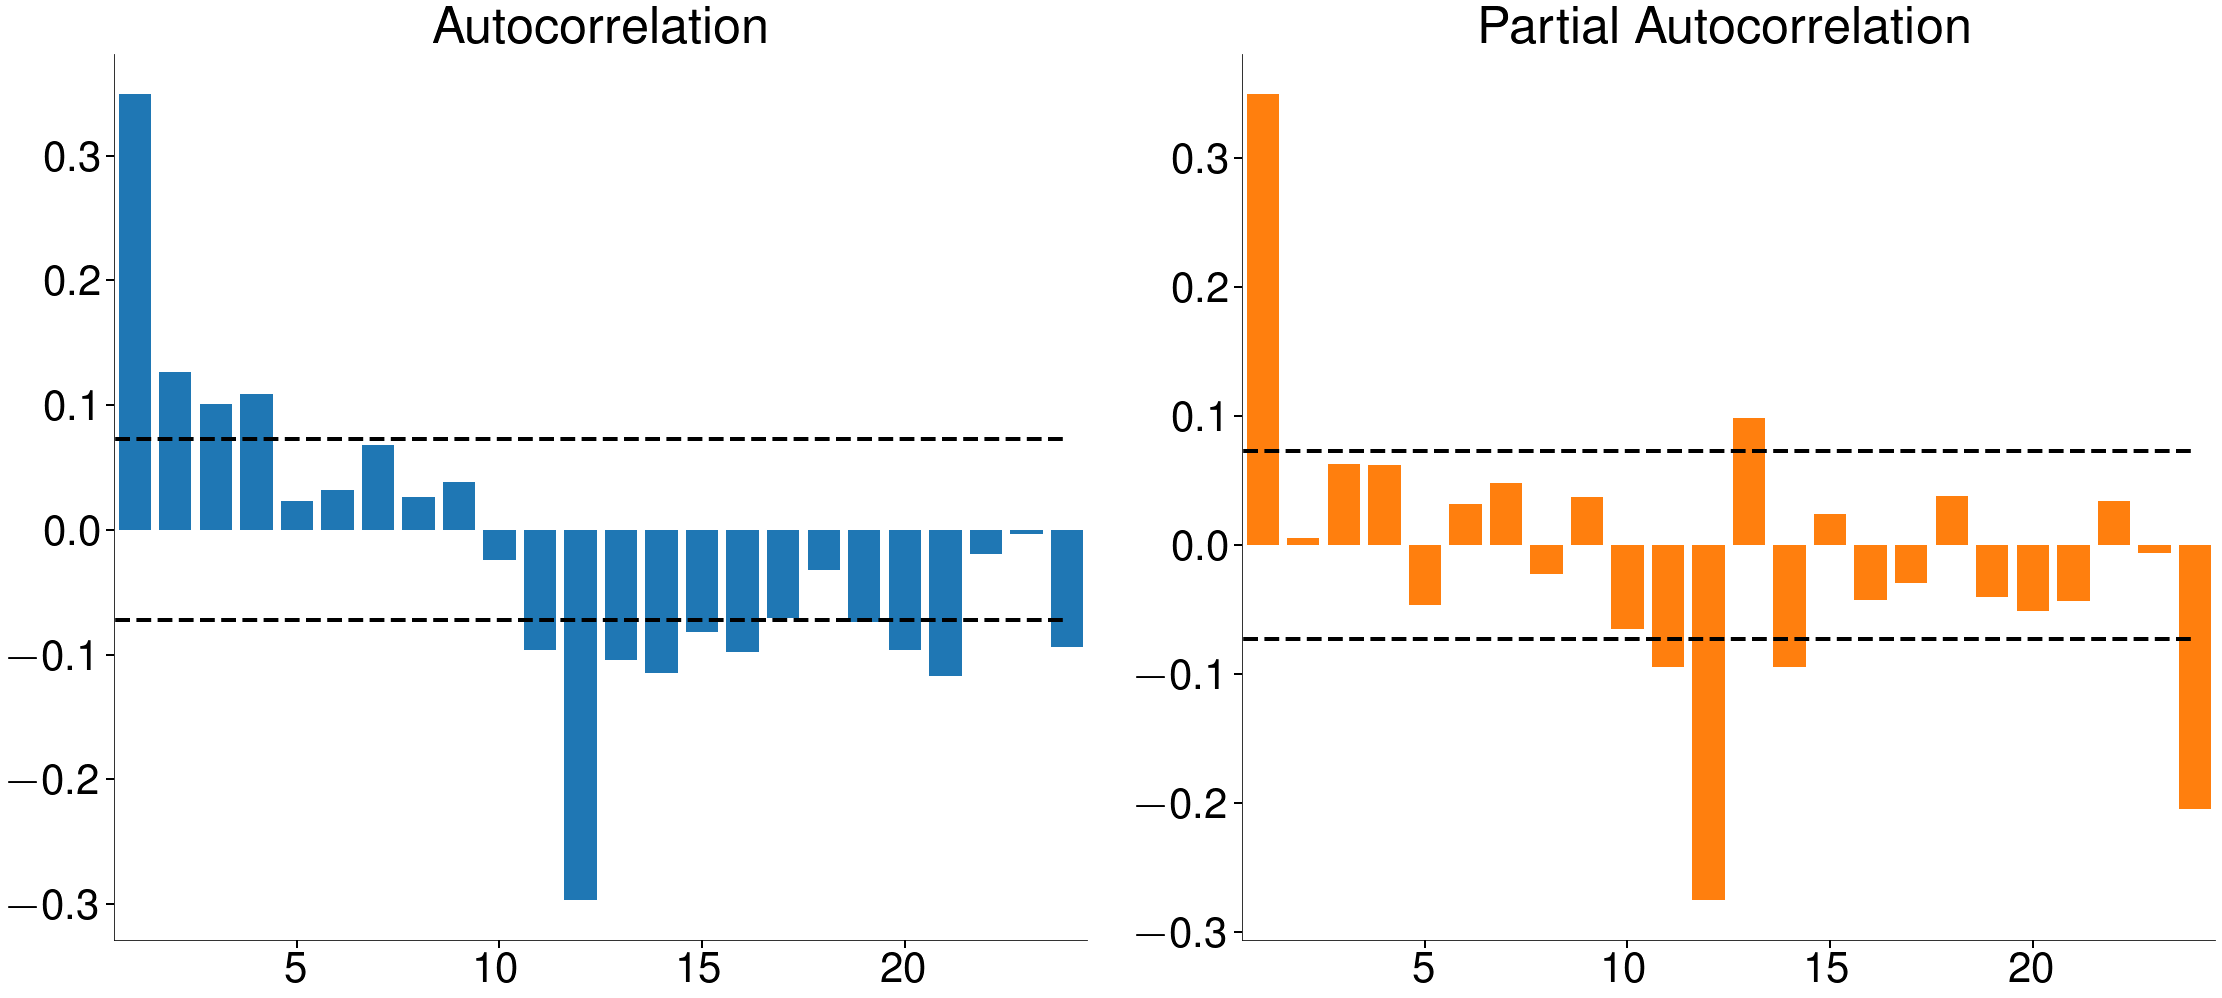

In [24]:
acf_pacf_plot(resid, 24)

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_lm
from scipy import stats


def lb_plot(x, lags, title=None):
    df = acorr_ljungbox(resid, lags, return_df=True)
    stat = df.iloc[:, 0]
    pval = df.iloc[:, 1]
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    ax[0].bar(x, stat)
    cv = stats.chi2.ppf(0.95, np.arange(1, lags + 1))
    ax[0].plot(x, cv, "k--")
    ax[1].bar(x, pval, color=mfe.colors[1])
    cv[:] = 0.05
    x[0] = 0.0
    x[-1] = lags + 1
    ax[1].plot(x, cv, "k--")
    ax[1].set_ylim(0, 1)
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("Q Stat")
    ax[1].set_title("P-value")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)


def lm_plot(x, lags, title=None):
    d = {}
    for i in range(1, lags + 1):
        stat, pval, _, _ = acorr_lm(resid, nlags=i, cov_type="HC0", autolag=None)
        pval = float(pval)
        s = pd.Series([stat, pval], index=["stat", "pval"])
        d[i] = s
    df = pd.DataFrame(d).T

    stat = df.iloc[:, 0]
    pval = df.iloc[:, 1]
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    ax[0].bar(x, stat)
    cv = stats.chi2.ppf(0.95, np.arange(1, lags + 1))
    ax[0].plot(x, cv, "k--")
    ax[1].bar(x, pval, color=mfe.colors[1])
    cv[:] = 0.05
    x[0] = 0.0
    x[-1] = lags + 1
    ax[1].plot(x, cv, "k--")
    ax[1].set_ylim(0, 1)
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("LM Stat")
    ax[1].set_title("P-value")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)

# Ljung-Box $Q$ Statistic

* Joint test of autocorrelations
* $H_{0}:\rho_{1}=\ldots=\rho_{s}=0$

$$ Q=T(T+2)\sum_{k=1}^{s}\frac{\hat{\rho}_{k}^{2}}{T-k}\sim\chi_{s}^{2} $$

* _Not_ heteroskedasticity robust


# Residual $Q$ Statistic

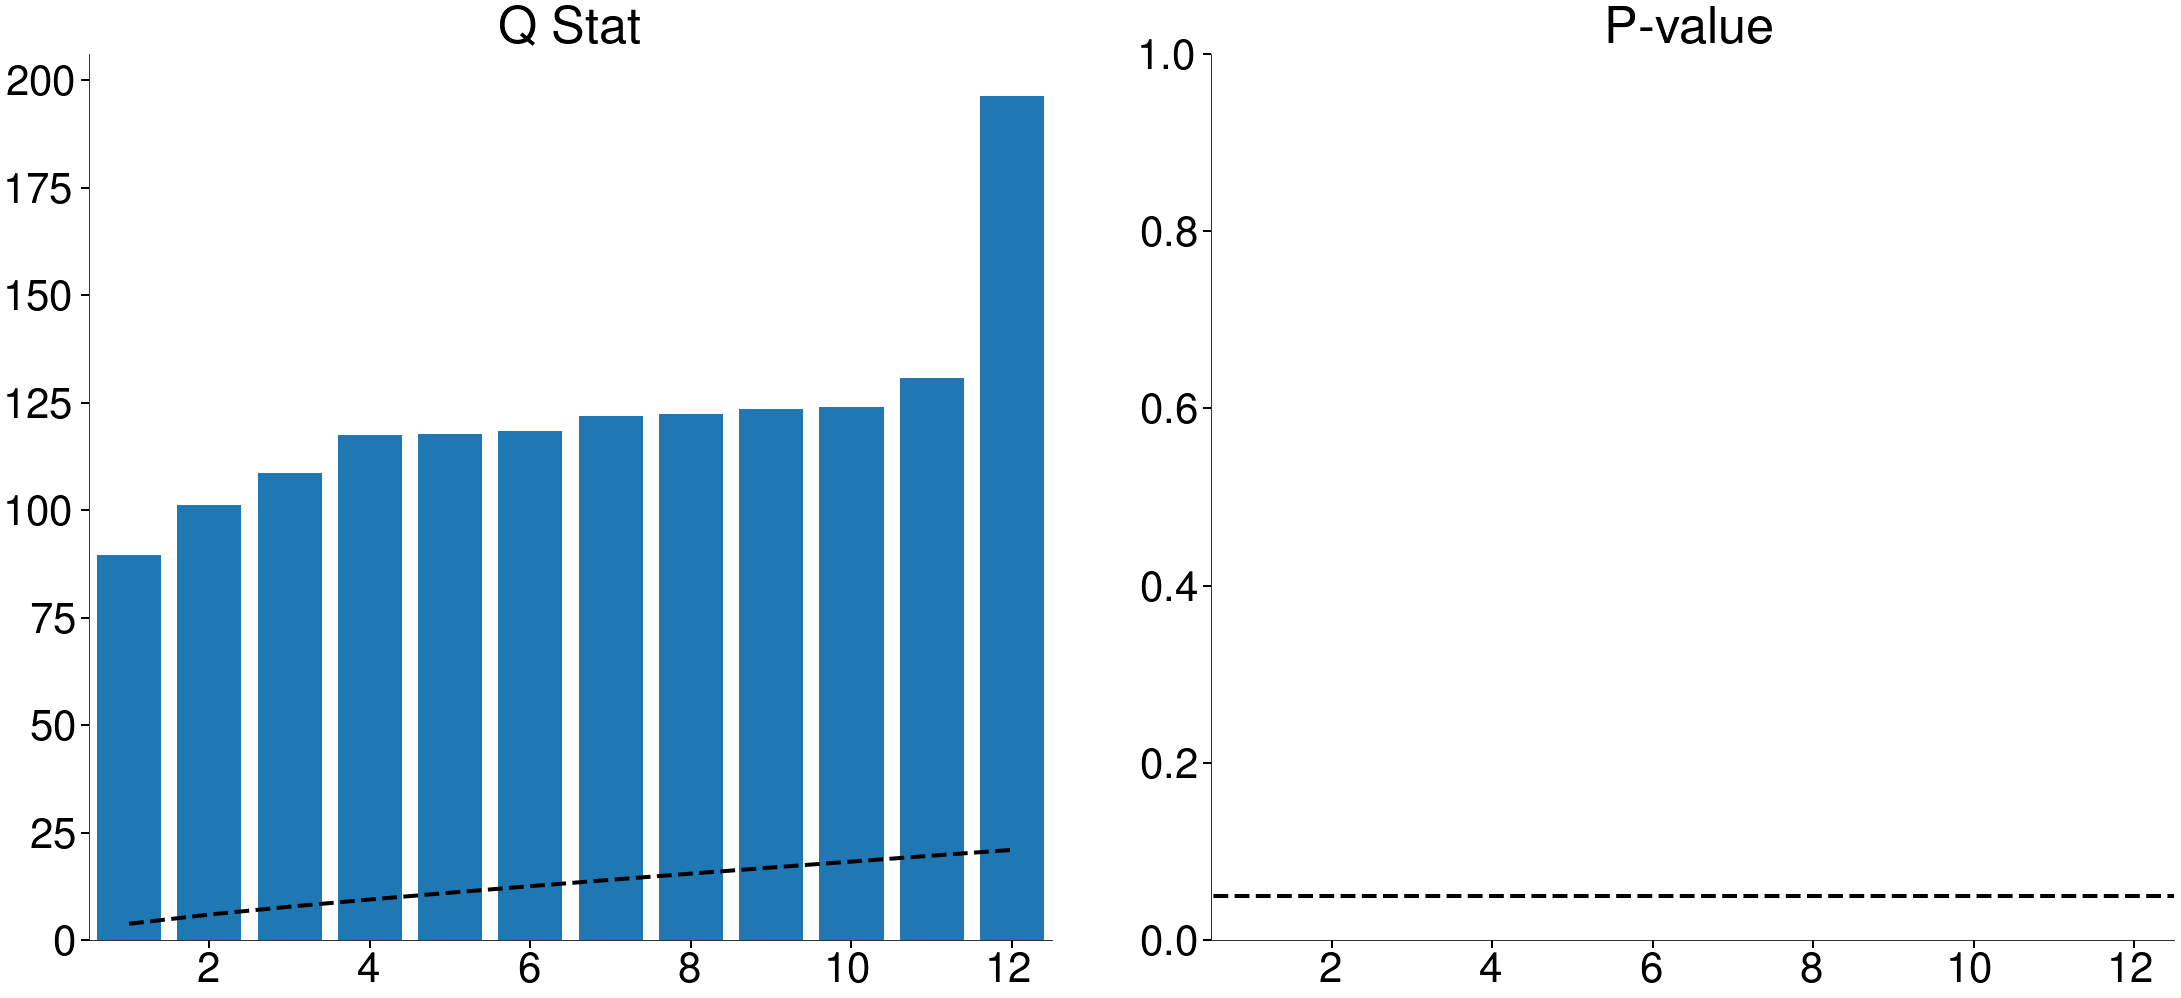

In [26]:
lb_plot(resid, 12)

# LM Test for Serial Correlation
Null $\mathrm{E}[Y_{t}^{*}Y_{t-j}^{*}]=0$ for $1\leq j\leq s$ $\Longleftrightarrow$ $\rho_j=0$

The LM-test for serial correlation is constructed by defining the score vector $\mathbf{s}_{t}=Y_{t}^{*}\left[Y_{t-1}^{*}\,Y_{t-2}^{*}\,\ldots Y_{t-s}^{*}\right]'$

$$ LM=T\bar{\mathbf{s}}'\hat{\mathbf{S}}^{-1}\bar{\mathbf{s}}\stackrel{d}{\rightarrow}\chi_{s}^{2} $$

* $\bar{\mathbf{s}}=T^{-1}\sum_{t=1}^{T}\mathbf{s}_{t}$
* $\hat{\mathbf{S}}=T^{-1}\sum_{t=1}^{T}\mathbf{s}_{t}\mathbf{s}_{t}'$
* $Y_{t}^{*}=Y_{t}-T^{-1}\sum_{t=1}^{T}Y_{t}$
* _Heteroskedasticity robust_

# LM Stat and P-value

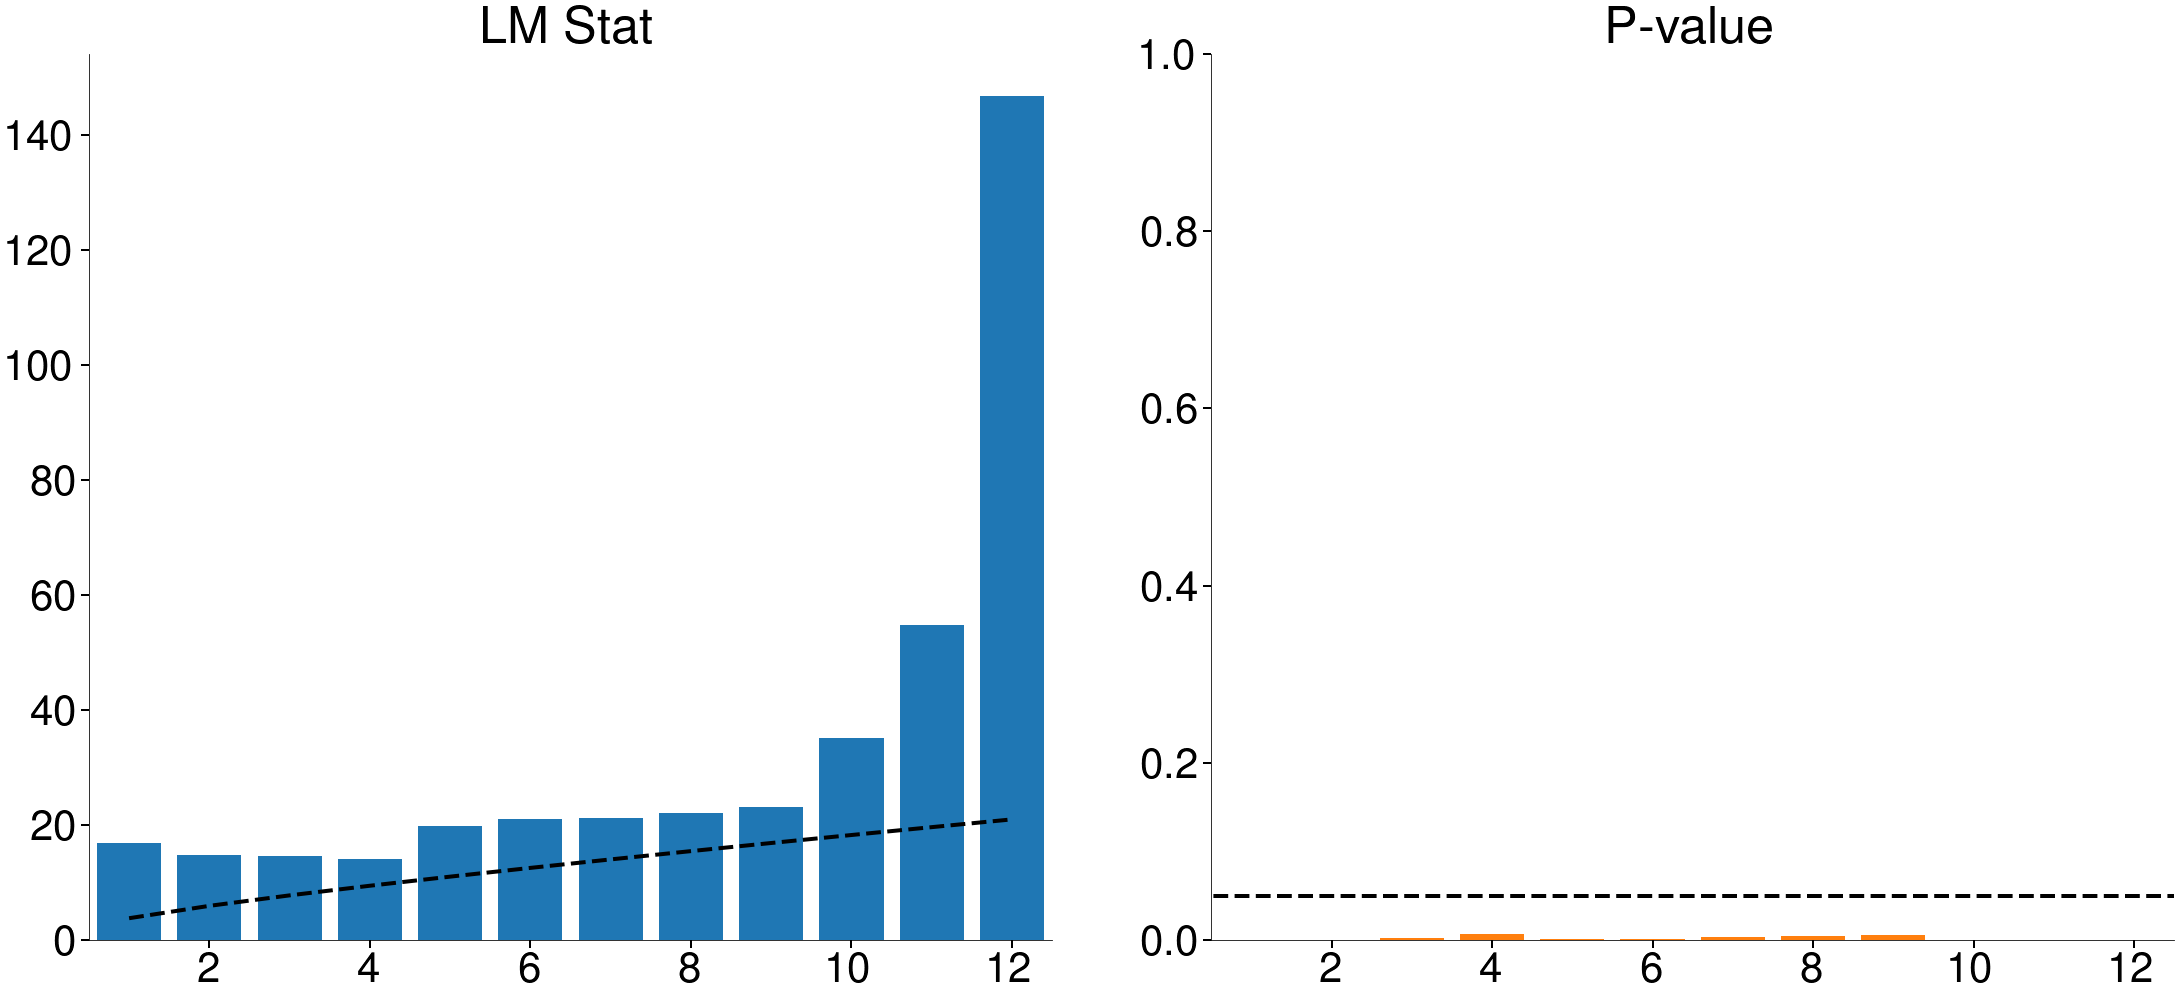

In [27]:
lm_plot(resid, 12)

# Improving the Model

In [28]:
mod = SARIMAX(indpro, order=(2, 0, 0), trend="c")
res = mod.fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.1106,0.045,2.453,0.014,0.022,0.199
ar.L1,1.3187,0.017,79.114,0.000,1.286,1.351
ar.L2,-0.3643,0.018,-20.624,0.000,-0.399,-0.330
sigma2,1.3635,0.028,48.775,0.000,1.309,1.418


# Characteristic Roots

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} +\epsilon_t $$
* Characteristic Equation
$$ z^2 - \phi_1 z - \phi_0 = 0 $$
* Characteristic Roots
$$ (z-c_1)(z-c_2)=0 $$

_Note_: We will formalize testing for **unit roots** later

In [29]:
poly = np.array([1, -res.params["ar.L1"], -res.params["ar.L2"]])
poly

array([ 1.        , -1.31873208,  0.3642808 ])

In [30]:
np.roots(poly)

array([0.92485196, 0.39388012])

# AR(2) Residuals

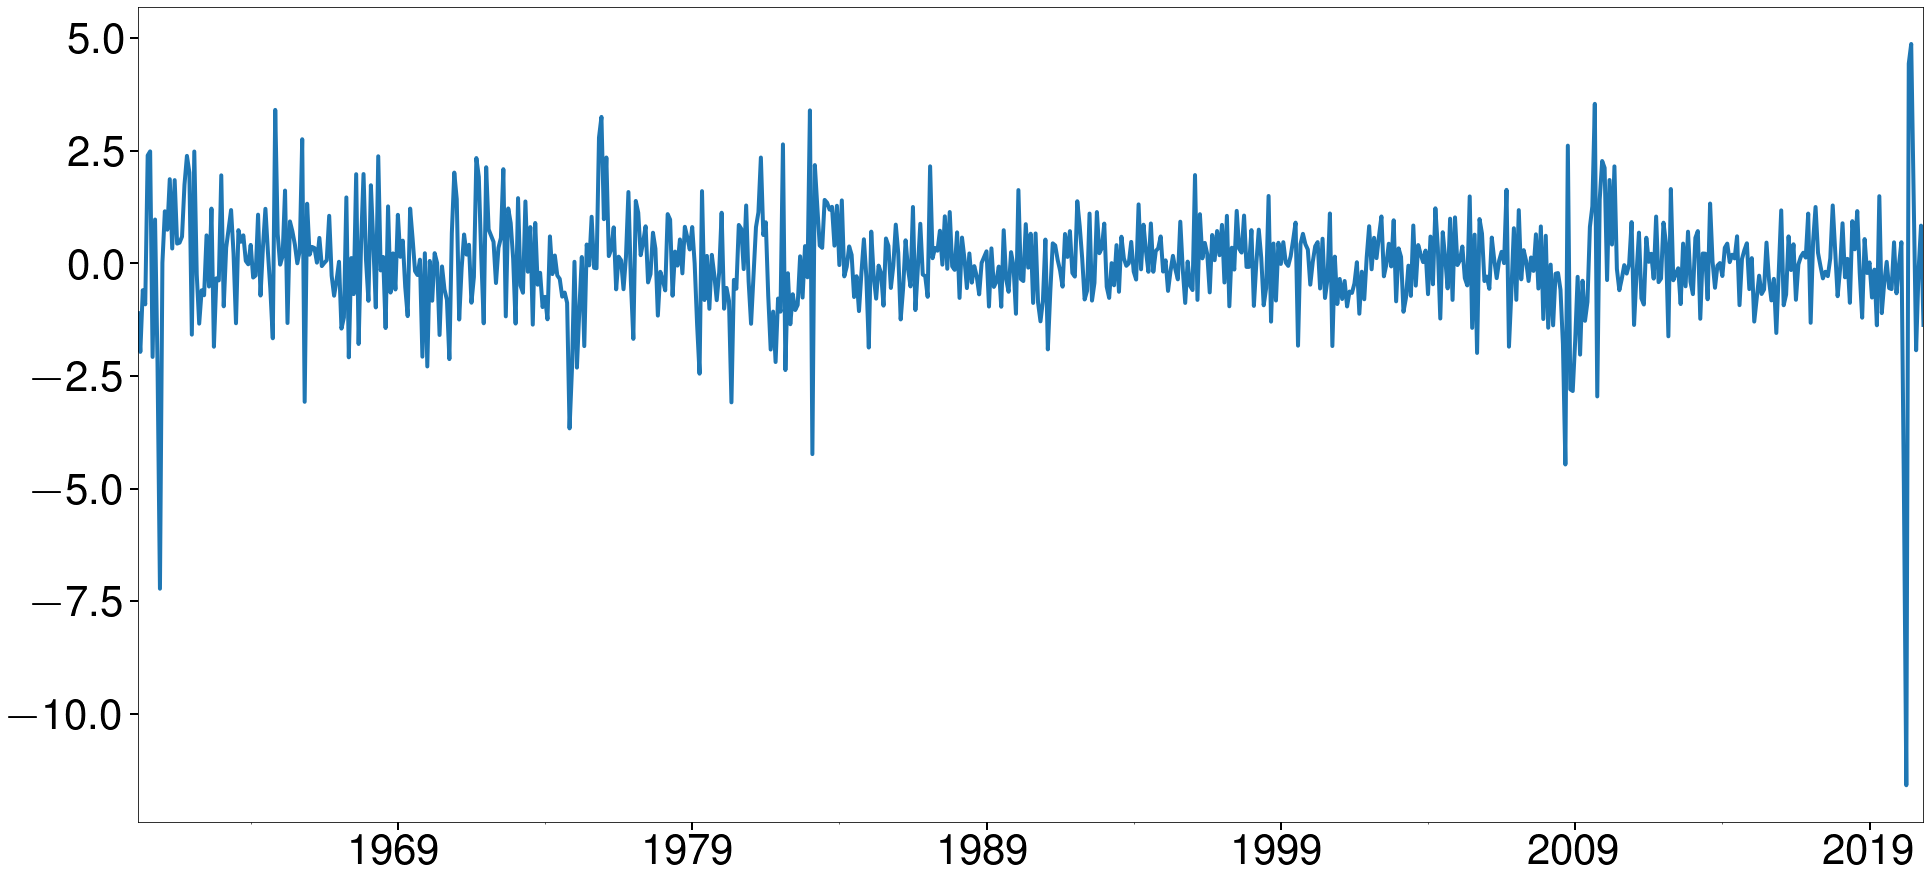

In [31]:
resid = res.resid.iloc[2:]
_ = resid.plot()

# AR(2) Residual Autocorrelation

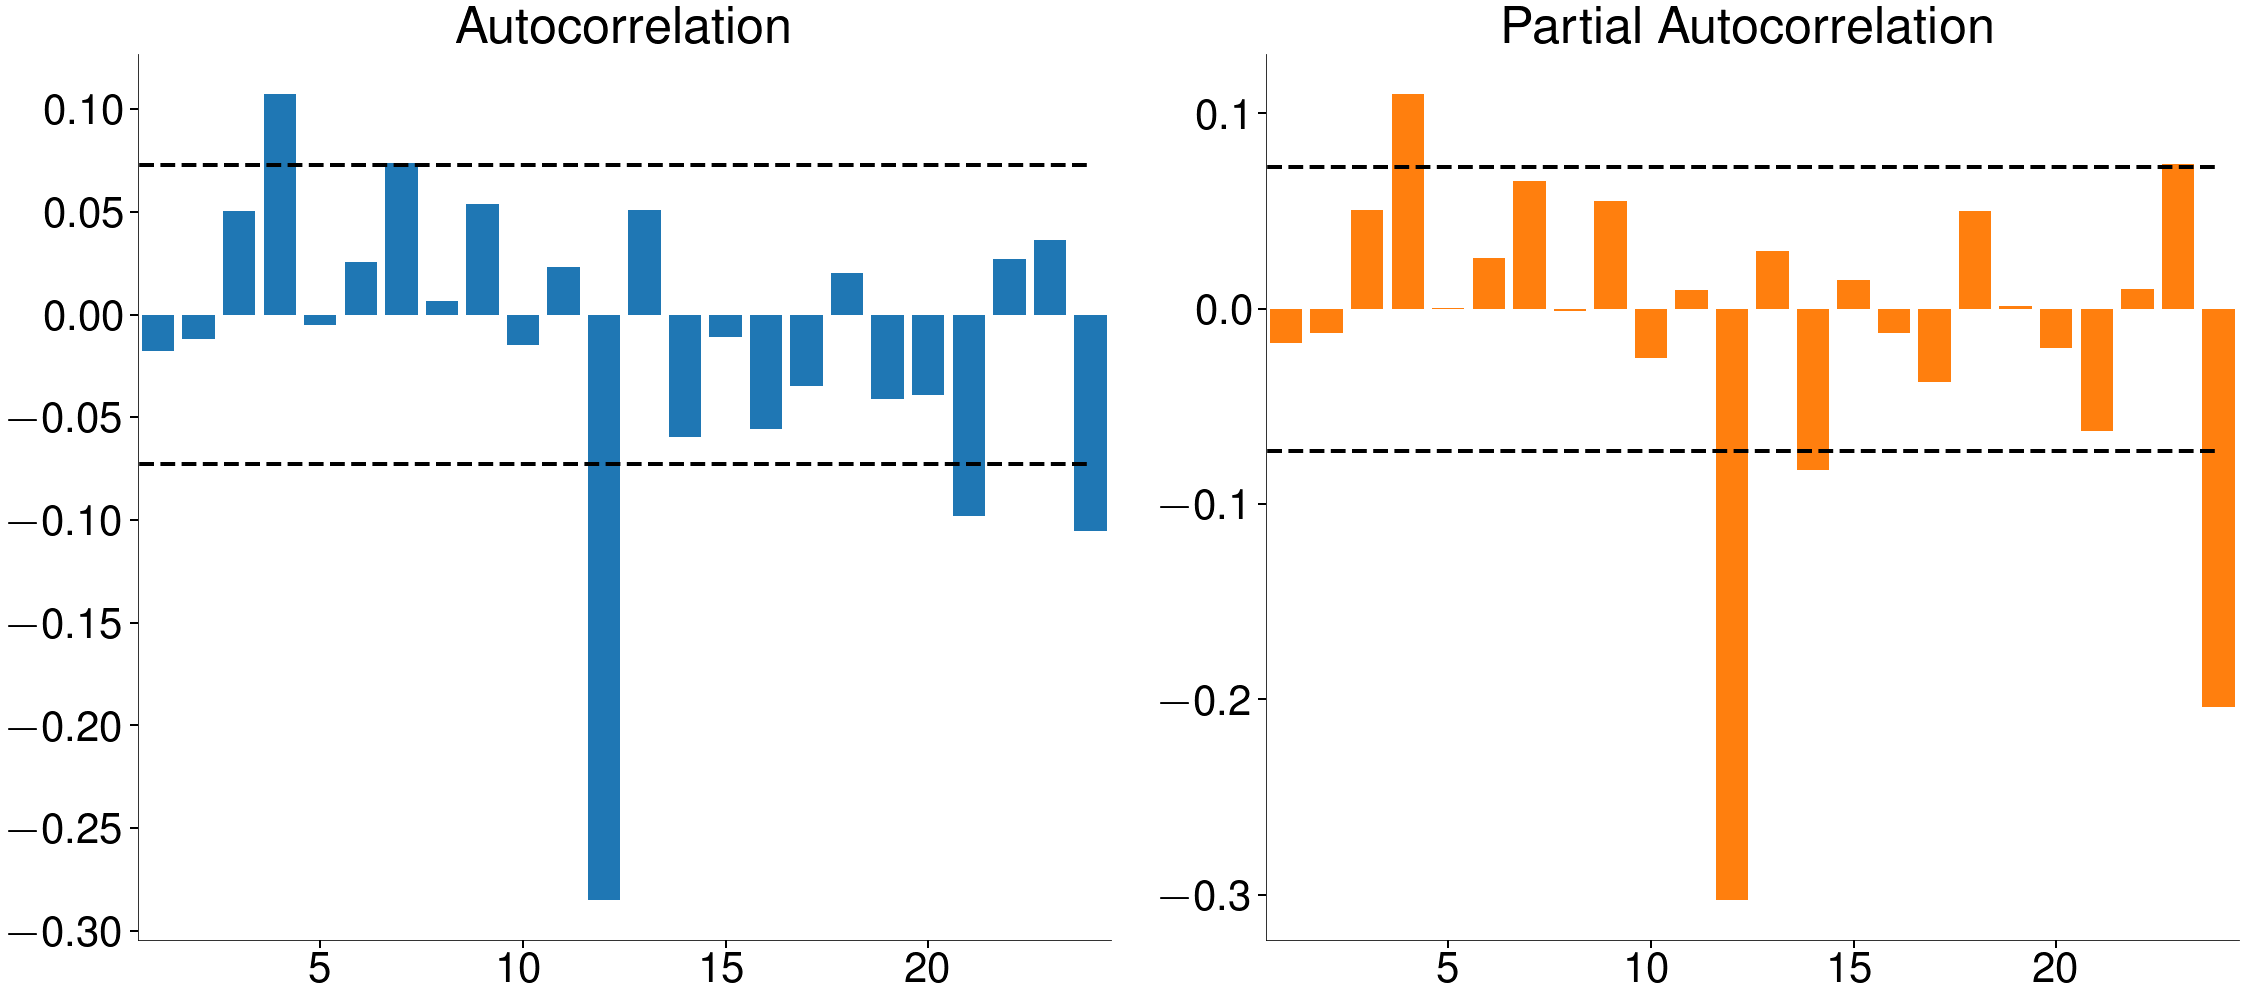

In [32]:
acf_pacf_plot(resid, 24)

# AR(2) $Q$ stat

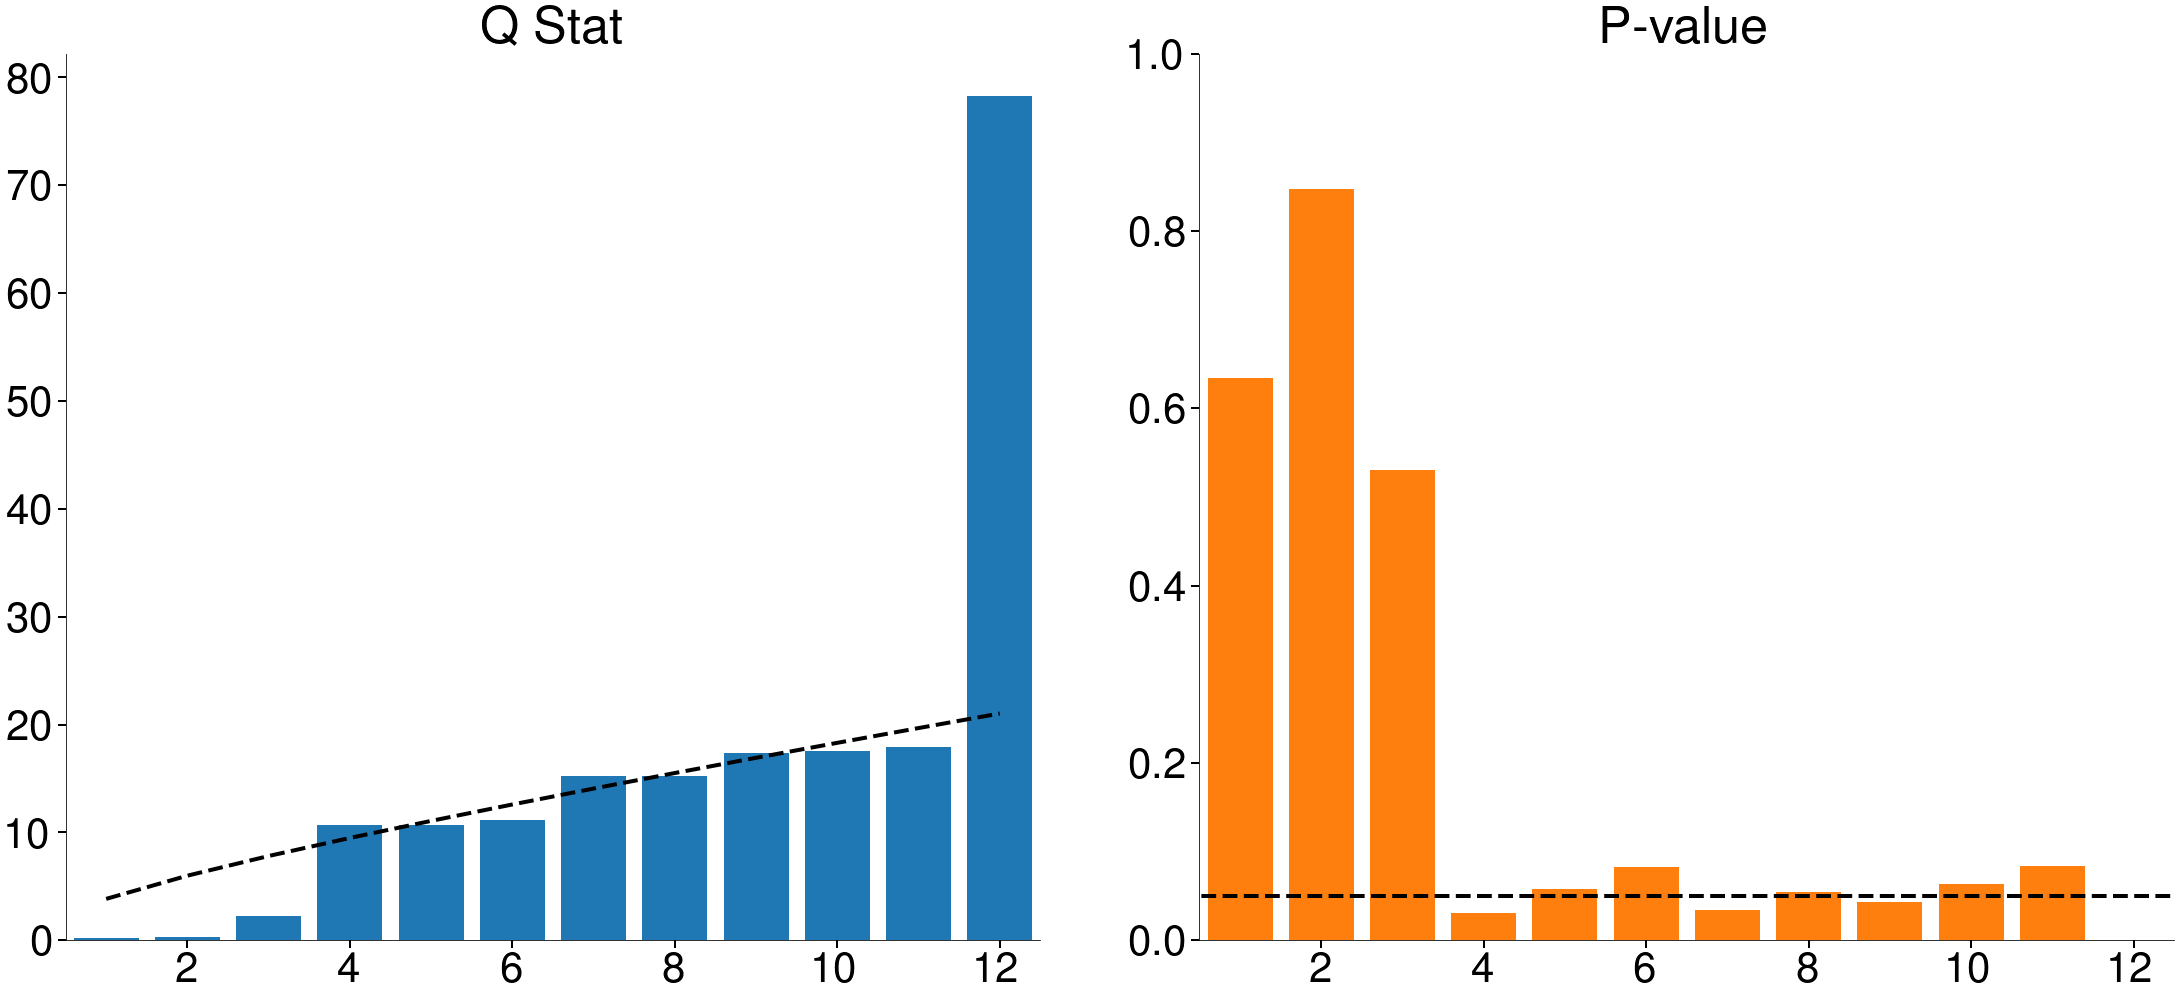

In [33]:
lb_plot(resid, 12)

In [34]:
import warnings

mod = SARIMAX(uscons, order=(0, 0, 1), trend="c")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res_ma1 = mod.fit()

# Modeling US Construction Worker Growth Rate

* Sample AC and PAC indicate an MA is needed

In [35]:
summary(res_ma1)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,2.063e-06,3.57e-05,0.058,0.954,-6.79e-05,7.21e-05
ma.L1,-0.9334,0.009,-102.611,0.000,-0.951,-0.916
sigma2,0.0001,1.33e-06,86.853,0.000,0.000,0.000


In [36]:
import warnings

mod = SARIMAX(uscons, order=(0, 0, 2), trend="c")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res_ma2 = mod.fit()

# MA(2)

In [37]:
summary(res_ma2)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,8.191e-07,2.68e-05,0.031,0.976,-5.18e-05,5.34e-05
ma.L1,-1.0244,0.012,-88.805,0.000,-1.047,-1.002
ma.L2,0.0777,0.014,5.392,0.000,0.049,0.106
sigma2,0.0001,1.16e-06,91.835,0.000,0.000,0.000


# MA(3)

In [38]:
import warnings

mod = SARIMAX(uscons, order=(0, 0, 3), trend="c")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res_ma3 = mod.fit()

In [39]:
summary(res_ma3)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,4.276e-06,8.31e-05,0.051,0.959,-0.000,0.000
ma.L1,-1.0516,0.012,-85.452,0.000,-1.076,-1.027
ma.L2,0.1228,0.021,5.933,0.000,0.082,0.163
ma.L3,0.0982,0.022,4.381,0.000,0.054,0.142
sigma2,0.0001,1.21e-06,88.482,0.000,0.000,0.000


# MA(3) Residual Analysis

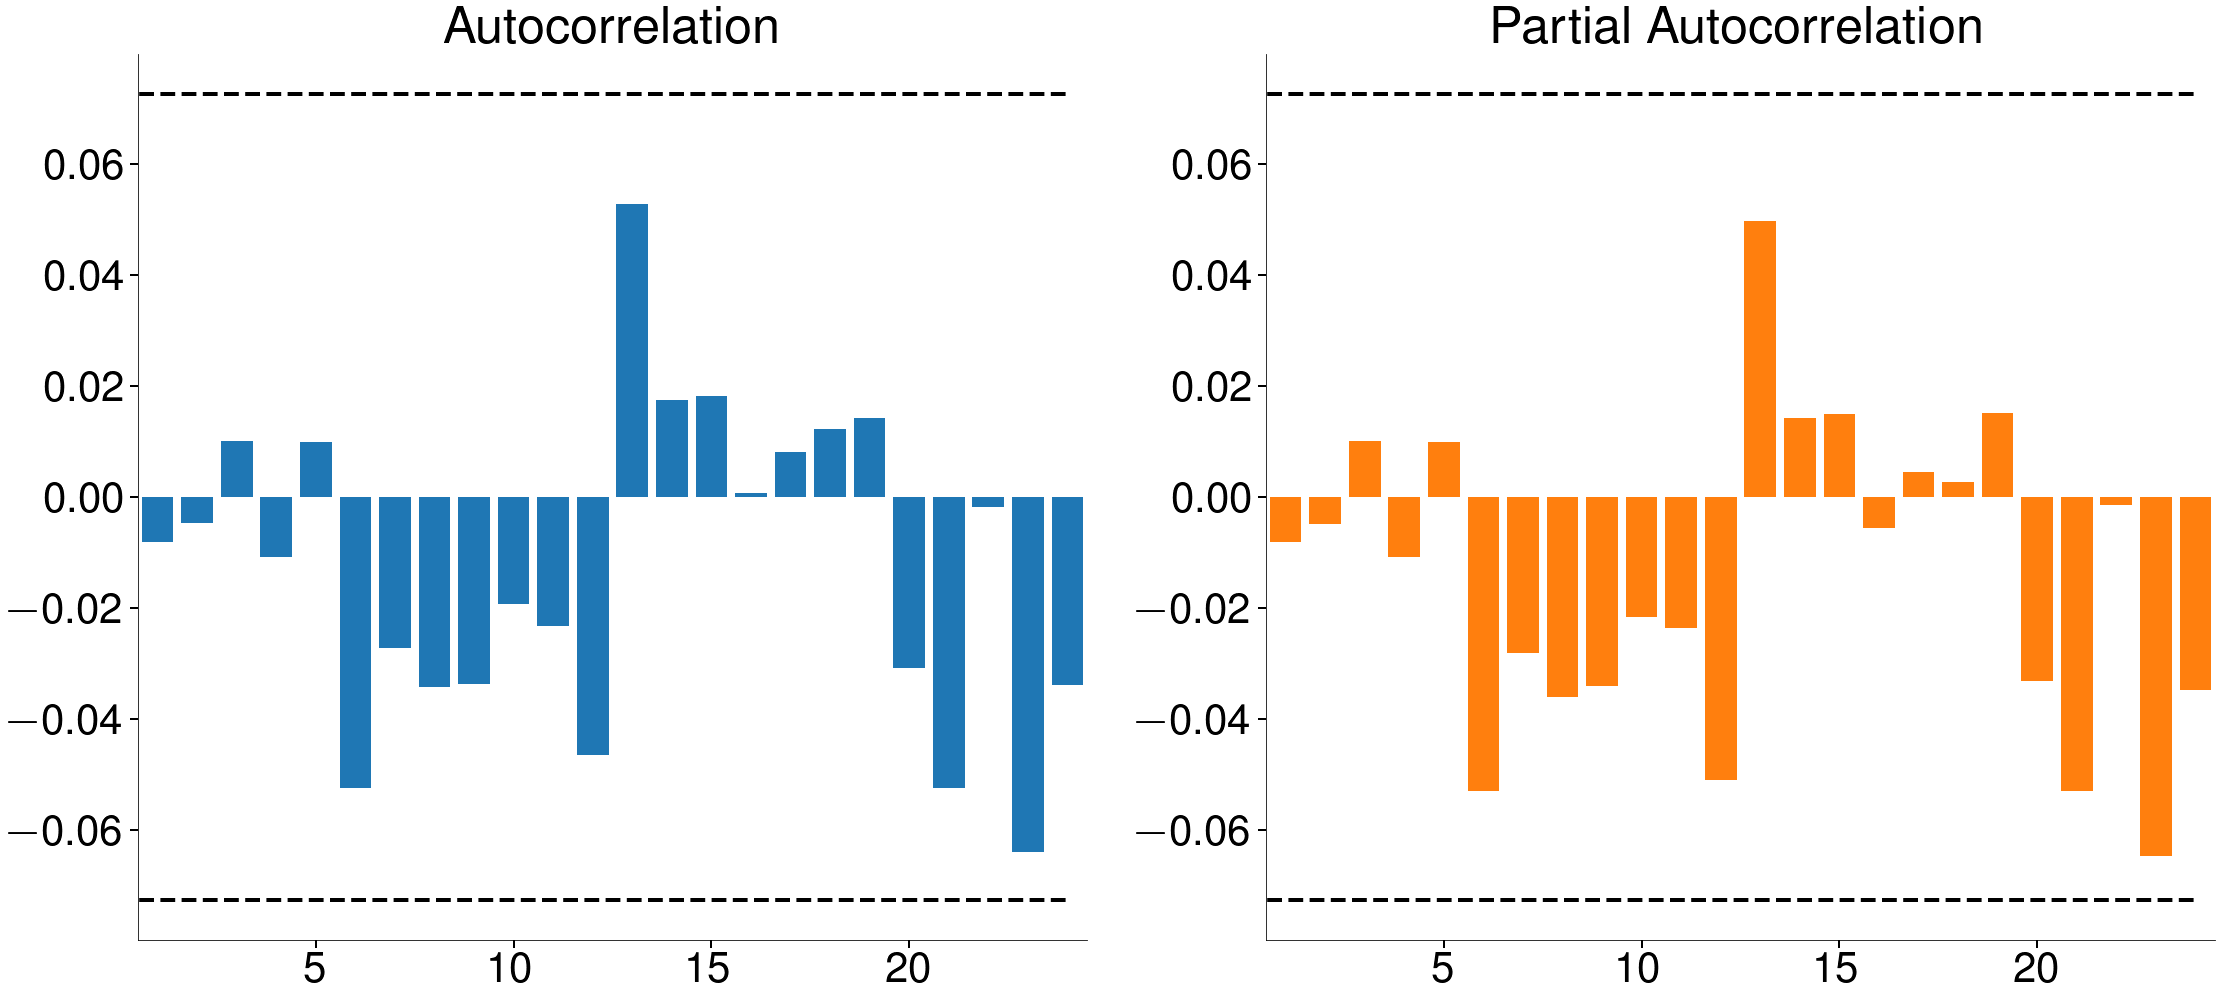

In [40]:
resid = res_ma3.resid.iloc[3:]
acf_pacf_plot(resid, 24)

# MA(3) Ljung-Box $Q$ Statistic

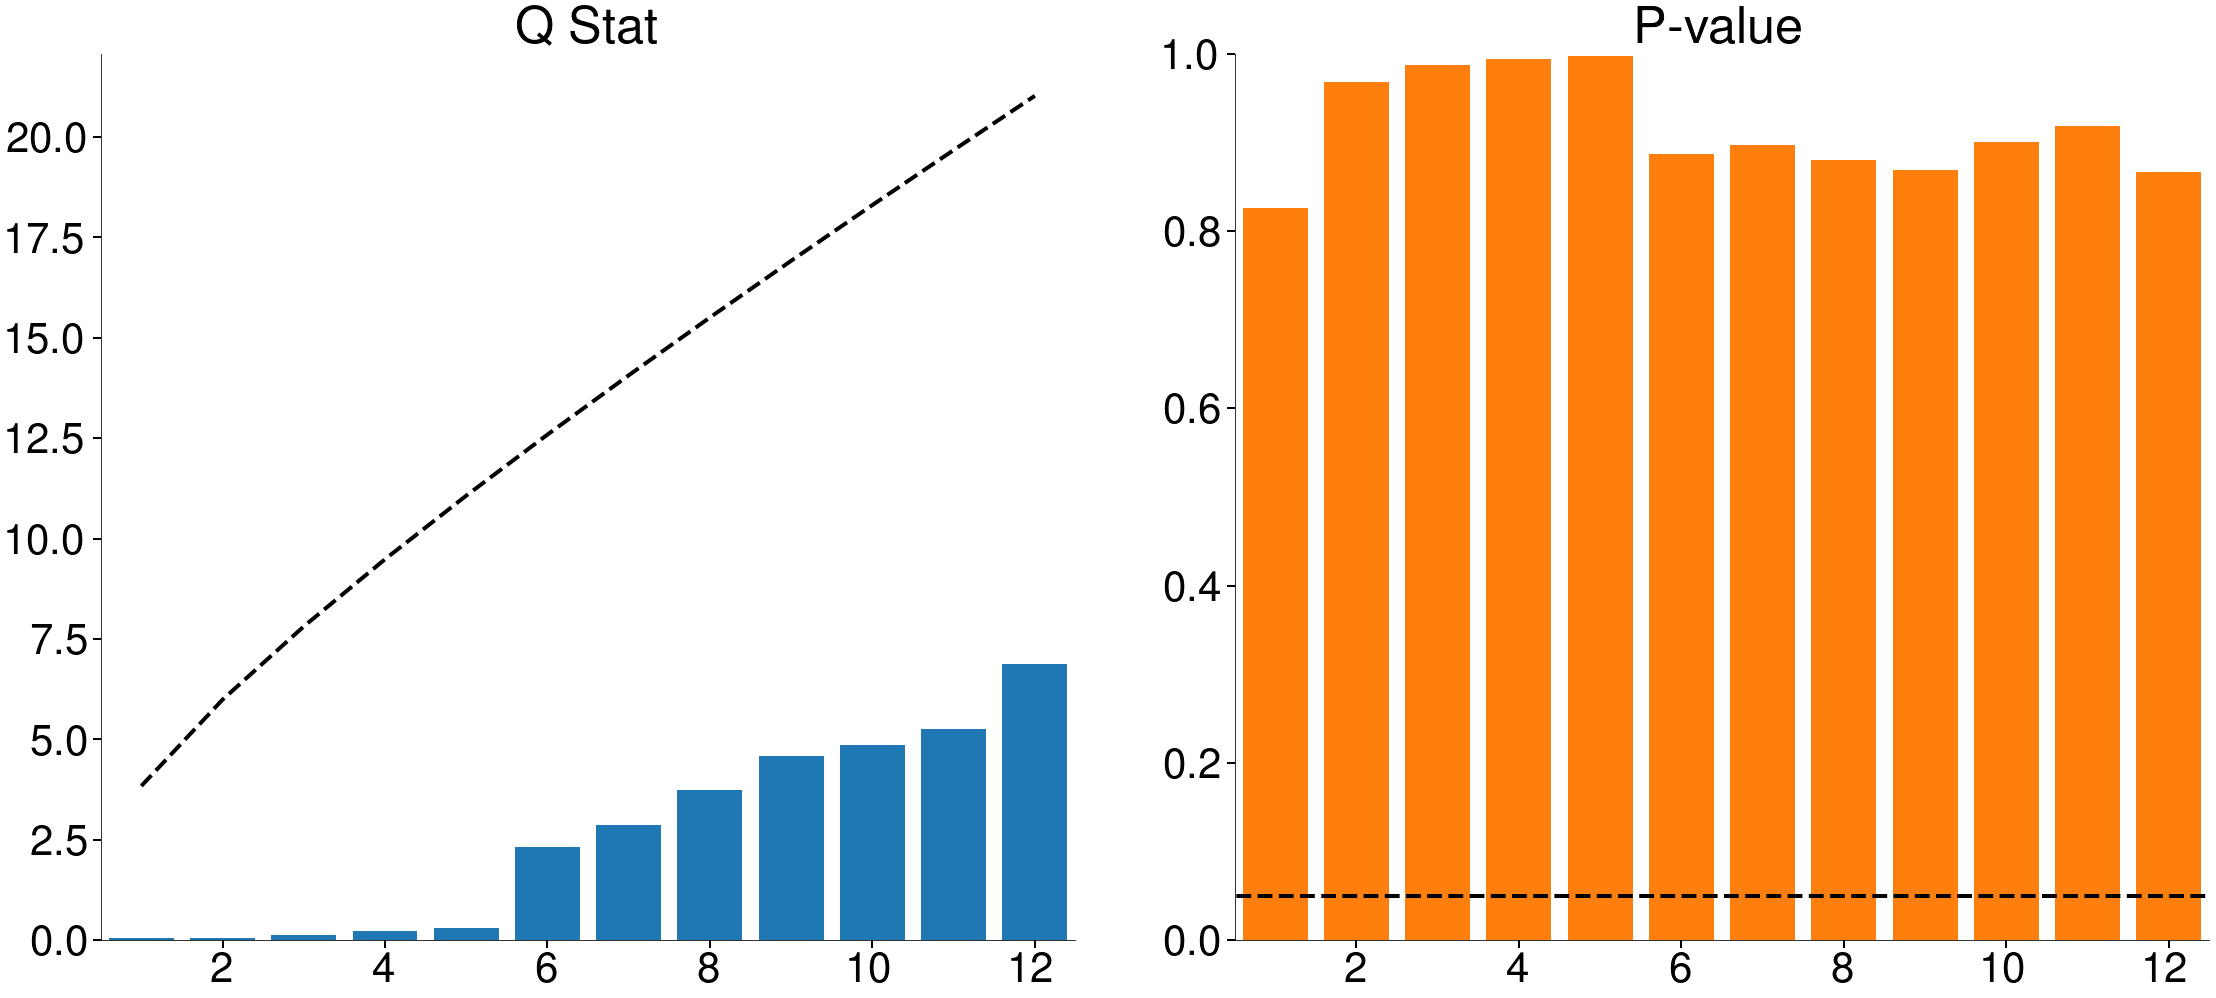

In [41]:
lb_plot(resid, 12)

# MA(1) Residual Analysis

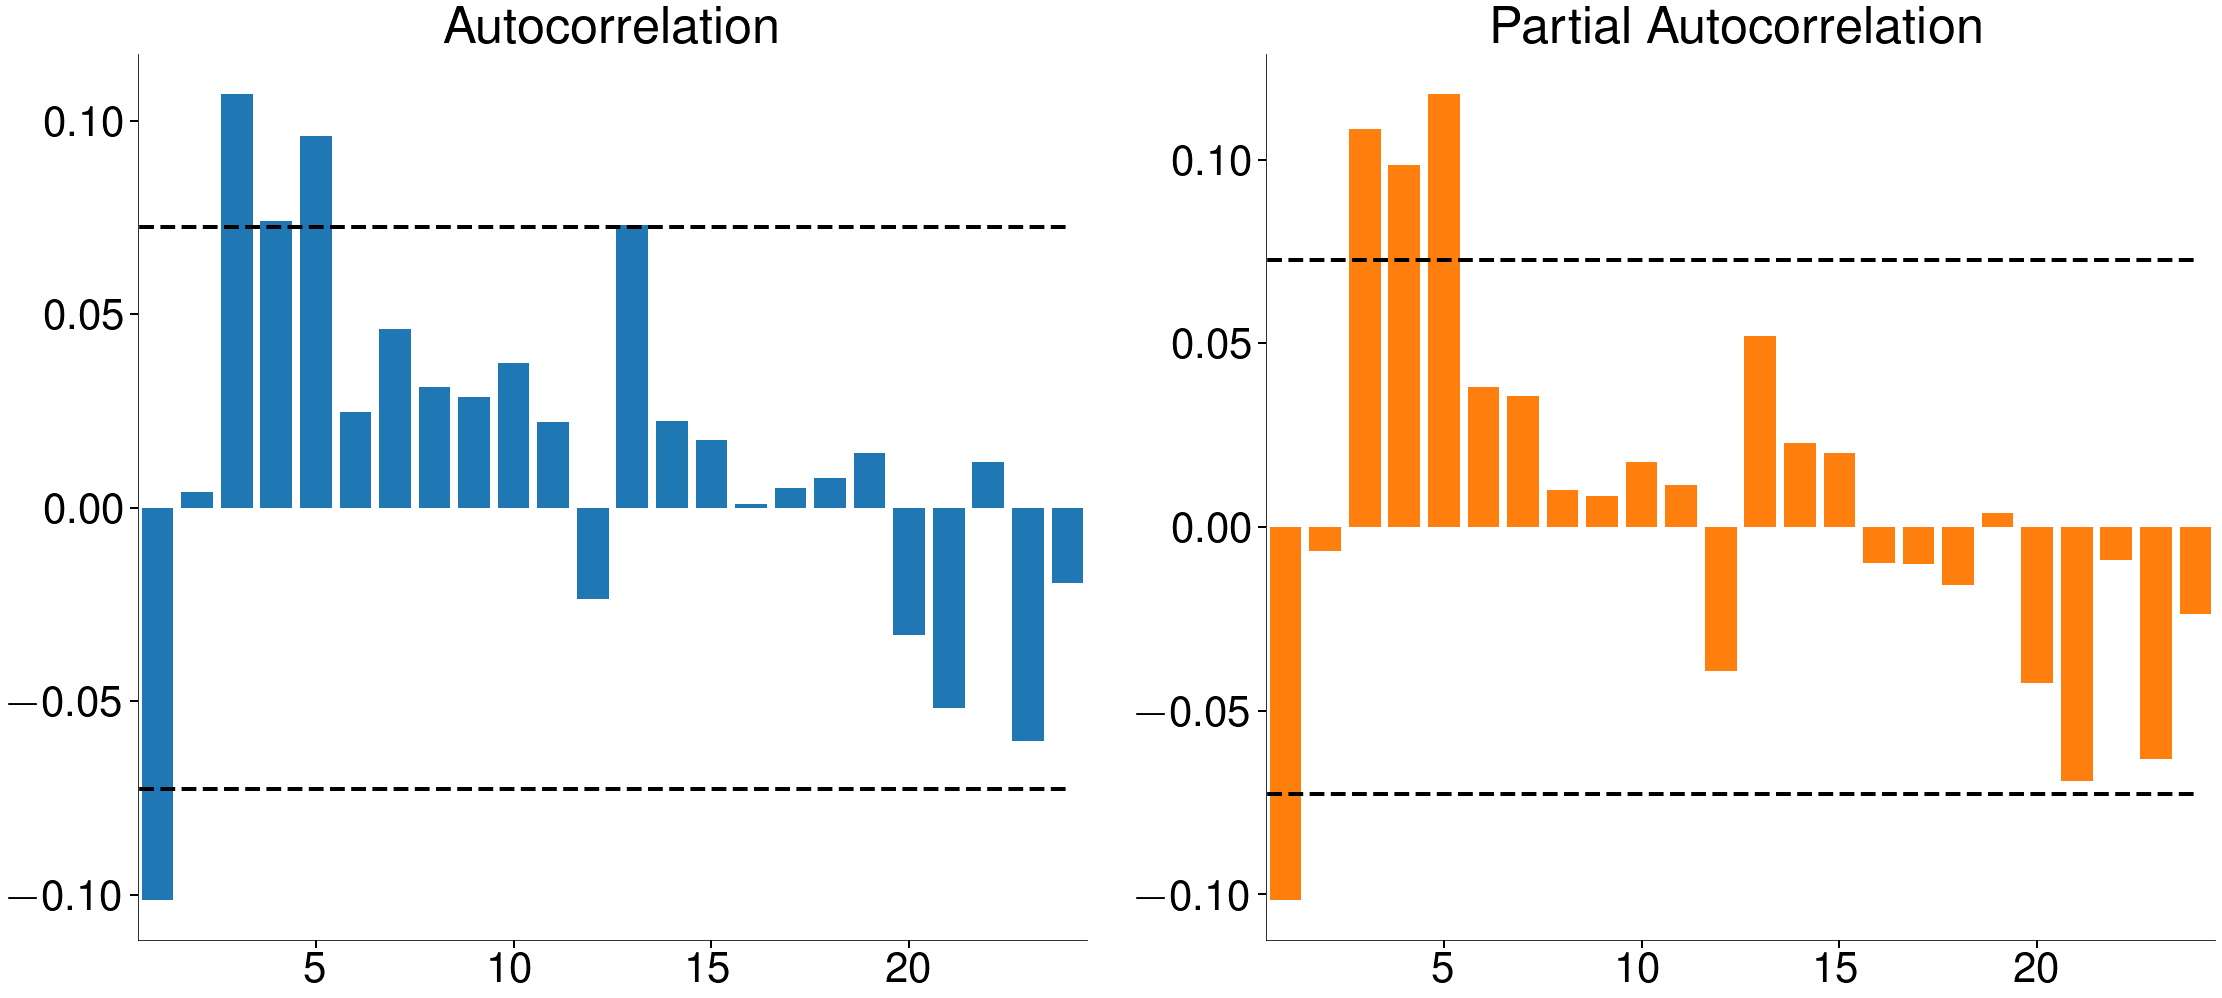

In [42]:
resid = res_ma1.resid.iloc[3:]
acf_pacf_plot(resid, 24)

# MA(1) $Q$ Statistic

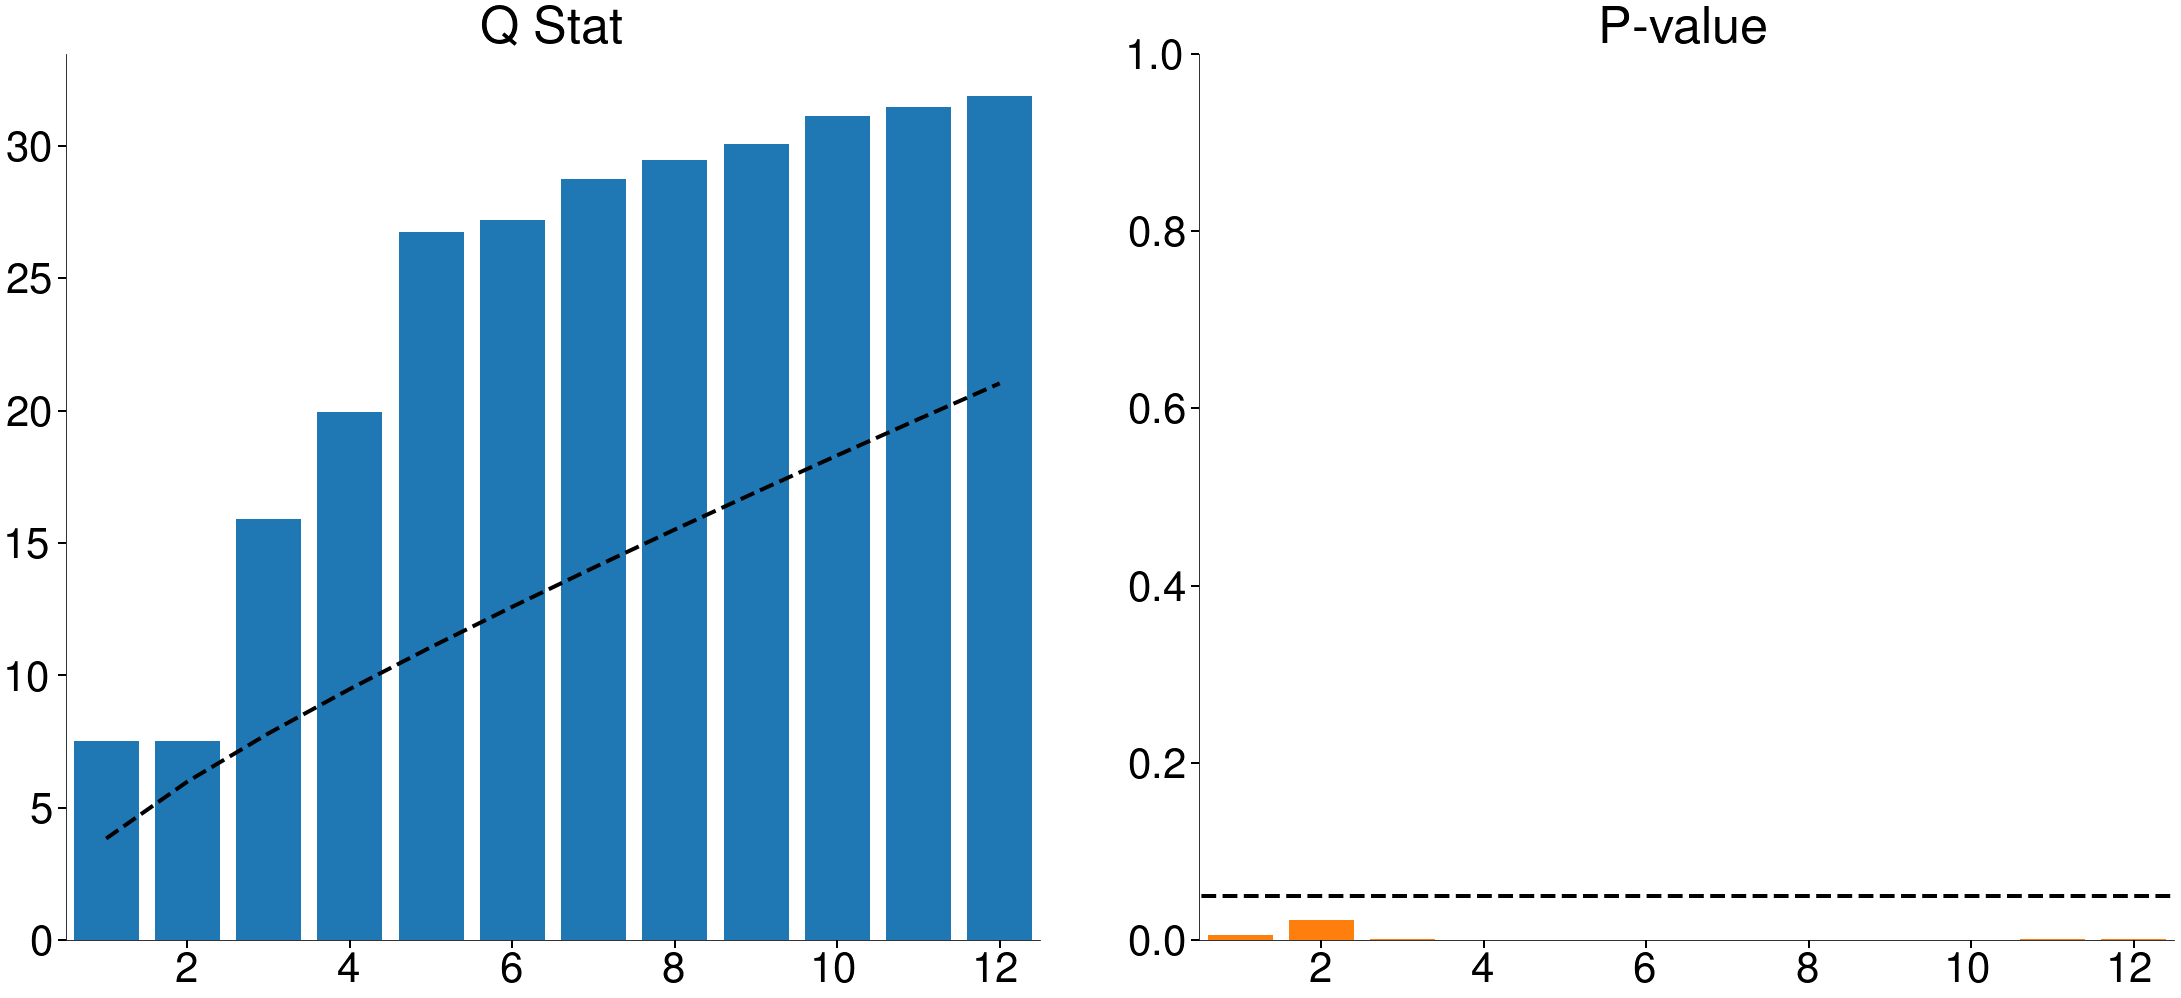

In [43]:
lb_plot(resid, 12)

# Correct Specification Benchmark AR(2)

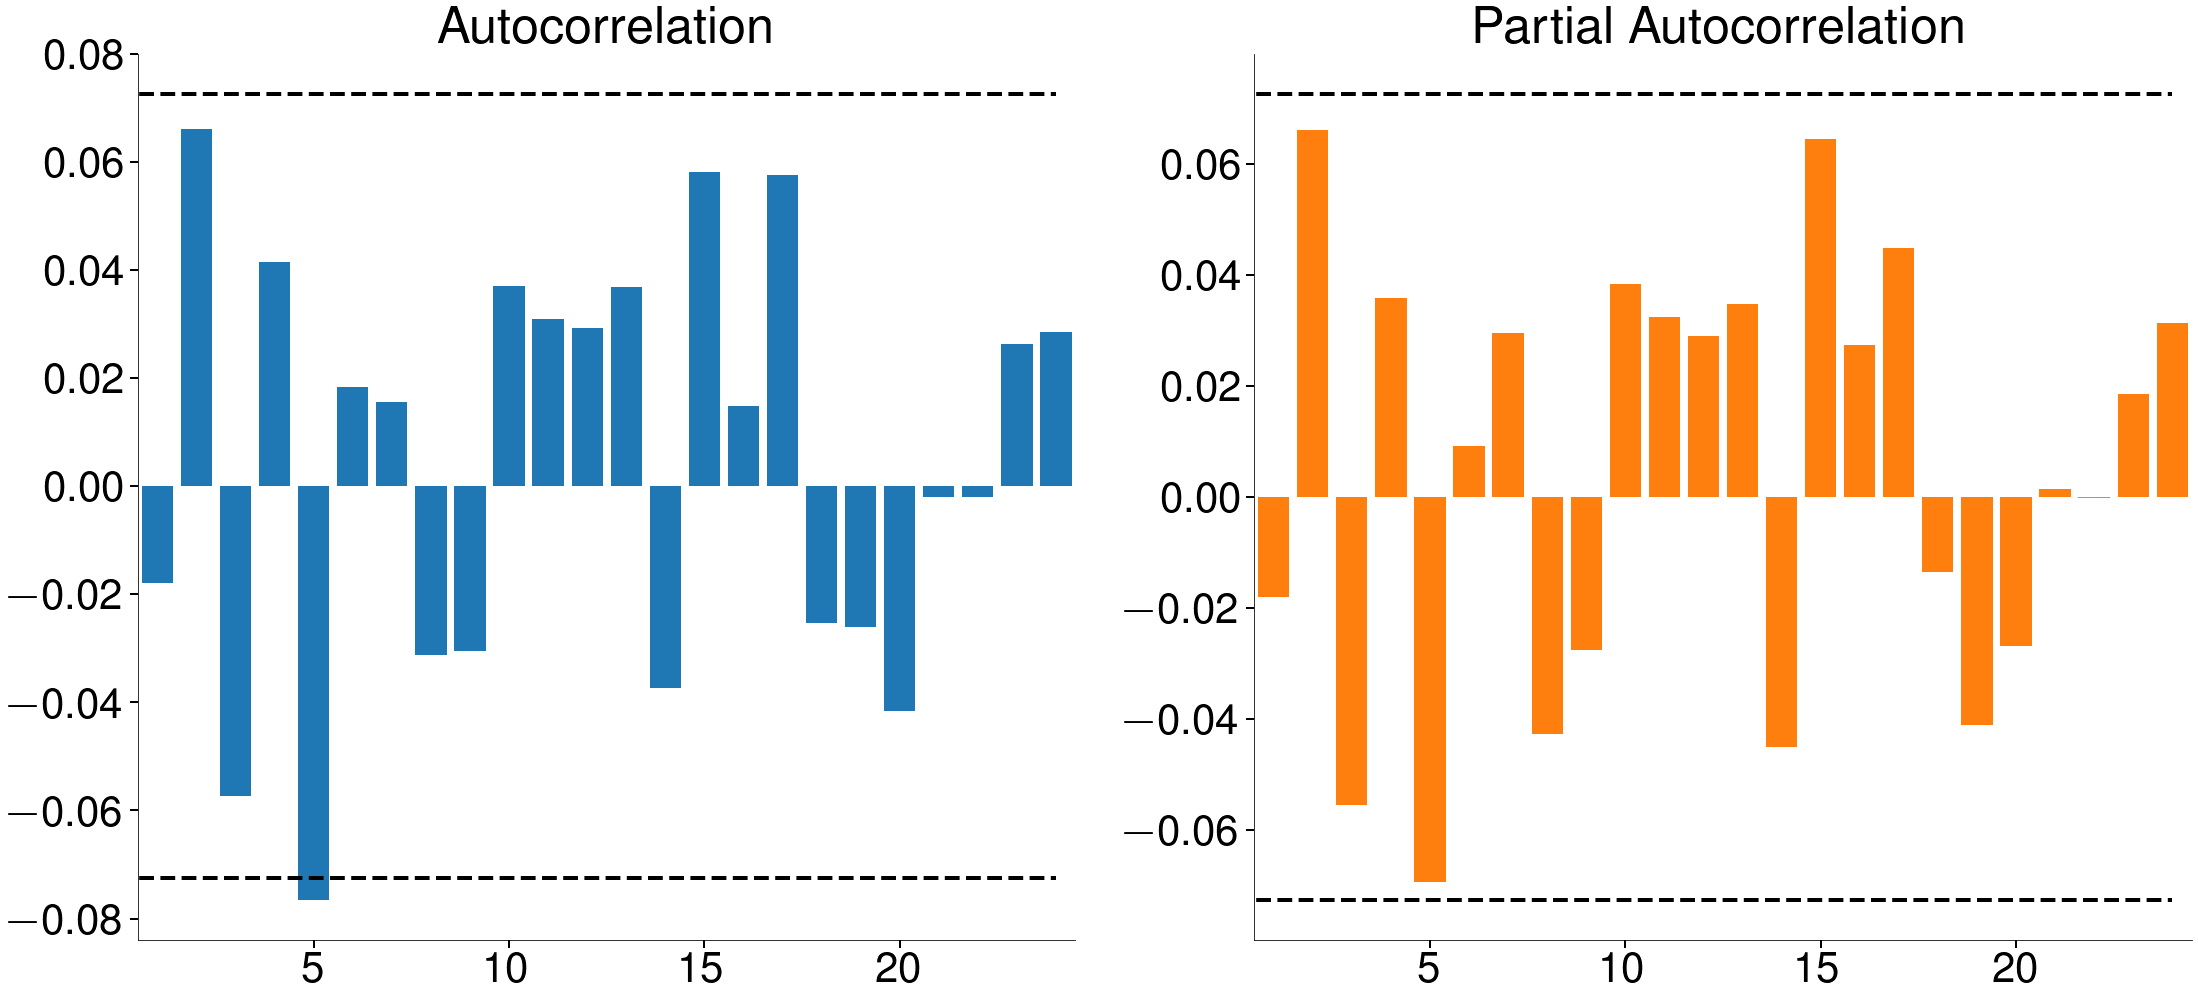

In [44]:
res = SARIMAX(sim, order=(2, 0, 0), trend="c").fit()
resid = res.resid.iloc[2:]
acf_pacf_plot(resid, 24)

# LB $Q$ Stat on AR(2)

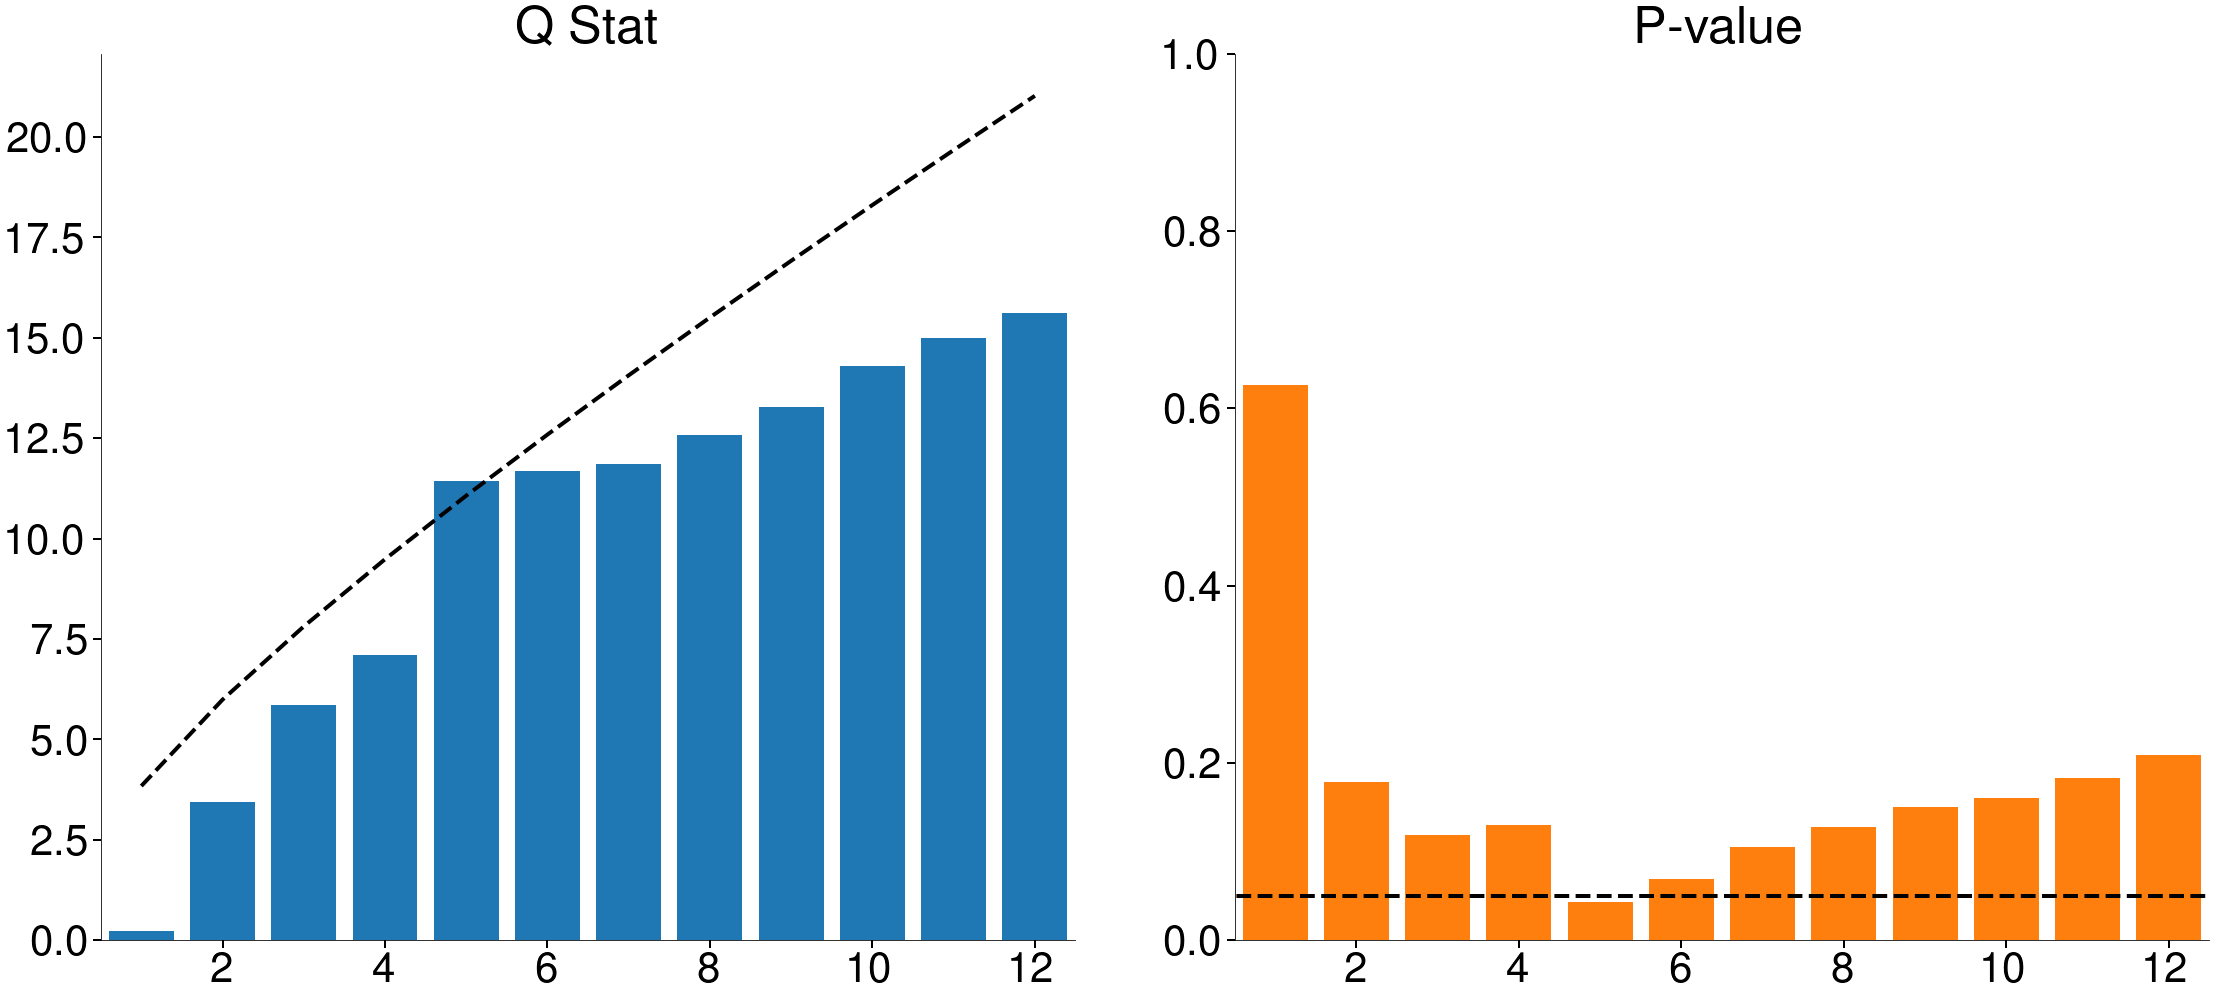

In [45]:
lb_plot(resid, 12)

In [46]:
from statsmodels.tsa.arima.model import ARIMA

if False:
    retain = {}
    orders = ((1, 0, 0), (2, 0, 0), (1, 0, 1), (0, 0, 2), (0, 0, 1), (3, 0, 0))
    import warnings

    all_ics = {}
    for col in combined:
        print(col)
        ics = {}
        seasonal_order = (0, 0, 0, 0)  # if col != "HOUSTNSA" else (0,1,0,12)
        for p in (0, 1, 2, 3, 4):
            for q in (0, 1, 2, 3, 4):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    res = SARIMAX(
                        combined[col].dropna(),
                        order=(p, 0, q),
                        trend="c",
                        seasonal_order=seasonal_order,
                    ).fit()
                ics[(p, q)] = pd.Series([res.aic, res.bic], index=["aic", "bic"])
        all_ics[col] = pd.DataFrame(ics).T
        print(col, all_ics[col].aic.idxmin(), all_ics[col].bic.idxmin())

    all_ics

# StG Model Building

* Add either AR or MA
* Increase model complexity when statistically different using test size $\alpha \leq 5\%$
* Stop when no excluded lag is significant

# Initial Models

In [47]:
summary(SARIMAX(default, order=(1, 0, 0), trend="c").fit())
summary(SARIMAX(default, order=(0, 0, 1), trend="c").fit())

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,3.4827,1.205,2.891,0.004,1.122,5.844
ar.L1,0.9652,0.007,139.901,0.000,0.952,0.979
sigma2,126.9150,2.638,48.103,0.000,121.744,132.086


,coef,std err,z,P>|z|,[0.025,0.975]
intercept,101.2112,2.446,41.378,0.000,96.417,106.005
ma.L1,0.9218,0.008,118.011,0.000,0.906,0.937
sigma2,586.9873,22.526,26.059,0.000,542.838,631.137


# Extending the AR(1)

In [48]:
summary(SARIMAX(default, order=(2, 0, 0)).fit())
summary(SARIMAX(default, order=(1, 0, 1)).fit())

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,1.2913,0.021,62.923,0.000,1.251,1.332
ar.L2,-0.2985,0.021,-14.193,0.000,-0.340,-0.257
sigma2,117.3203,2.426,48.366,0.000,112.566,122.075


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9906,0.003,293.863,0.000,0.984,0.997
ma.L1,0.3752,0.021,17.643,0.000,0.334,0.417
sigma2,114.1891,2.392,47.736,0.000,109.501,118.877


# Extending the ARMA(1,1)

In [49]:
summary(SARIMAX(default, order=(2, 0, 1)).fit())
summary(SARIMAX(default, order=(1, 0, 2)).fit())

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.8821,0.061,14.522,0.000,0.763,1.001
ar.L2,0.1082,0.061,1.783,0.075,-0.011,0.227
ma.L1,0.4687,0.054,8.611,0.000,0.362,0.575
sigma2,113.9984,2.389,47.715,0.000,109.316,118.681


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9915,0.003,303.425,0.000,0.985,0.998
ma.L1,0.3554,0.023,15.541,0.000,0.311,0.400
ma.L2,-0.0490,0.023,-2.150,0.032,-0.094,-0.004
sigma2,113.9618,2.381,47.860,0.000,109.295,118.629


# Selected Model Diagnostics

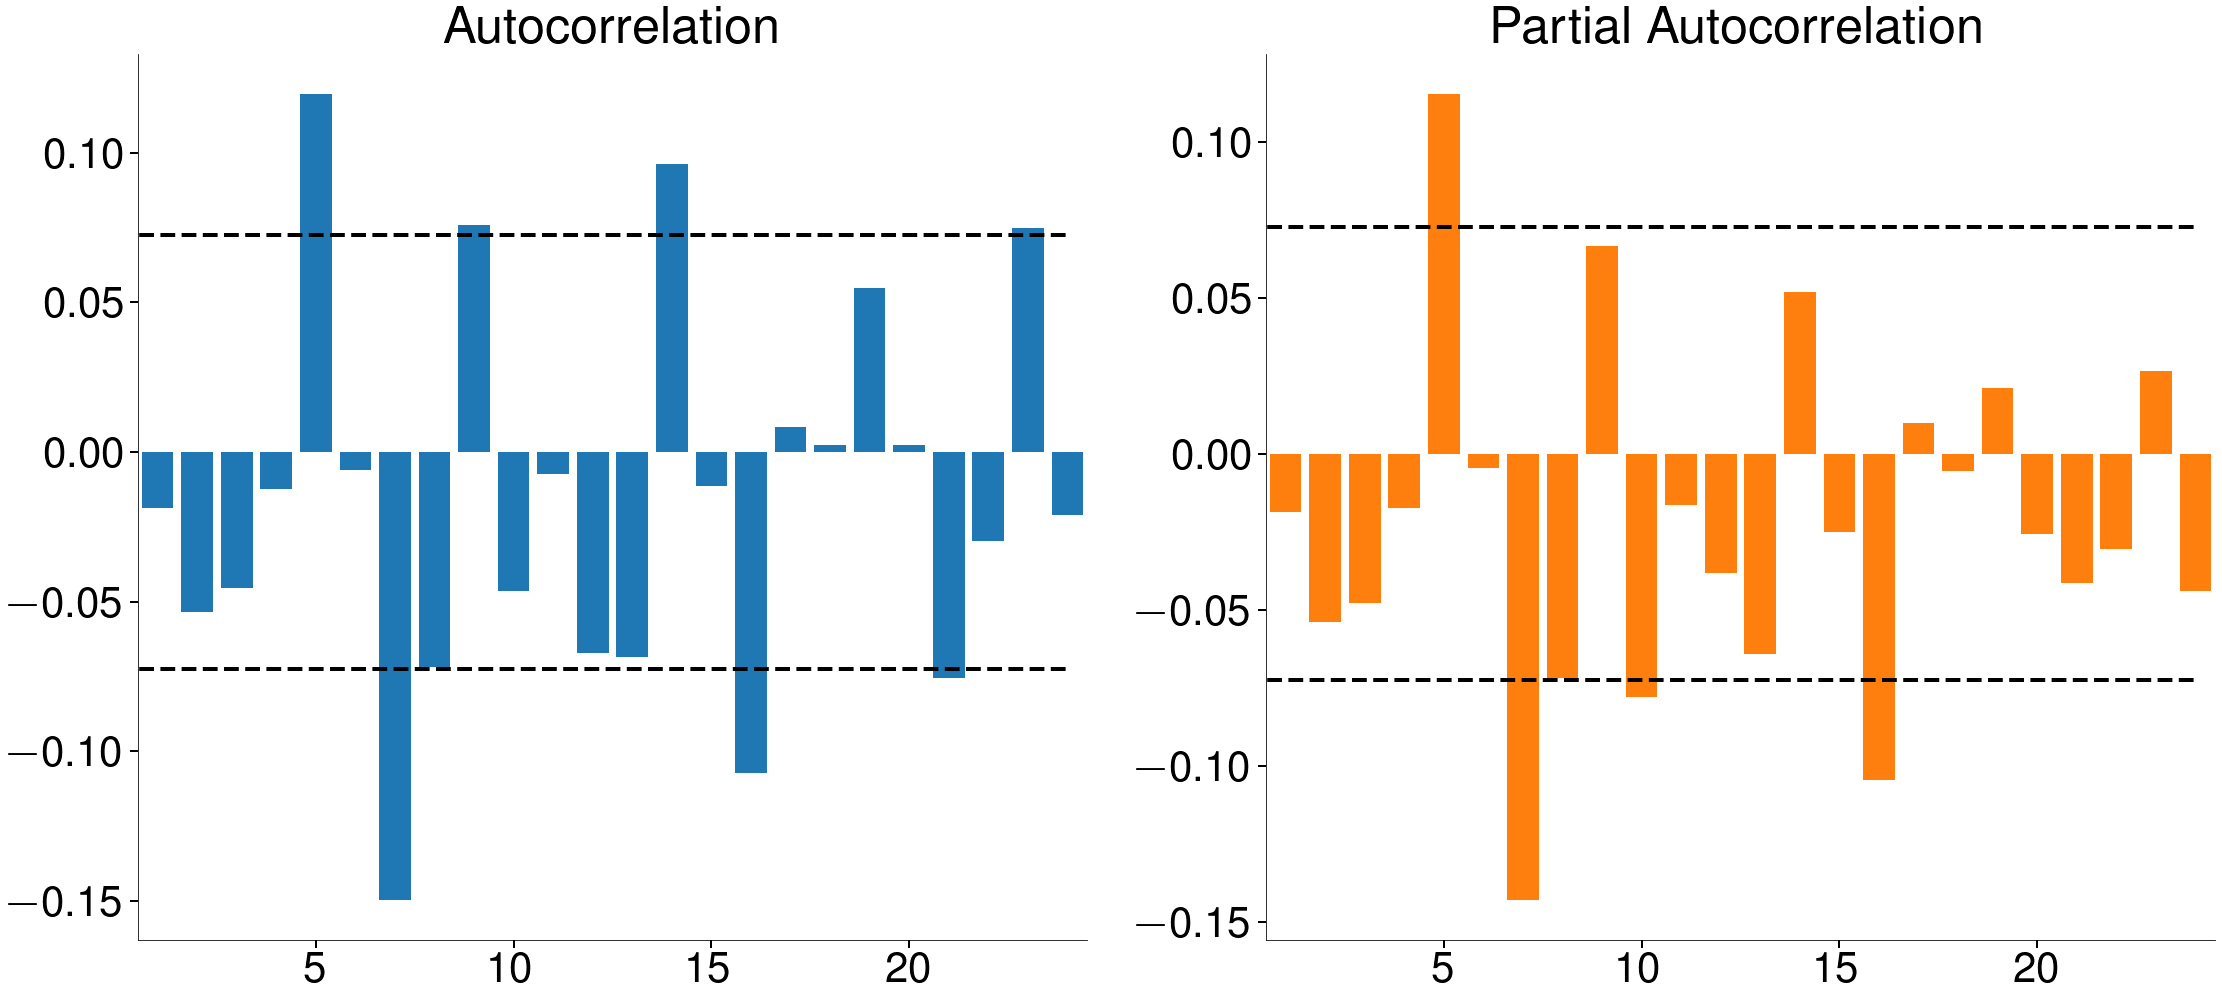

In [50]:
res = SARIMAX(default, order=(1, 0, 1)).fit()
resid = res.resid.iloc[1:]
acf_pacf_plot(resid, 24)

# $Q$ Statistic on ARMA(1,1)

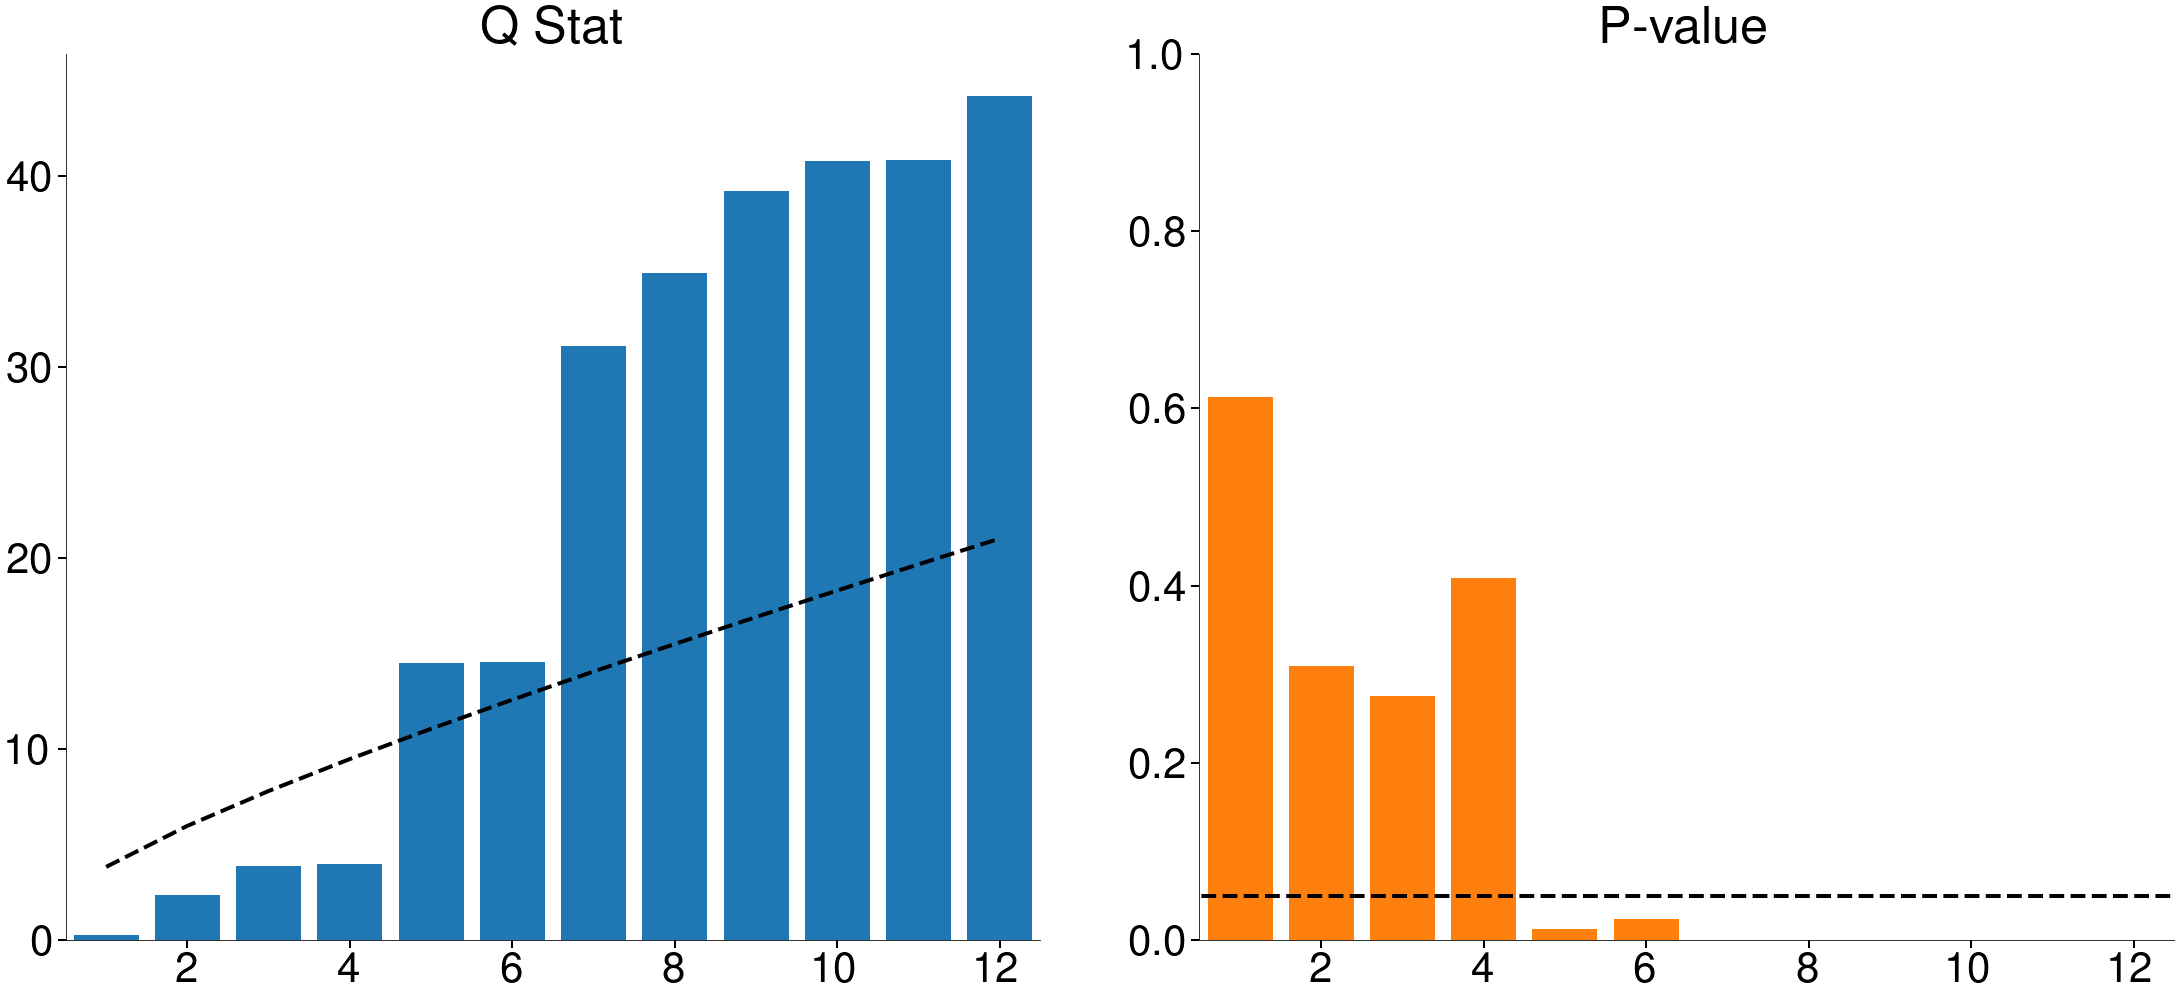

In [51]:
lb_plot(resid, 12)

# Diagnostics on ARMA(5,1)

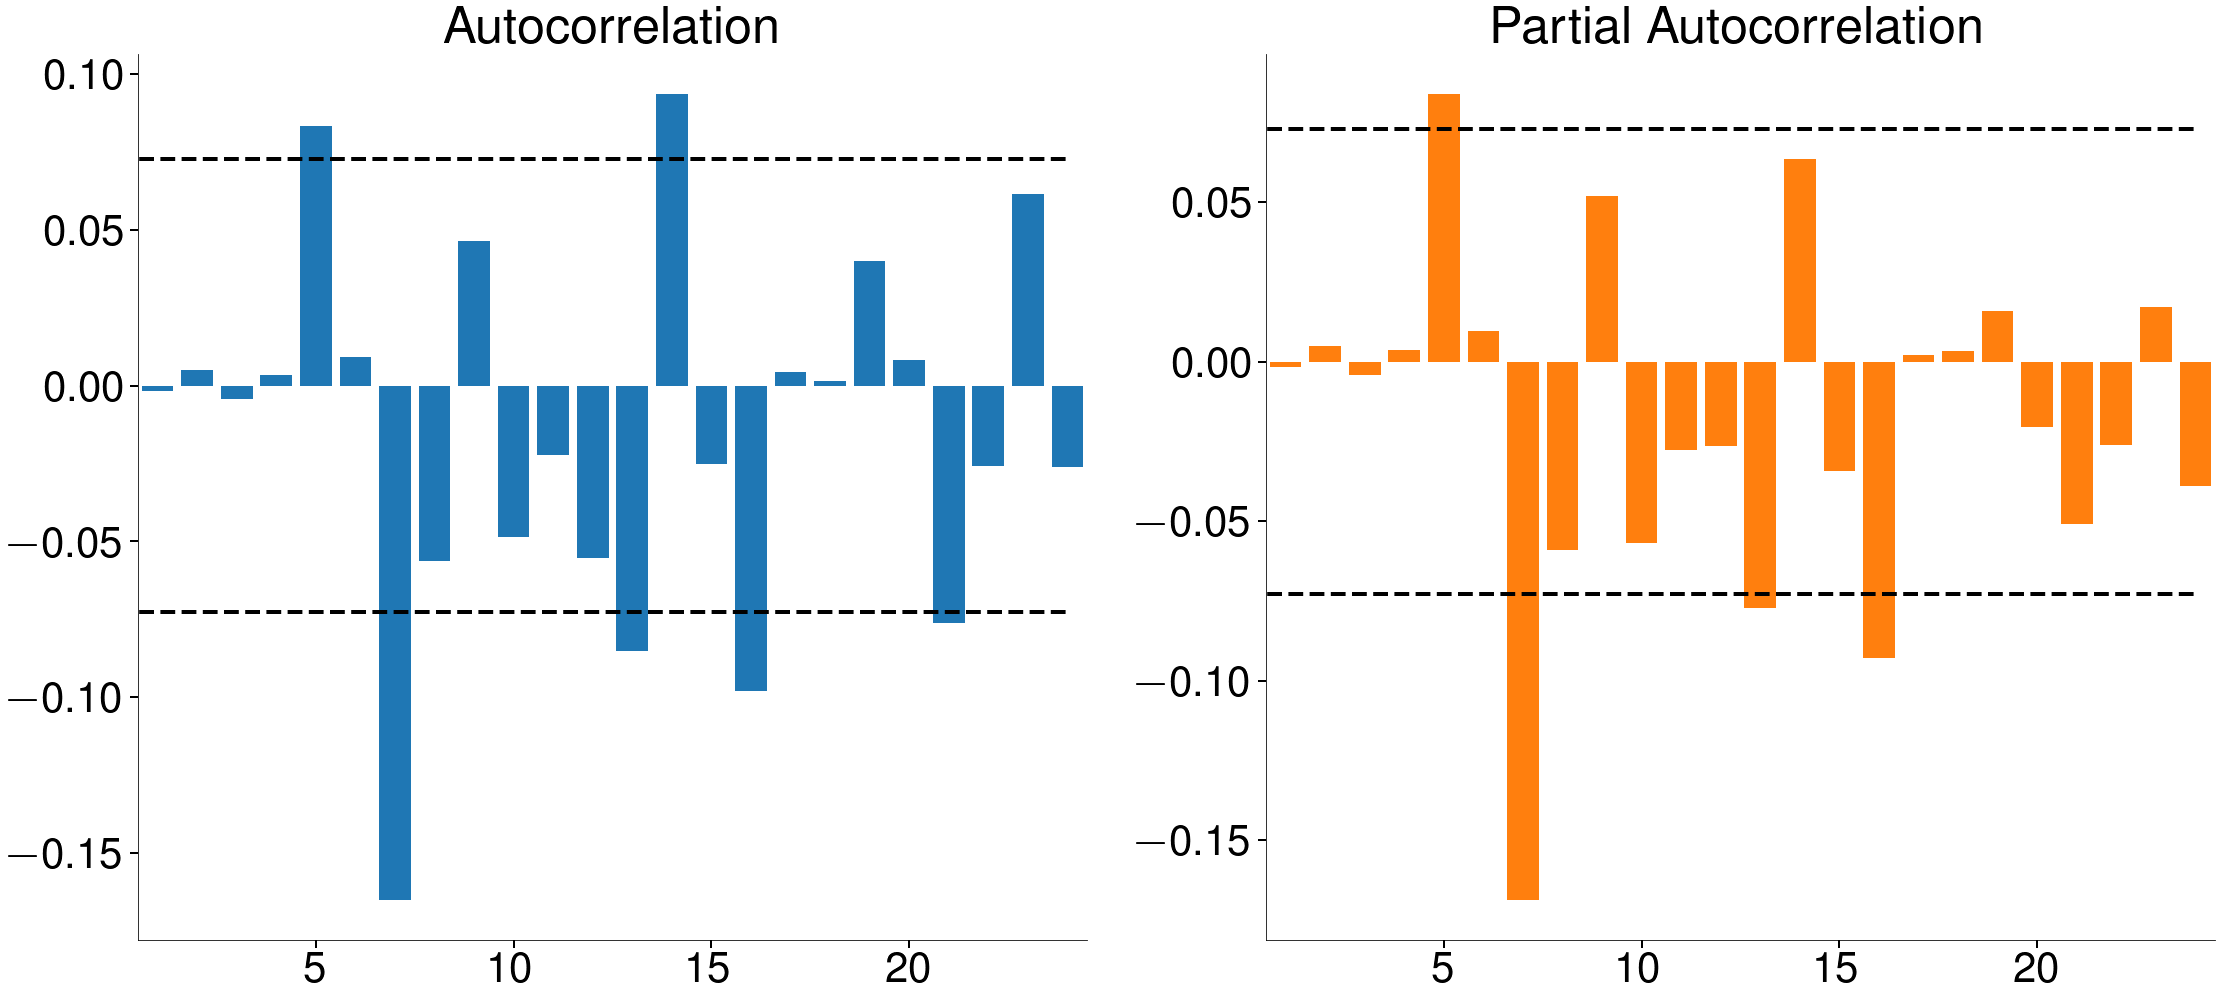

In [52]:
res = SARIMAX(default, order=(5, 0, 1)).fit()
resid = res.resid.iloc[5:]
acf_pacf_plot(resid, 24)

# $Q$ Statistic on ARMA(5,1) Residuals

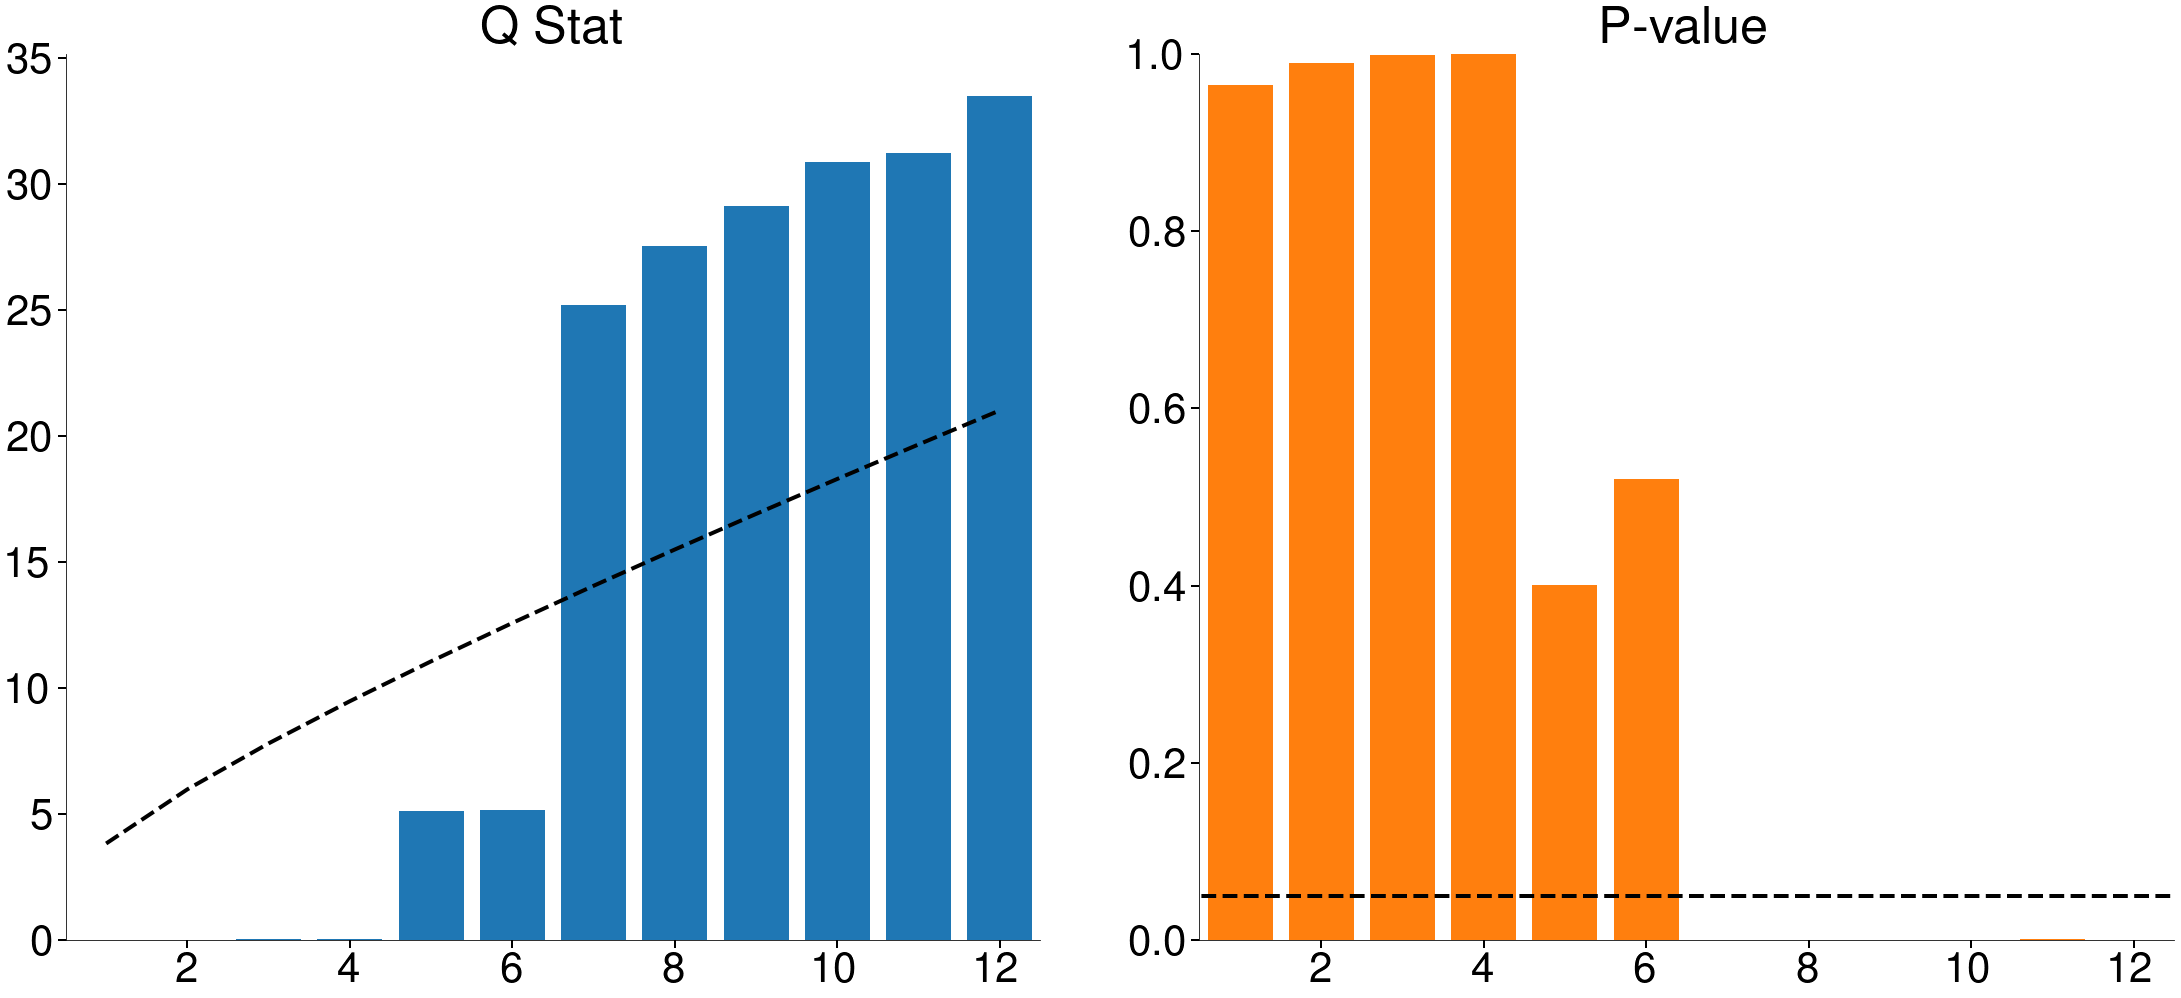

In [53]:
lb_plot(resid, 12)

# Residual Diagnostics on ARMA(10,1)

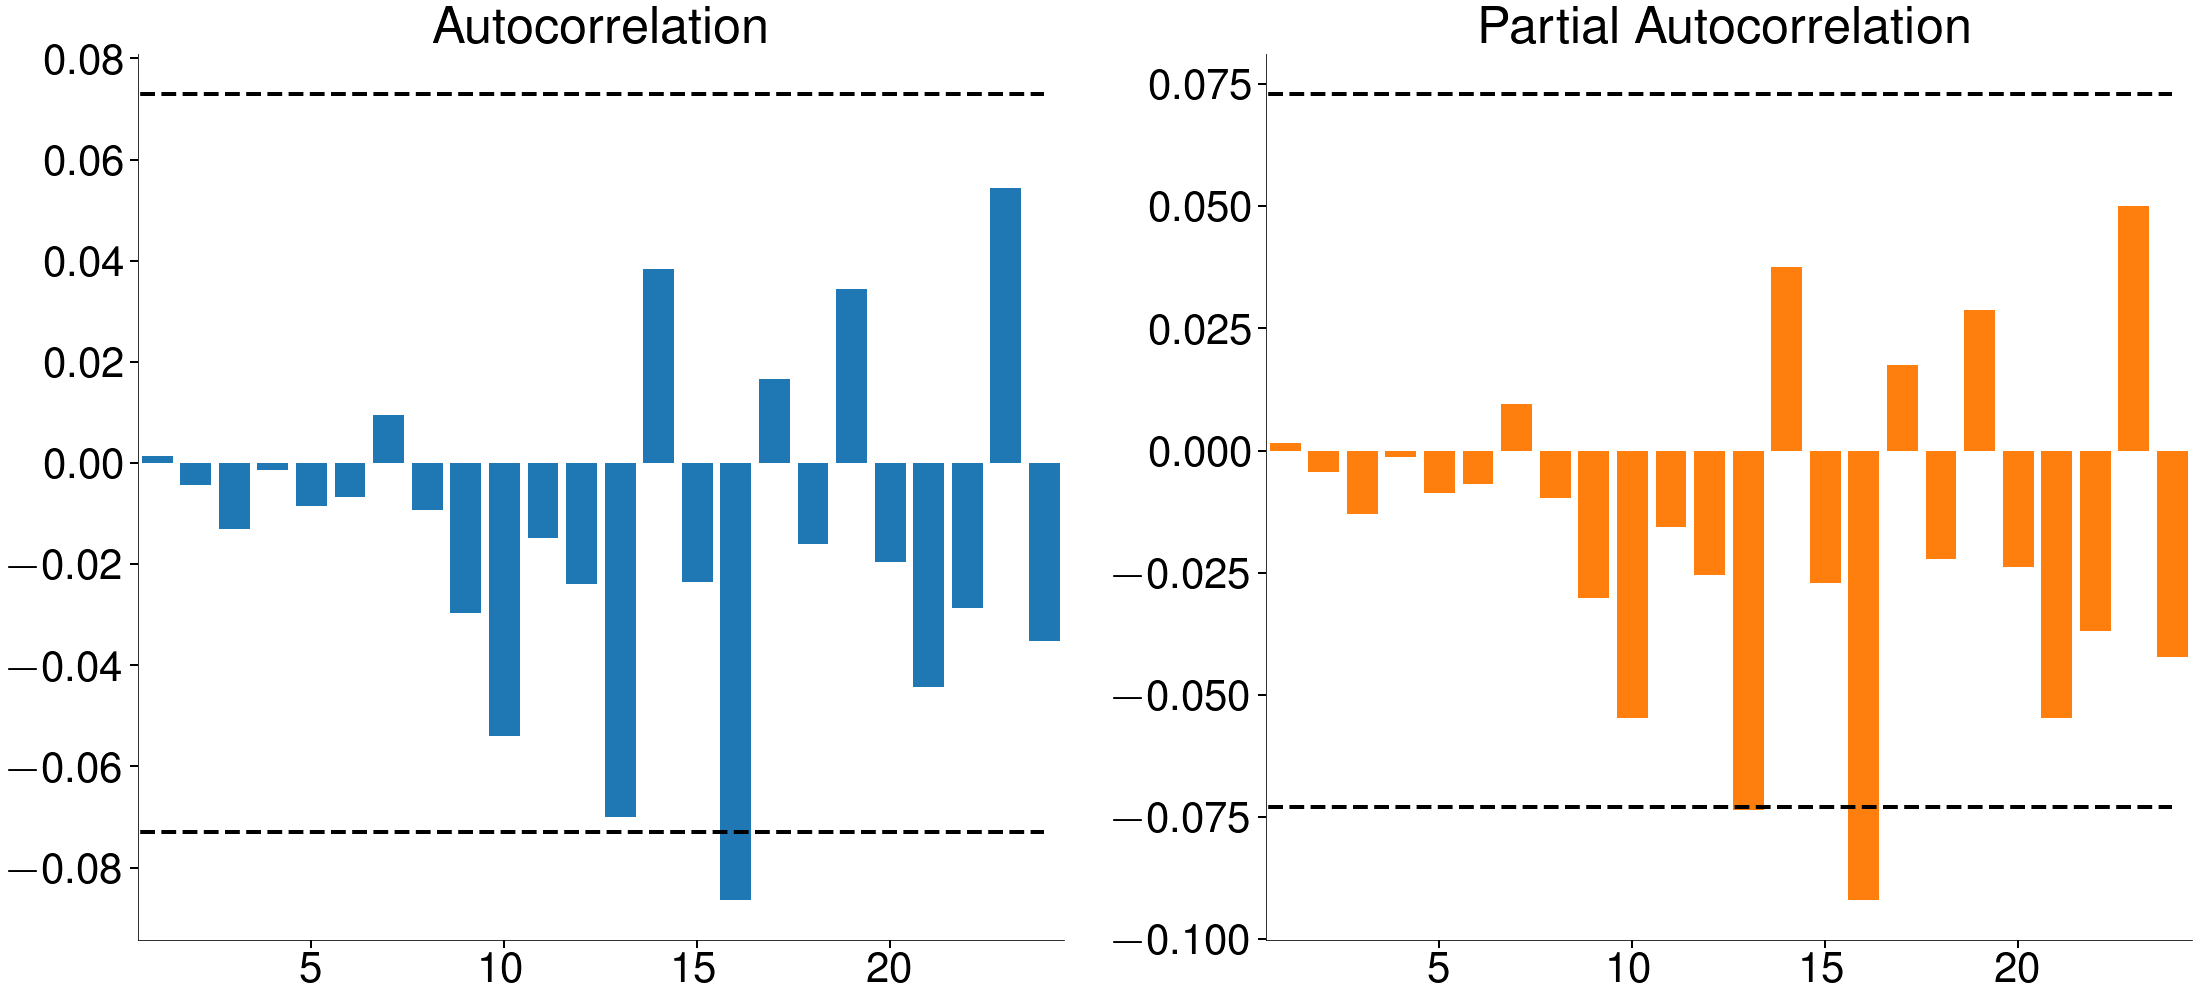

In [54]:
res = SARIMAX(default, order=(10, 0, 1)).fit()
resid = res.resid.iloc[10:]
acf_pacf_plot(resid, 24)

# $Q$ Statistic on ARMA(10,1) Residuals

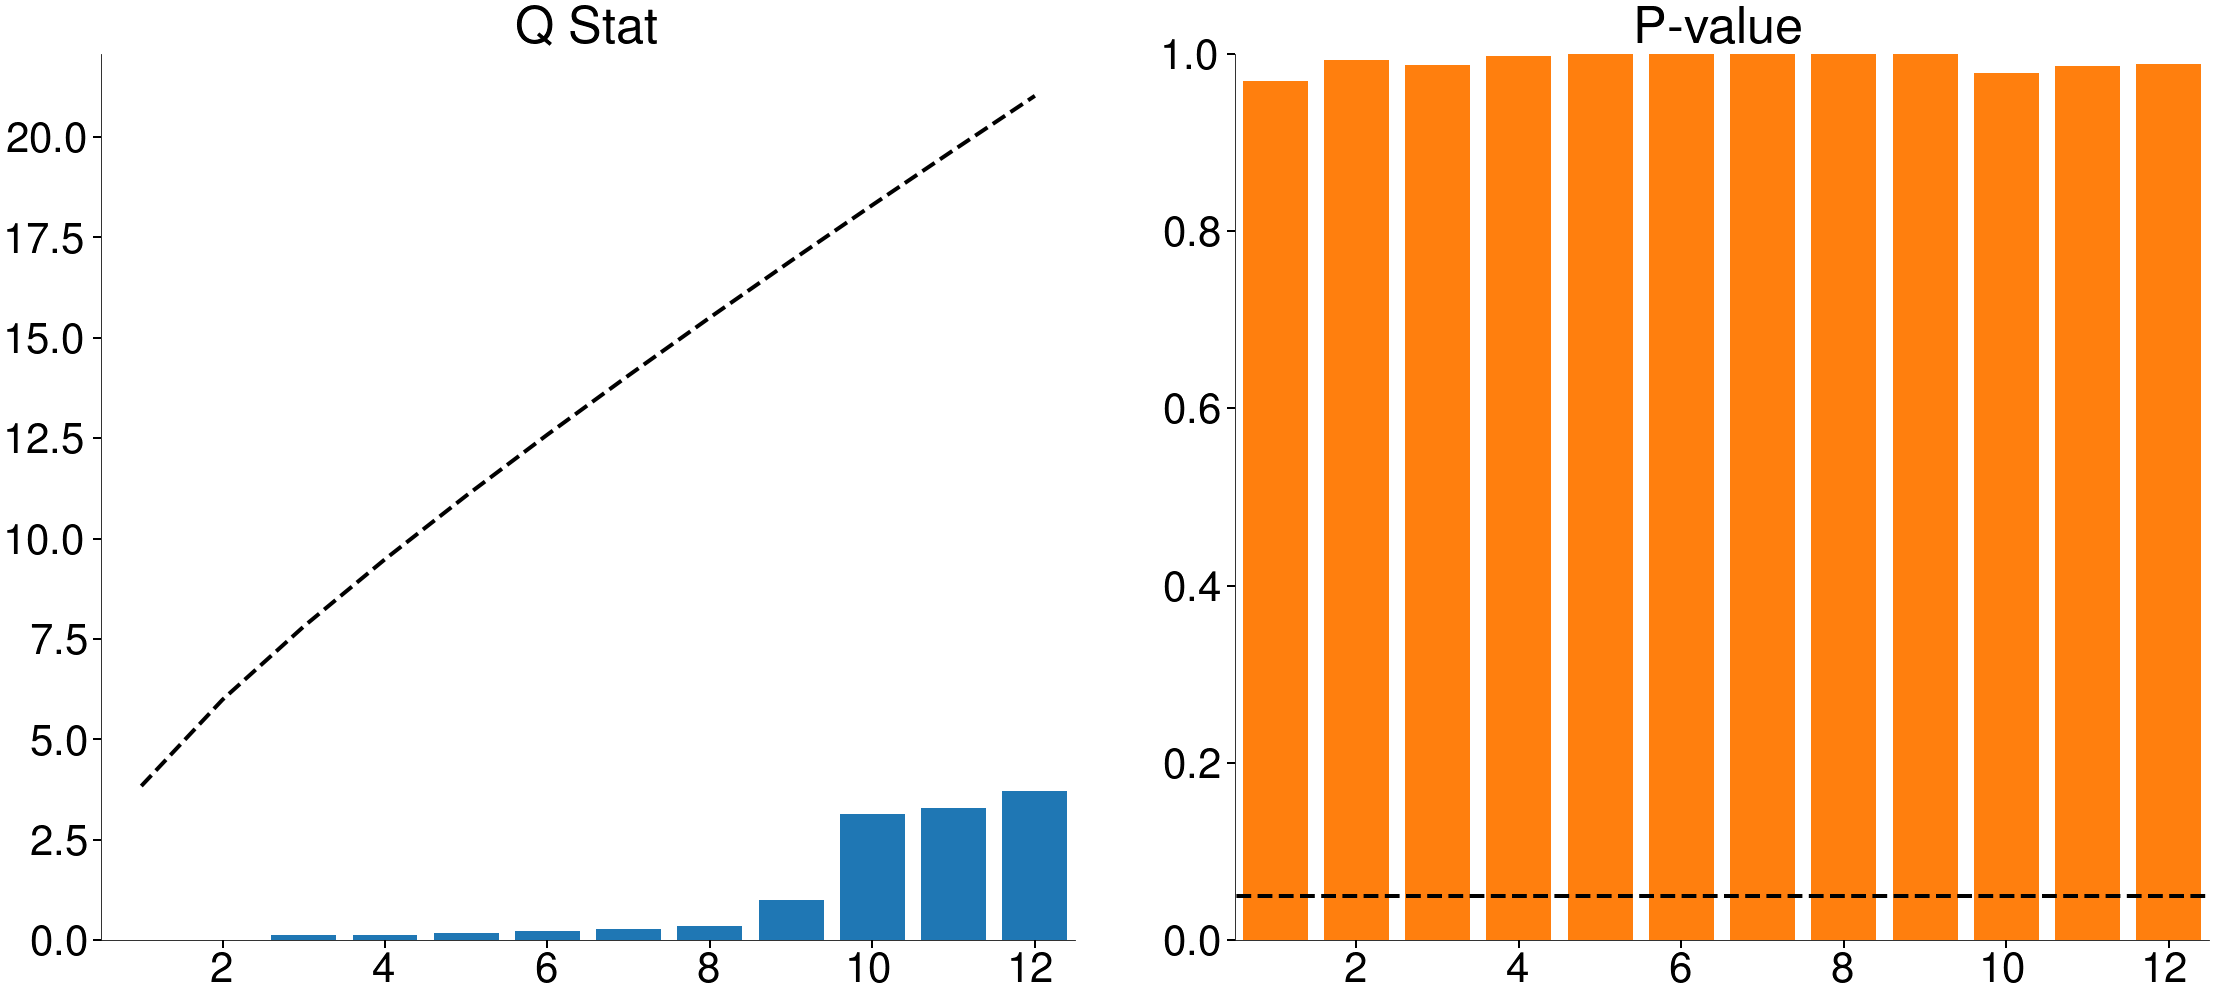

In [55]:
lb_plot(resid, 12)

# ARMA(10,1) Coefficients

In [56]:
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.7058,0.202,3.501,0.000,0.311,1.101
ar.L2,0.3550,0.262,1.354,0.176,-0.159,0.869
ar.L3,-0.1445,0.100,-1.448,0.148,-0.340,0.051
ar.L4,0.0532,0.054,0.985,0.324,-0.053,0.159
ar.L5,0.1210,0.030,4.010,0.000,0.062,0.180
ar.L6,-0.0731,0.041,-1.775,0.076,-0.154,0.008
ar.L7,-0.1793,0.049,-3.668,0.000,-0.275,-0.083
ar.L8,0.0536,0.032,1.680,0.093,-0.009,0.116
ar.L9,0.1710,0.036,4.803,0.000,0.101,0.241
ar.L10,-0.0718,0.032,-2.270,0.023,-0.134,-0.010


In [57]:
from pandas import IndexSlice


def ic_plot(aic, bic):
    figsize(y=DEFAULT_FIGSIZE[1] - 1)
    fig, ax = plt.subplots(1, 2)
    for i in range(3):
        aic.loc[(slice(None), i)].plot(
            ax=ax[0], linestyle="none", marker="s", markersize=24
        )
        xl = aic.loc[(slice(None), i)].index
    ax[0].plot(
        [aic.idxmin()[0]],
        [aic.min()],
        linestyle="none",
        marker="o",
        markersize=64,
        color=mfe.colors[7],
        zorder=-3,
        alpha=0.33,
    )
    for i in range(3):
        bic.loc[(slice(None), i)].plot(
            ax=ax[1], linestyle="none", marker="s", markersize=24, label=f"Q={i}"
        )
    ax[1].plot(
        [bic.idxmin()[0]],
        [bic.min()],
        linestyle="none",
        marker="o",
        markersize=64,
        color=mfe.colors[7],
        zorder=-3,
        alpha=0.33,
    )
    ax[1].legend(frameon=False, loc="lower right")
    ax[0].set_title("AIC")
    ax[0].set_xticks(xl)
    ax[1].set_xticks(xl)
    ax[1].set_title("BIC")
    yl = ax[0].get_ylim()
    ax[0].set_ylim(2 * aic.min() - aic.median(), 2 * aic.median() - aic.min())
    ax[1].set_ylim(2 * bic.min() - bic.median(), 2 * bic.median() - bic.min())
    ax[0].set_xlabel("P")
    ax[1].set_xlabel("P")
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

In [58]:
results = {}
for p in range(13):
    for q in range(3):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = SARIMAX(default, order=(p, 0, q)).fit()
        results[(p, q)] = pd.Series([res.aic, res.bic], index=["AIC", "BIC"])
results = pd.DataFrame(results).T
aic = results.AIC
bic = results.BIC

# IC Selection
## Default Premium

* Fit models with $P$ and $Q$ on a grid
* Select smalled AIC or BIC
  * BIC always selects a (weakly) smaller model
  


In [59]:
aic.idxmin()

(9, 2)

In [60]:
bic.idxmin()

(1, 1)

# IC Selection
## Default Premium

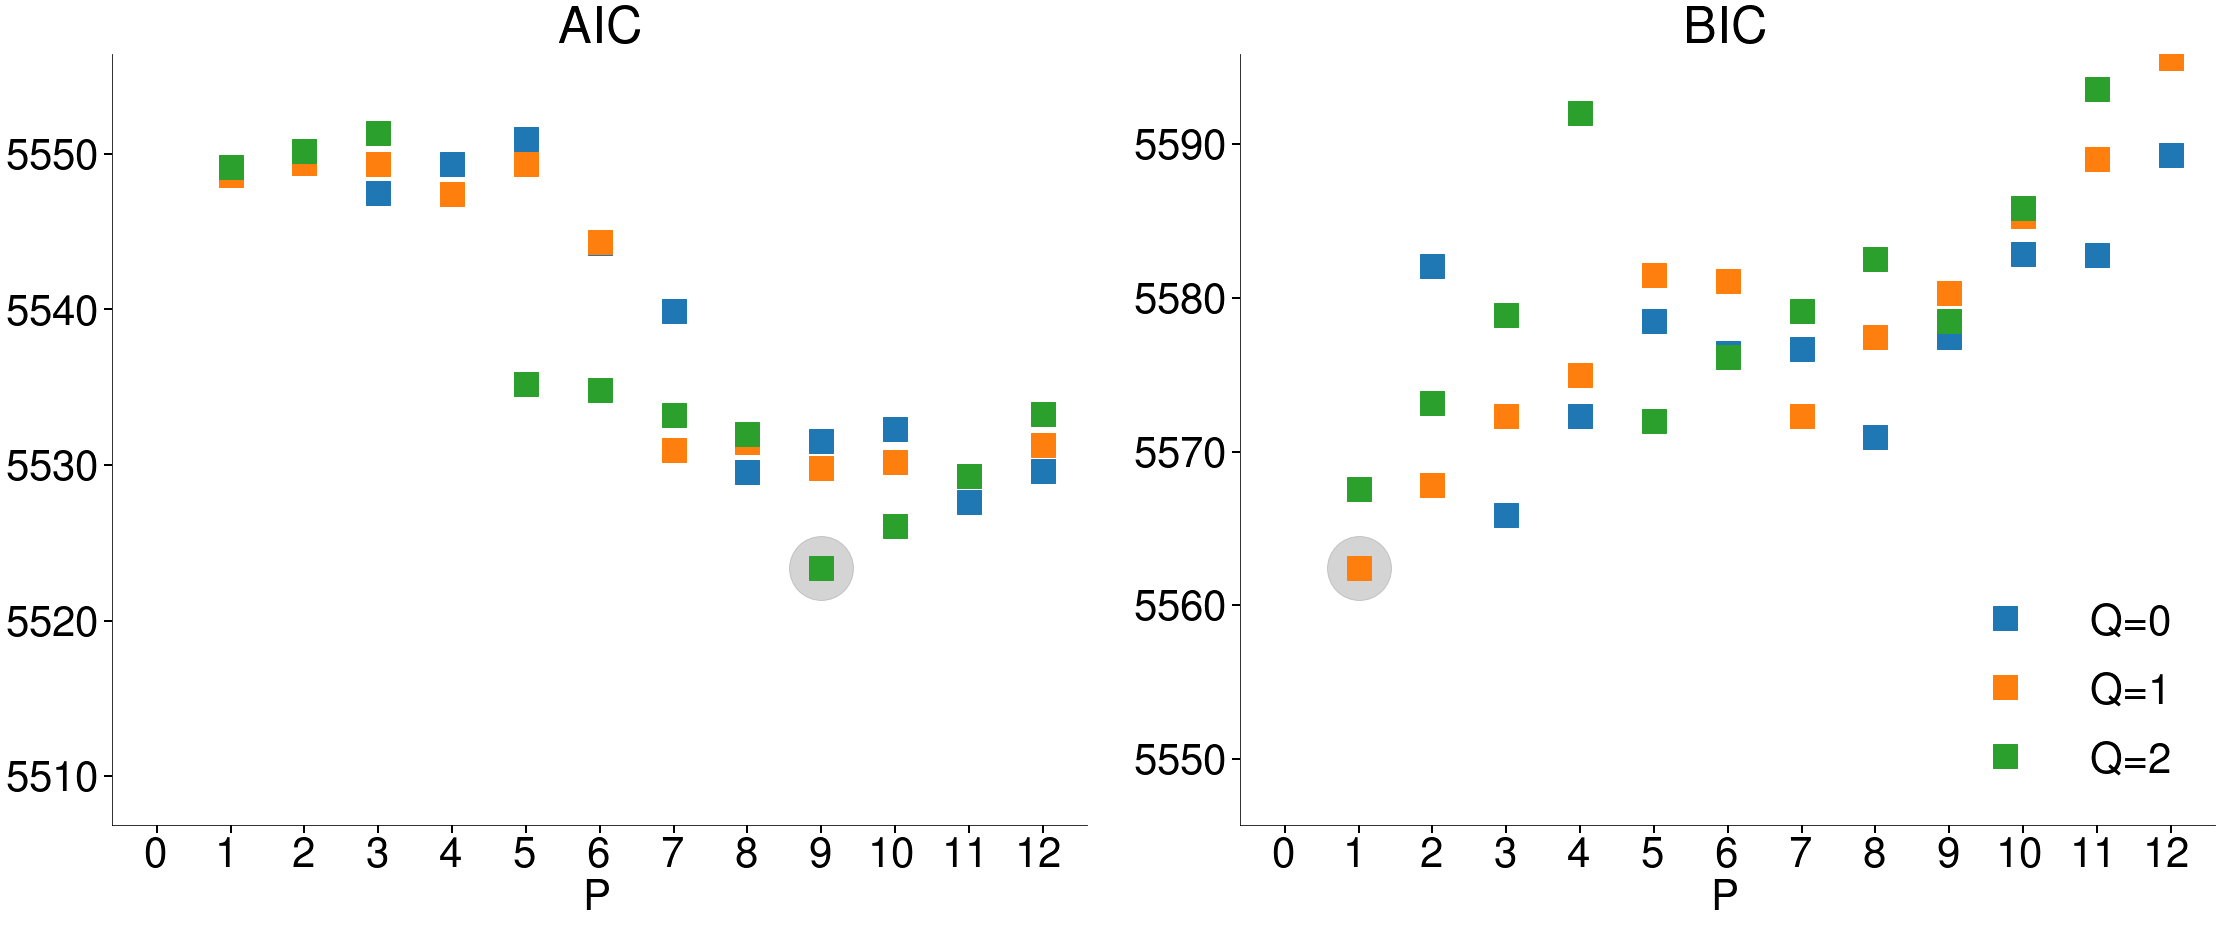

In [61]:
ic_plot(aic, bic)

In [62]:
results = {}
for p in range(13):
    for q in range(3):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = SARIMAX(uscons, order=(p, 0, q)).fit()
        results[(p, q)] = pd.Series([res.aic, res.bic], index=["AIC", "BIC"])
results = pd.DataFrame(results).T
aic = results.AIC
bic = results.BIC

# IC Selection
## US Construction Worker Growth

In [63]:
aic.idxmin()

(2, 1)

In [64]:
bic.idxmin()

(0, 2)

# IC Selection
## US Construction Worker Growth

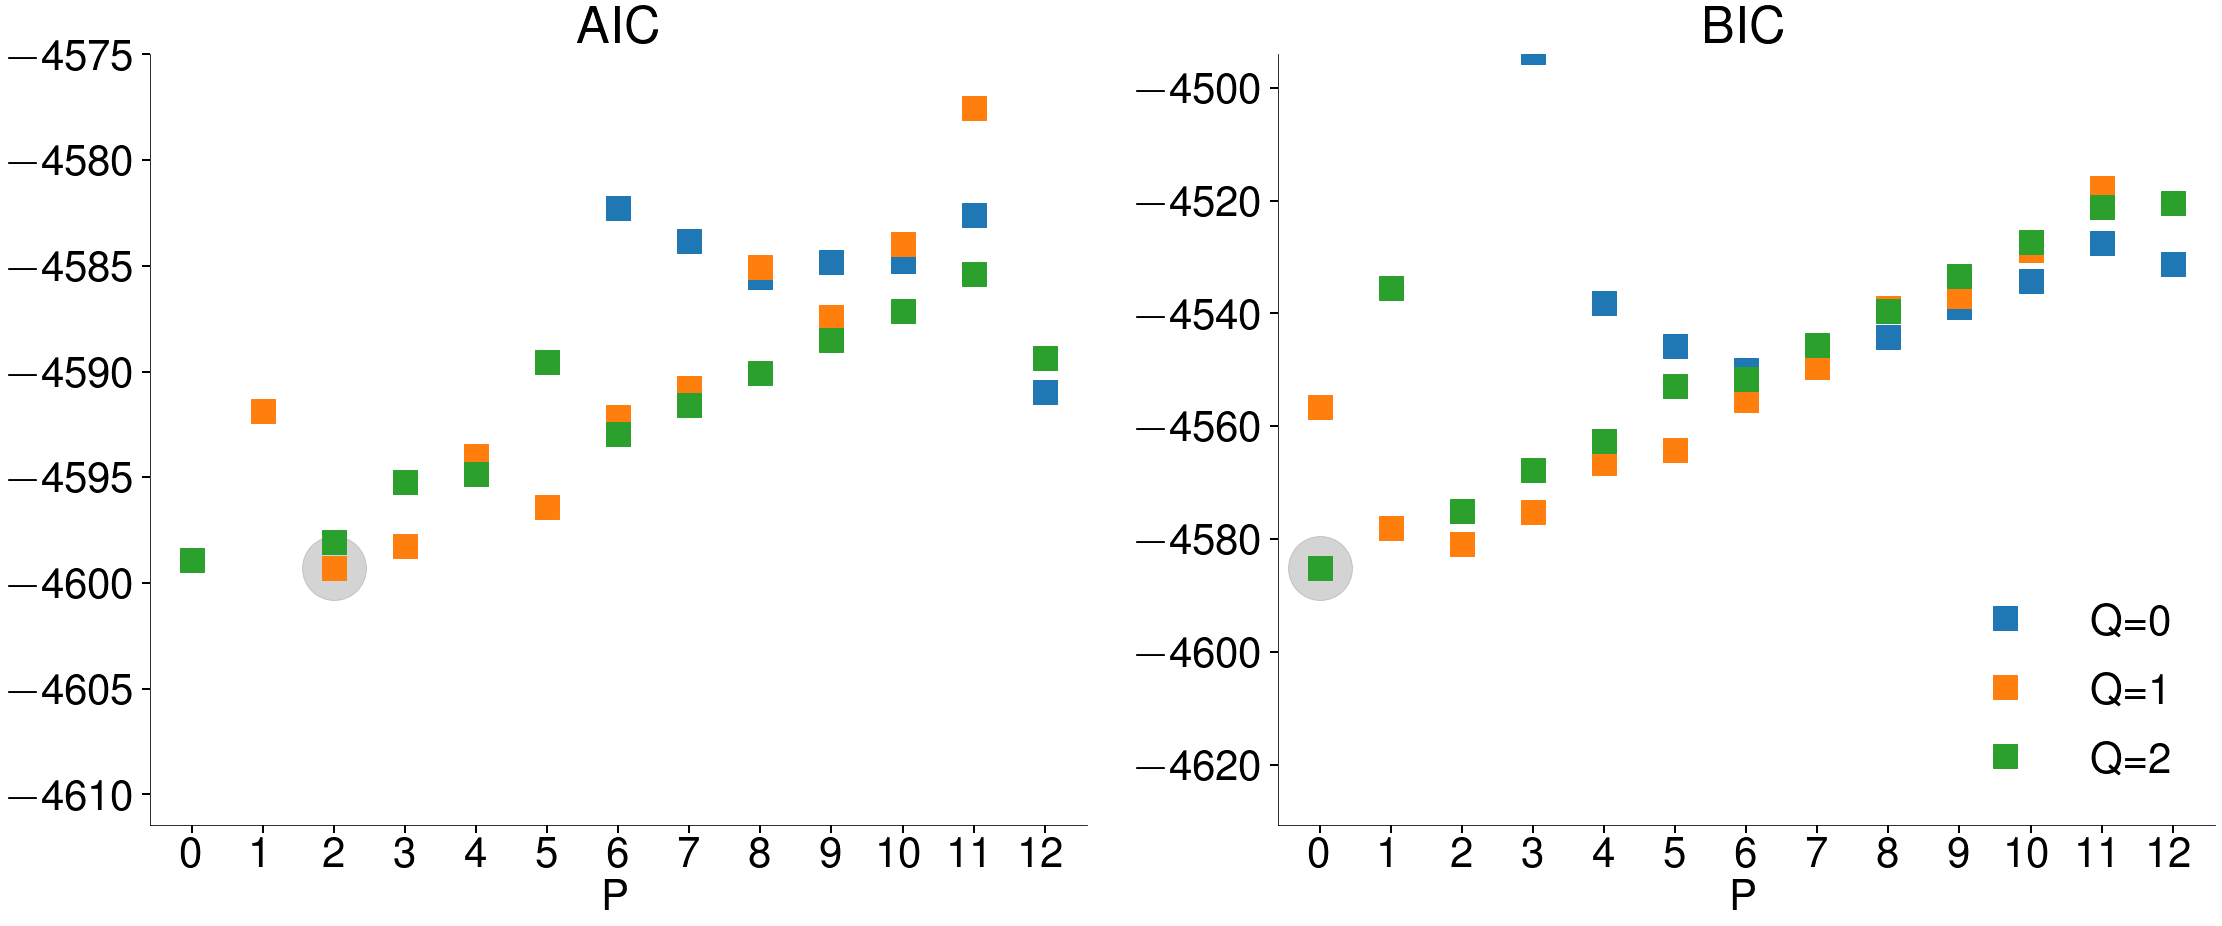

In [65]:
ic_plot(aic, bic)

# Next Week

* Forecasting
* Seasonality
* Time Trends
* Unit roots and random walks
